In [19]:
! jupyter nbconvert --to html AnalysePerspectivesV2.ipynb

[NbConvertApp] Converting notebook AnalysePerspectivesV2.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 48 image(s).
[NbConvertApp] Writing 4859127 bytes to AnalysePerspectivesV2.html


# Eval runs

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr
import seaborn as sns
import re
import matplotlib.cm as cm
import matplotlib.colors as mcolors

pd.set_option('display.max_columns', None)

In [2]:
def process_and_plot_mrr(file_path, ylim, full_concat_mrr_ref, last_n=9999999):
    with open(file_path, 'r') as file:
        data = file.readlines()

    results = []

    # -----------------------------
    # Regex patterns (MRR + GBIG)
    # -----------------------------
    experiment_pattern = re.compile(r"Perform 1:N Evaluation on (\[.*?\])")

    front_pattern = re.compile(
        r"Front RR1: [\d\.]+ MRR: ([\d\.]+) GBIG: ([\d\.]+) AUC: ([\d\.]+)"
    )
    concat_pattern = re.compile(
        r"Concat RR1: [\d\.]+ MRR: ([\d\.]+) GBIG: ([\d\.]+) AUC: ([\d\.]+)"
    )
    concat_mean_pattern = re.compile(
        r"Concat_Mean RR1: [\d\.]+ MRR: ([\d\.]+) GBIG: ([\d\.]+) AUC: ([\d\.]+)"
    )

    current_experiment = None

    for line in data:
        exp_match = experiment_pattern.search(line)
        front_match = front_pattern.search(line)
        concat_match = concat_pattern.search(line)
        concat_mean_match = concat_mean_pattern.search(line)

        if exp_match:
            current_experiment = exp_match.group(1)

        if (
            current_experiment
            and front_match
            and concat_match
            and concat_mean_match
        ):
            front_mrr = float(front_match.group(1))
            front_gbig = float(front_match.group(2))
            front_auc = float(front_match.group(3))

            concat_mrr = float(concat_match.group(1))
            concat_gbig = float(concat_match.group(2))
            concat_auc = float(concat_match.group(3))

            concat_mean_mrr = float(concat_mean_match.group(1))
            concat_mean_gbig = float(concat_mean_match.group(2))
            concat_mean_auc = float(concat_mean_match.group(3))

            results.append(
                (
                    current_experiment,
                    front_mrr, front_gbig, front_auc,
                    concat_mrr, concat_gbig, concat_auc,
                    concat_mean_mrr, concat_mean_gbig, concat_mean_auc
                )
            )
            current_experiment = None


    # -----------------------------
    # Keep only last X experiments
    # -----------------------------
    if len(results) > last_n:
        results = results[-last_n:]

    experiments = [r[0] for r in results]

    front_mrrs = [r[1] for r in results]
    front_gbigs = [r[2] for r in results]
    front_aucs = [r[3] for r in results]

    concat_mrrs = [r[4] for r in results]
    concat_gbigs = [r[5] for r in results]
    concat_aucs = [r[6] for r in results]

    concat_mean_mrrs = [r[7] for r in results]
    concat_mean_gbigs = [r[8] for r in results]
    concat_mean_aucs = [r[9] for r in results]

    front_mrr_ref = front_mrrs[0]

    # -----------------------------
    # View-count coloring
    # -----------------------------
    def count_views(coord_str):
        return len(re.findall(r"\d+", coord_str))

    num_views = [count_views(r[0]) for r in results]

    norm = mcolors.Normalize(vmin=min(num_views), vmax=max(num_views))
    cmap = cm.viridis
    colors = [cmap(norm(v)) for v in num_views]

    # -----------------------------
    # Console output
    # -----------------------------
    print(
        "Exp | Front MRR | Front GBIG | Front AUC | "
        "Concat MRR | Concat GBIG | Concat AUC | "
        "Concat-Mean MRR | Concat-Mean GBIG | Concat-Mean AUC | Dataset"
    )
    print("-" * 120)

    for i, r in enumerate(results):
        print(
            f"Exp {i:02d} | "
            f"{r[1]:.4f} | {r[2]:.3f} | {r[3]:.6f} | "
            f"{r[4]:.4f} | {r[5]:.3f} | {r[6]:.6f} | "
            f"{r[7]:.4f} | {r[8]:.3f} | {r[9]:.6f} | "
            f"{r[0]}"
        )

    # -----------------------------
    # Bar plot (MRR only)
    # -----------------------------
    x = np.arange(len(experiments))
    width = 0.25

    fig, ax = plt.subplots(figsize=(20, 6))

    ax.bar(x - width, front_mrrs, width, label="Front Only MRR")
    ax.bar(x, concat_mrrs, width, label="Concat MRR")
    ax.bar(x + width, concat_mean_mrrs, width, label="Concat Mean MRR")

    ax.axhline(
        y=full_concat_mrr_ref,
        linestyle="--",
        label="FULL CONCAT (MRR)"
    )

    ax.set_ylabel("MRR")
    ax.set_xticks(x)
    ax.set_xticklabels([f"Exp {i}" for i in range(len(experiments))], rotation=90)
    ax.set_ylim(ylim)
    ax.legend()

    plt.tight_layout()
    plt.show()

    # -----------------------------
    # Bar plot (GBIG only)
    # -----------------------------
    x = np.arange(len(experiments))
    width = 0.25

    fig, ax = plt.subplots(figsize=(20, 6))

    ax.bar(x - width, front_gbigs, width, label="Front Only GBIG")
    ax.bar(x, concat_gbigs, width, label="Concat GBIG")
    ax.bar(x + width, concat_mean_gbigs, width, label="Concat Mean GBIG")

    # Reference line (Front GBIG)
    front_gbig_ref = front_gbigs[0]
    ax.axhline(
        y=front_gbig_ref,
        linestyle="--",
        label="FRONT ONLY (GBIG)"
    )

    all_gbigs = front_gbigs + concat_gbigs + concat_mean_gbigs
    y_min = min(all_gbigs)
    y_max = max(all_gbigs)

    padding = 0.05 * (y_max - y_min)  # 5% headroom
    ax.set_ylim(y_min - padding, y_max + padding)

    ax.set_ylabel("GBIG")
    ax.set_xticks(x)
    ax.set_xticklabels(
        [f"Exp {i}" for i in range(len(experiments))],
        rotation=90
    )
    ax.legend()

    plt.tight_layout()
    plt.show()

    # -----------------------------
    # Bar plot (AUC only)
    # -----------------------------
    x = np.arange(len(experiments))
    width = 0.25

    fig, ax = plt.subplots(figsize=(20, 6))

    ax.bar(x - width, front_aucs, width, label="Front Only AUC")
    ax.bar(x, concat_aucs, width, label="Concat AUC")
    ax.bar(x + width, concat_mean_aucs, width, label="Concat Mean AUC")

    # Reference line (Front AUC)
    front_auc_ref = front_aucs[0]
    ax.axhline(
        y=front_auc_ref,
        linestyle="--",
        label="FRONT ONLY (AUC)"
    )

    # Dynamic y-limits with padding
    all_aucs = front_aucs + concat_aucs + concat_mean_aucs
    y_min = min(all_aucs)
    y_max = max(all_aucs)
    padding = 0.05 * (y_max - y_min)

    ax.set_ylim(y_min - padding, y_max + padding)

    ax.set_ylabel("AUC")
    ax.set_xticks(x)
    ax.set_xticklabels(
        [f"Exp {i}" for i in range(len(experiments))],
        rotation=90
    )
    ax.legend()

    plt.tight_layout()
    plt.show()

    # -----------------------------
    # Scatter: Concat Mean vs Concat
    # -----------------------------
    fig, ax = plt.subplots(figsize=(15, 15))

    ax.scatter(concat_mean_mrrs, concat_mrrs, alpha=0.8)

    for i in range(len(experiments)):
        ax.annotate(
            f"{i}",
            (concat_mean_mrrs[i], concat_mrrs[i]),
            textcoords="offset points",
            xytext=(6, 6),
            fontsize=9,
            color=colors[i],
        )

    ax.axhline(y=front_mrr_ref, linestyle="--")
    ax.axvline(x=front_mrr_ref, linestyle="--")

    ax.set_xlabel("Concat-Mean MRR")
    ax.set_ylabel("Concat MRR")
    ax.set_xlim(ylim)
    ax.set_ylim(ylim)
    ax.grid(True)

    plt.show()

    # -----------------------------
    # Scatter: Concat-Mean GBIG vs Concat GBIG
    # -----------------------------
    fig, ax = plt.subplots(figsize=(15, 15))

    ax.scatter(concat_mean_gbigs, concat_gbigs, alpha=0.8)

    for i in range(len(experiments)):
        ax.annotate(
            f"{i}",
            (concat_mean_gbigs[i], concat_gbigs[i]),
            textcoords="offset points",
            xytext=(6, 6),
            fontsize=9,
            color=colors[i],
            alpha=0.9
        )

    # Reference lines (Front GBIG)
    front_gbig_ref = front_gbigs[0]
    ax.axhline(y=front_gbig_ref, linestyle="--")
    ax.axvline(x=front_gbig_ref, linestyle="--")

    ax.set_xlabel("Concat-Mean GBIG")
    ax.set_ylabel("Concat GBIG")
    ax.grid(True)

    plt.show()

    # -----------------------------
    # Zoomed Scatter: Upper Right Quadrant (front_gbig_ref)
    # -----------------------------
    fig, ax = plt.subplots(figsize=(15, 15))

    ax.scatter(concat_mean_gbigs, concat_gbigs, alpha=0.8)

    for i in range(len(experiments)):
        ax.annotate(
            f"{i}",
            (concat_mean_gbigs[i], concat_gbigs[i]),
            textcoords="offset points",
            xytext=(6, 6),
            fontsize=9,
            color=colors[i],
            alpha=0.9
        )

    # Reference lines
    front_gbig_ref = front_gbigs[0]
    ax.axhline(y=front_gbig_ref, linestyle="--")
    ax.axvline(x=front_gbig_ref, linestyle="--")

    # ---- ZOOM: upper right quadrant ----
    padding_x = 0.02 * (max(concat_mean_gbigs) - front_gbig_ref)
    padding_y = 0.02 * (max(concat_gbigs) - front_gbig_ref)

    ax.set_xlim(front_gbig_ref, max(concat_mean_gbigs) + padding_x)
    ax.set_ylim(front_gbig_ref, max(concat_gbigs) + padding_y)

    ax.set_xlabel("Concat-Mean GBIG")
    ax.set_ylabel("Concat GBIG")
    ax.grid(True)

    plt.show()

    # -----------------------------
    # Scatter: Concat MRR vs Concat GBIG
    # -----------------------------
    fig, ax = plt.subplots(figsize=(35, 25))

    ax.scatter(concat_mrrs, concat_gbigs, alpha=0.8)

    for i in range(len(experiments)):
        ax.annotate(
            f"{i}",
            (concat_mrrs[i], concat_gbigs[i]),
            textcoords="offset points",
            xytext=(6, 6),
            fontsize=9,
            color=colors[i],
            alpha=0.9
        )

    ax.axvline(x=front_mrr_ref, linestyle="--")
    ax.axhline(y=front_gbig_ref, linestyle="--")

    padding_x = 0.02 * (max(concat_mean_gbigs) - front_gbig_ref)
    padding_y = 0.02 * (max(concat_gbigs) - front_gbig_ref)

    ax.set_xlim(front_mrr_ref, 100.005)
    ax.set_ylim(front_gbig_ref, max(concat_gbigs) + padding_y)

    ax.set_xlabel("Concat MRR")
    ax.set_ylabel("Concat GBIG")
    ax.grid(True)
    plt.show()

    # -----------------------------
    # Scatter: Concat-Mean AUC vs Concat-Mean GBIG
    # -----------------------------
    fig, ax = plt.subplots(figsize=(15, 15))

    ax.scatter(concat_mean_aucs, concat_mean_gbigs, alpha=0.8)

    for i in range(len(experiments)):
        ax.annotate(
            f"{i}",
            (concat_mean_aucs[i], concat_mean_gbigs[i]),
            textcoords="offset points",
            xytext=(6, 6),
            fontsize=9,
            color=colors[i],
            alpha=0.9
        )
    front_auc_ref = front_aucs[0]
    front_gbig_ref = front_gbigs[0]
    ax.axvline(x=front_auc_ref, linestyle="--", label="Front AUC")
    ax.axhline(y=front_gbig_ref, linestyle="--", label="Front GBIG")
    ax.set_xlabel("Concat-Mean AUC")
    ax.set_ylabel("Concat-Mean GBIG")
    ax.grid(True)
    ax.legend()
    plt.show()


    # -----------------------------
    # Scatter: Zoomed Concat-Mean AUC vs Concat-Mean GBIG
    # -----------------------------
    fig, ax = plt.subplots(figsize=(25, 25))

    ax.scatter(concat_mean_aucs, concat_mean_gbigs, alpha=0.8)

    for i in range(len(experiments)):
        ax.annotate(
            f"{i}",
            (concat_mean_aucs[i], concat_mean_gbigs[i]),
            textcoords="offset points",
            xytext=(6, 6),
            fontsize=9,
            color=colors[i],
            alpha=0.9
        )
    front_auc_ref = front_aucs[0]
    front_gbig_ref = front_gbigs[0]

    # ---- ZOOM: upper right quadrant ----
    padding_x = 0.01 * (max(concat_mean_aucs) - front_auc_ref)
    padding_y = 0.01 * (max(concat_mean_gbigs) - front_gbig_ref)

    ax.set_xlim(
        front_auc_ref,
        max(concat_mean_aucs) + padding_x
    )
    ax.set_ylim(
        front_gbig_ref,
        max(concat_mean_gbigs) + padding_y
    )
    ax.set_xlabel("Concat-Mean AUC")
    ax.set_ylabel("Concat-Mean GBIG")


    experiment_dict = {}

    for r in results:
        experiment_dict[r[0]] = {
            "front_mrr": r[1],
            "front_gbig": r[2],
            "front_auc": r[3],
            "concat_mrr": r[4],
            "concat_gbig": r[5],
            "concat_auc": r[6],
            "concat_mean_mrr": r[7],
            "concat_mean_gbig": r[8],
            "concat_mean_auc": r[9],
        }

    #return experiment_dict



Exp | Front MRR | Front GBIG | Front AUC | Concat MRR | Concat GBIG | Concat AUC | Concat-Mean MRR | Concat-Mean GBIG | Concat-Mean AUC | Dataset
------------------------------------------------------------------------------------------------------------------------
Exp 00 | 99.4680 | 27.454 | 99.966624 | 99.4680 | 27.454 | 99.966624 | 99.4680 | 27.454 | 99.966624 | ['0_0']
Exp 01 | 99.4680 | 27.454 | 99.966624 | 99.9690 | 27.857 | 99.997536 | 99.9700 | 28.865 | 99.998848 | ['0_0', '-25_0', '-10_0', '25_0', '10_0']
Exp 02 | 99.4680 | 27.454 | 99.966624 | 99.8120 | 25.430 | 99.982432 | 99.6680 | 24.610 | 99.984138 | ['0_0', '0_-25', '0_-10', '0_10', '0_25']
Exp 03 | 99.4680 | 27.454 | 99.966624 | 99.9450 | 24.233 | 99.994814 | 99.8980 | 23.643 | 99.997753 | ['0_0', '-25_-25', '-10_-10', '10_10', '25_25']
Exp 04 | 99.4680 | 27.454 | 99.966624 | 99.9420 | 24.073 | 99.995178 | 99.9140 | 23.689 | 99.997801 | ['0_0', '-25_25', '-10_10', '10_-10', '25_-25']
Exp 05 | 99.4680 | 27.454 | 99.9666

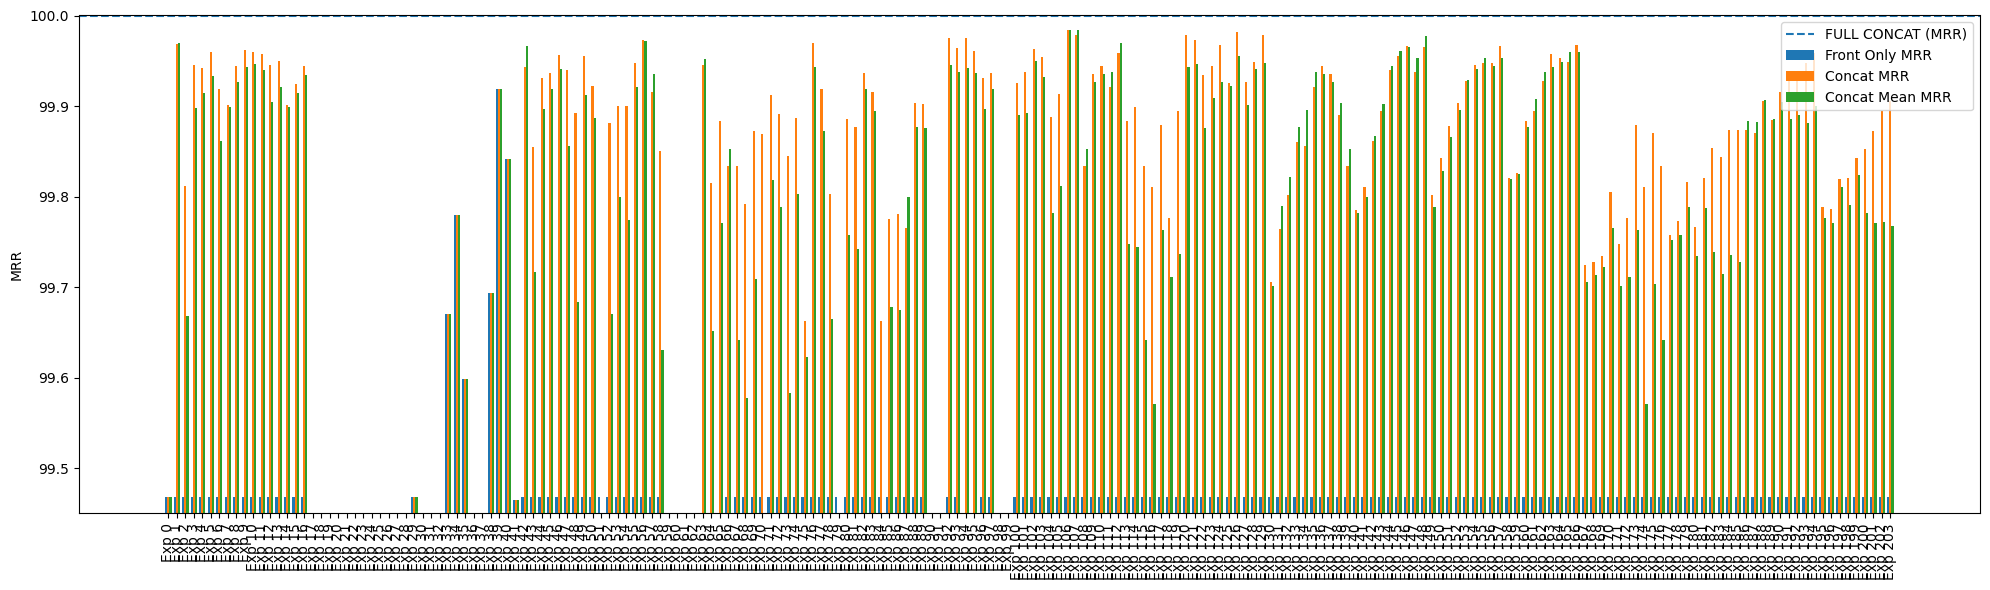

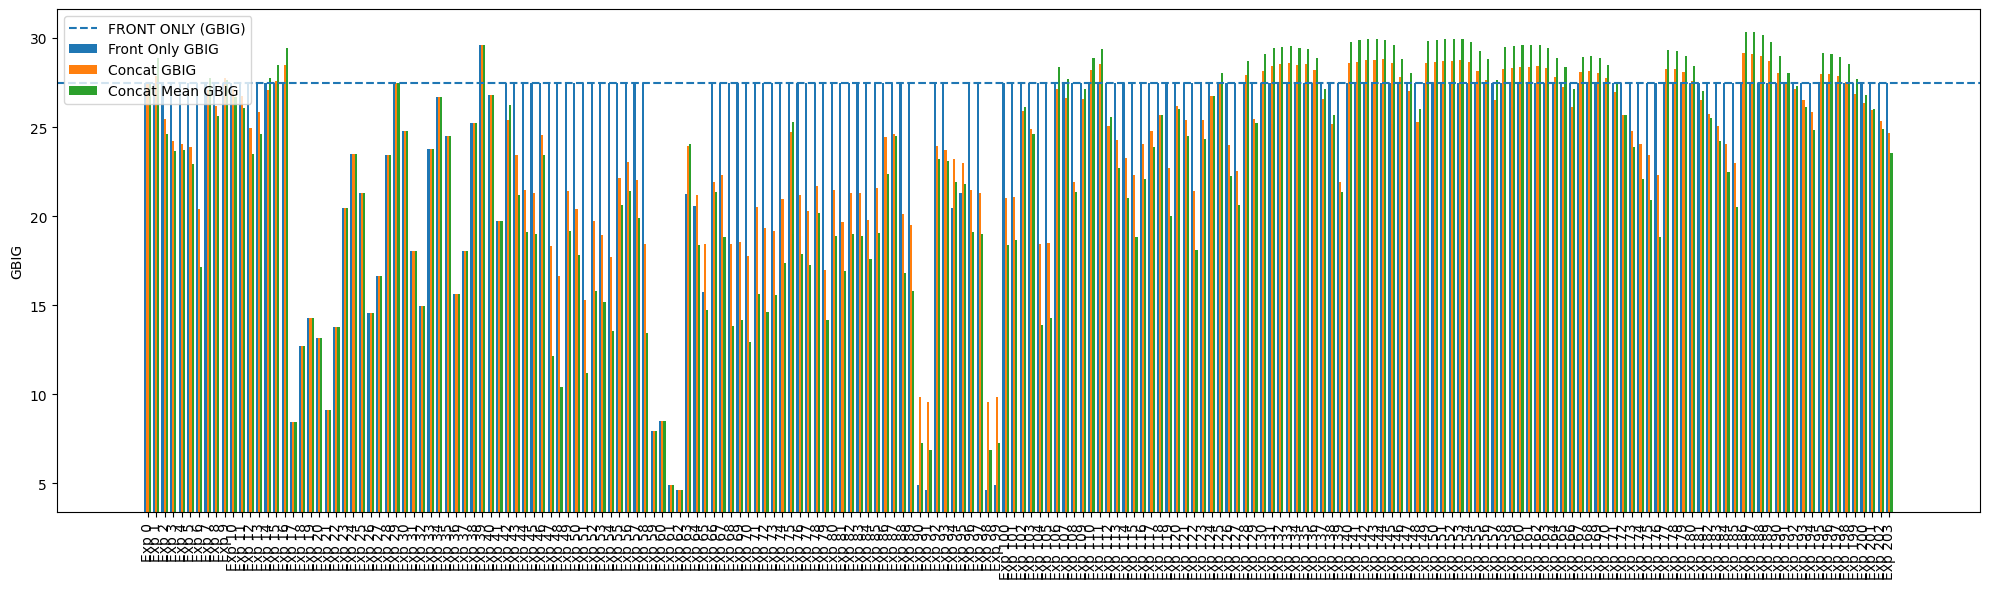

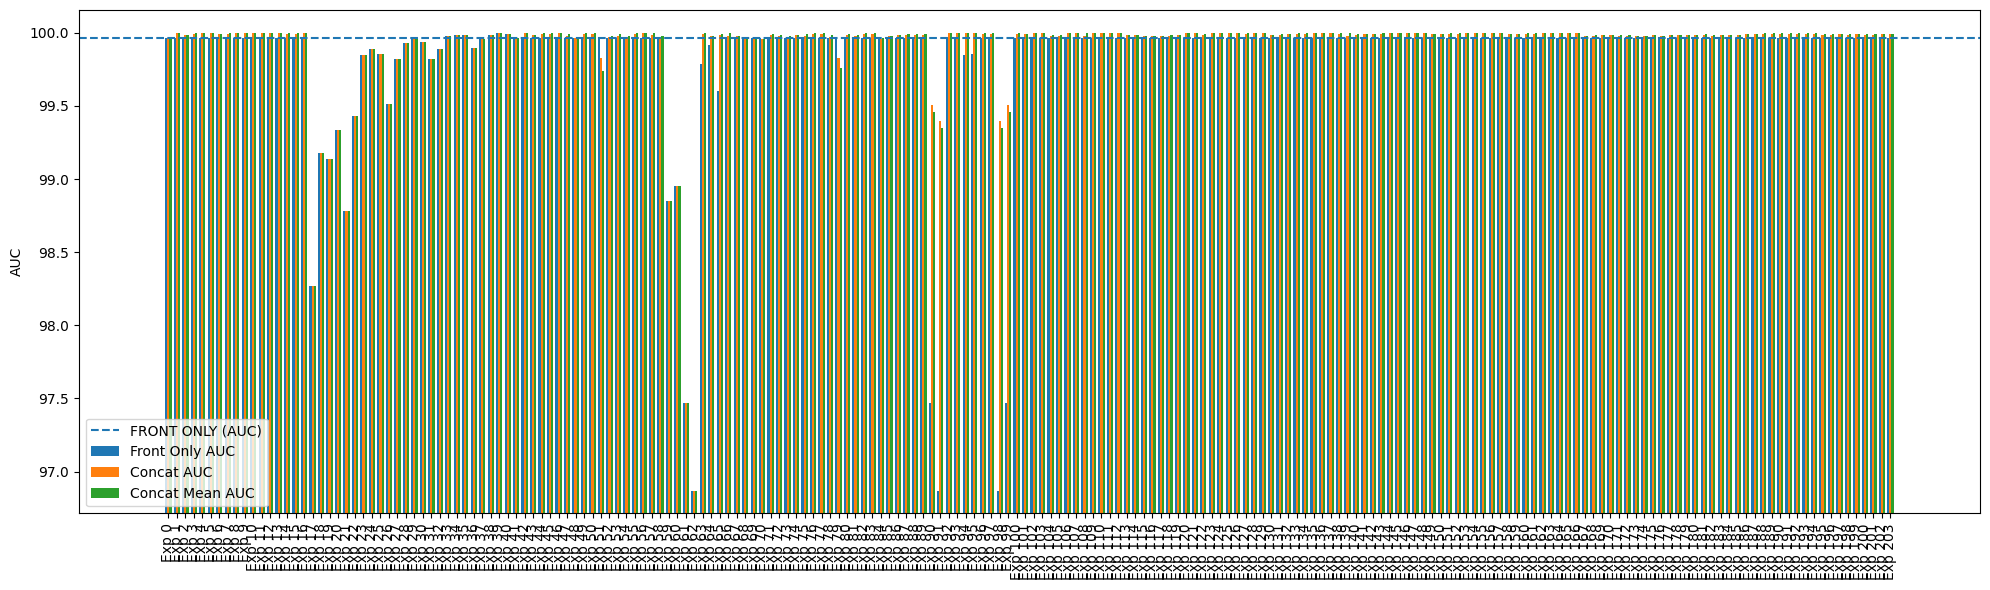

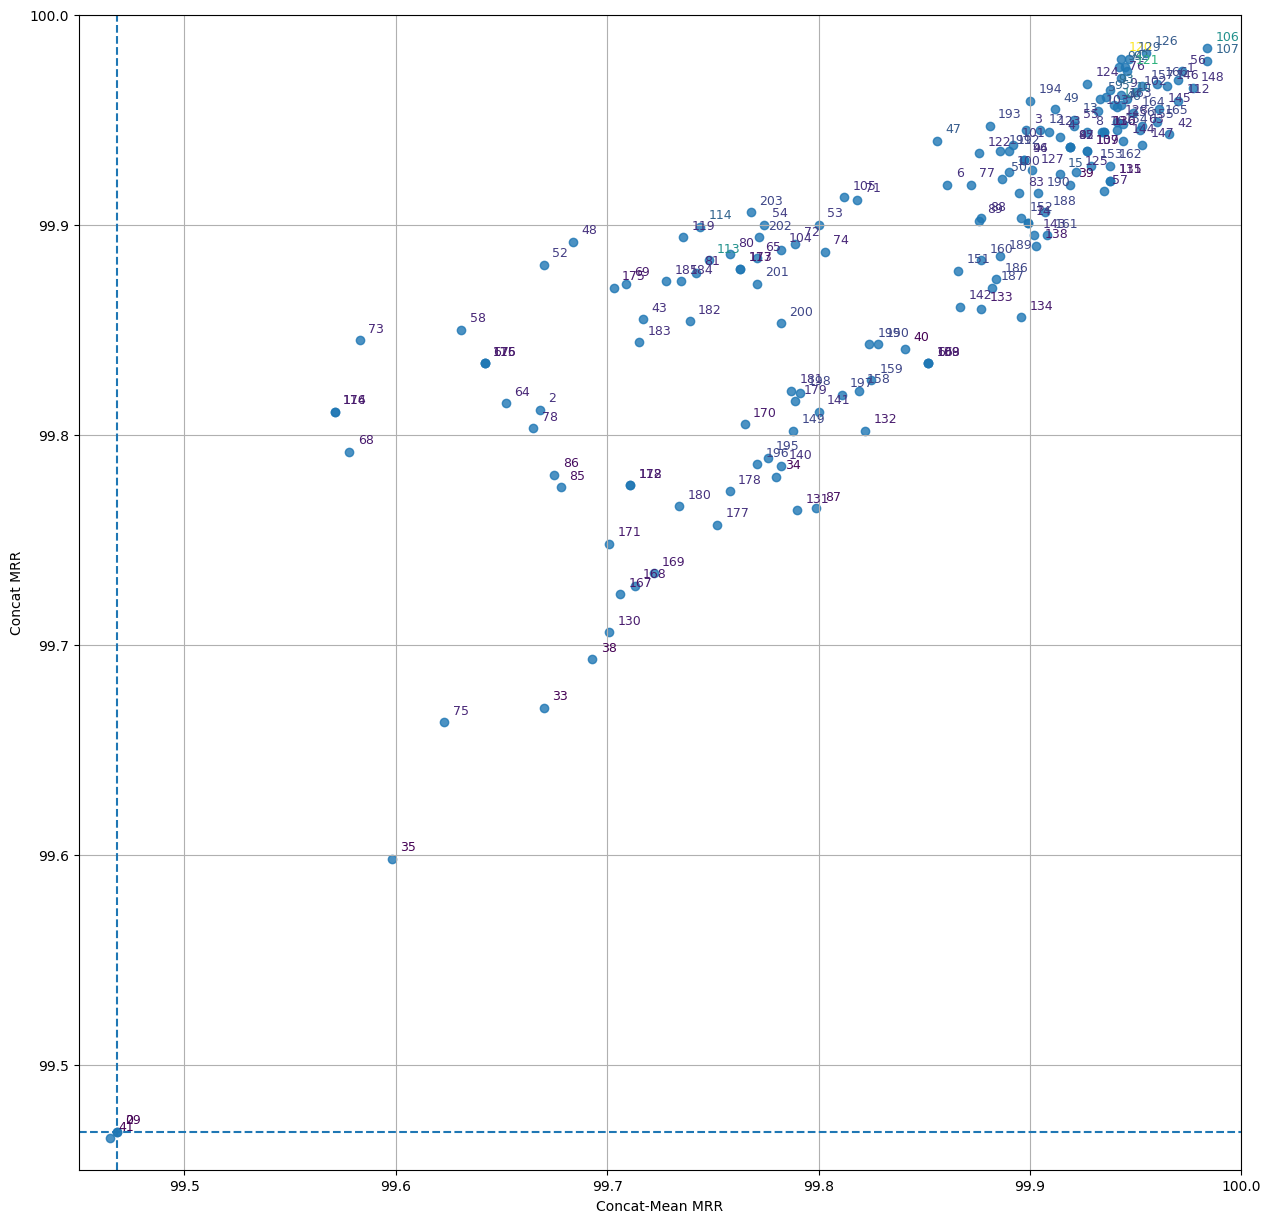

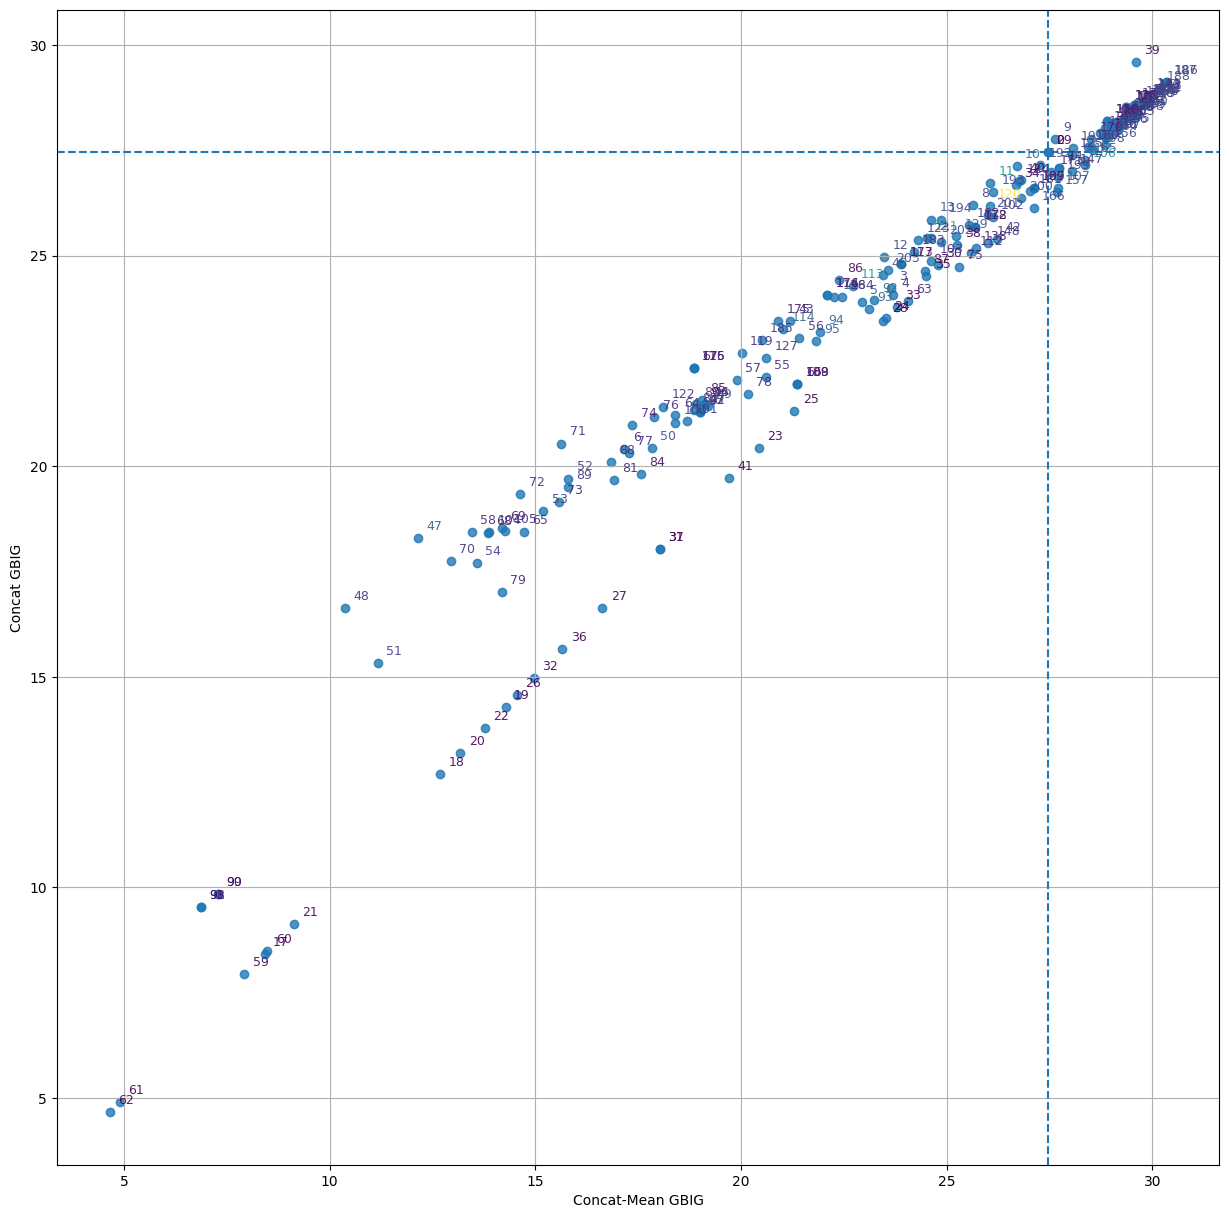

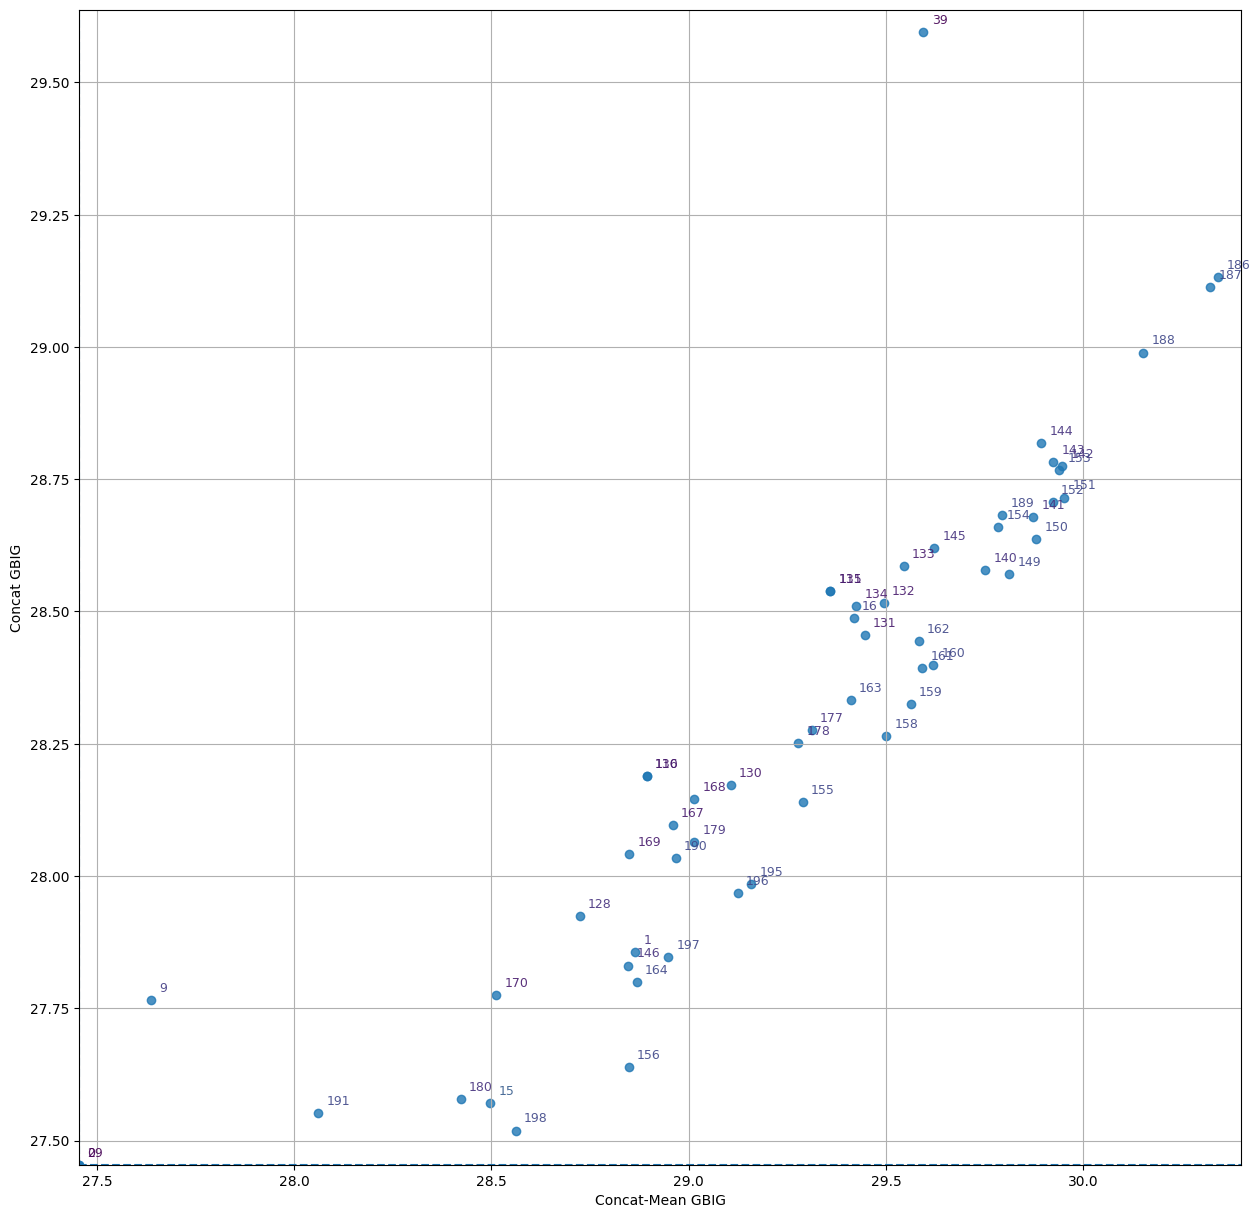

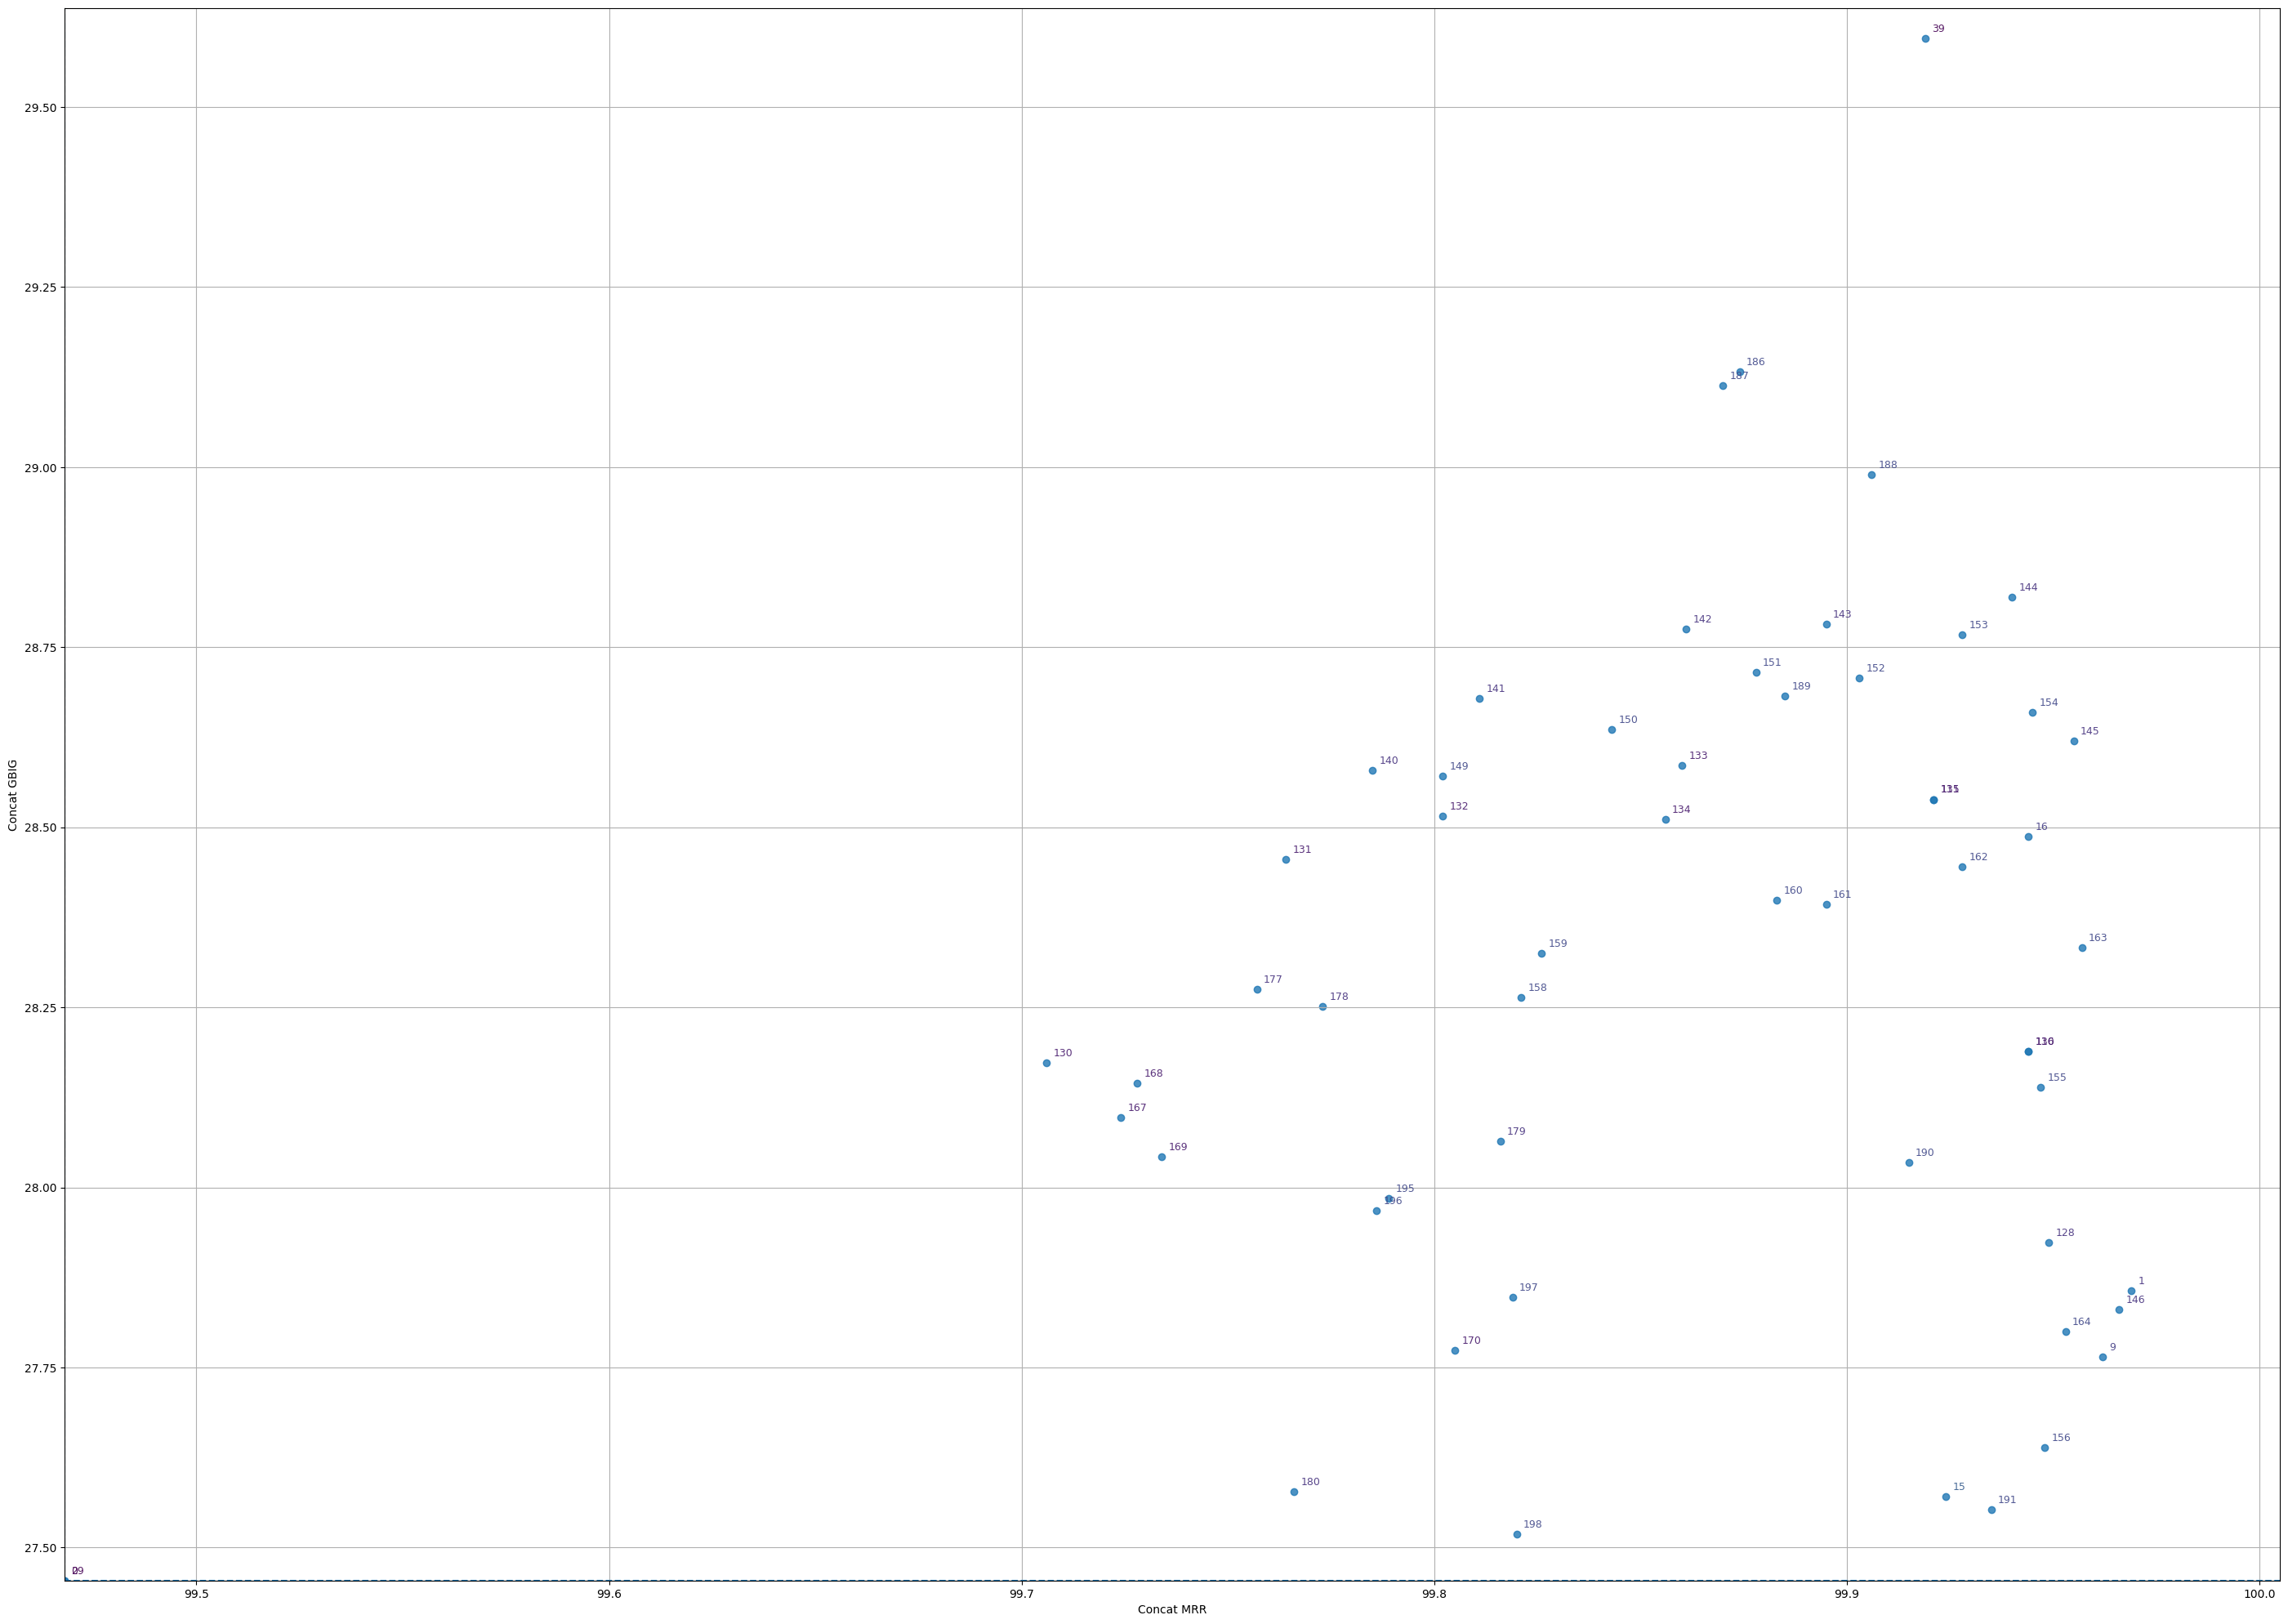

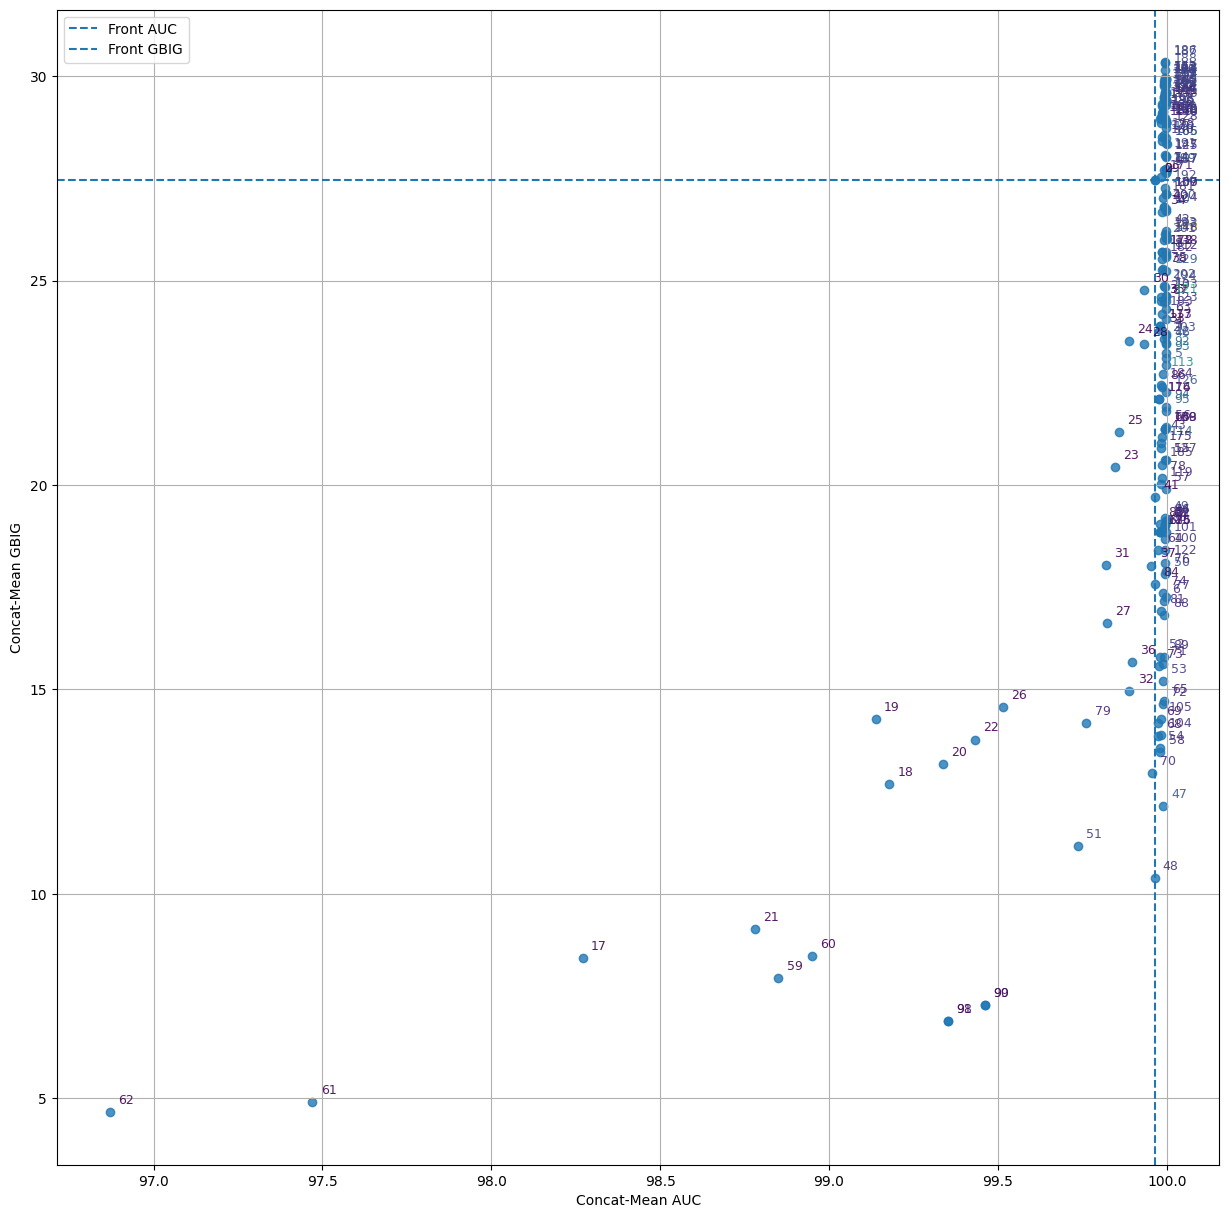

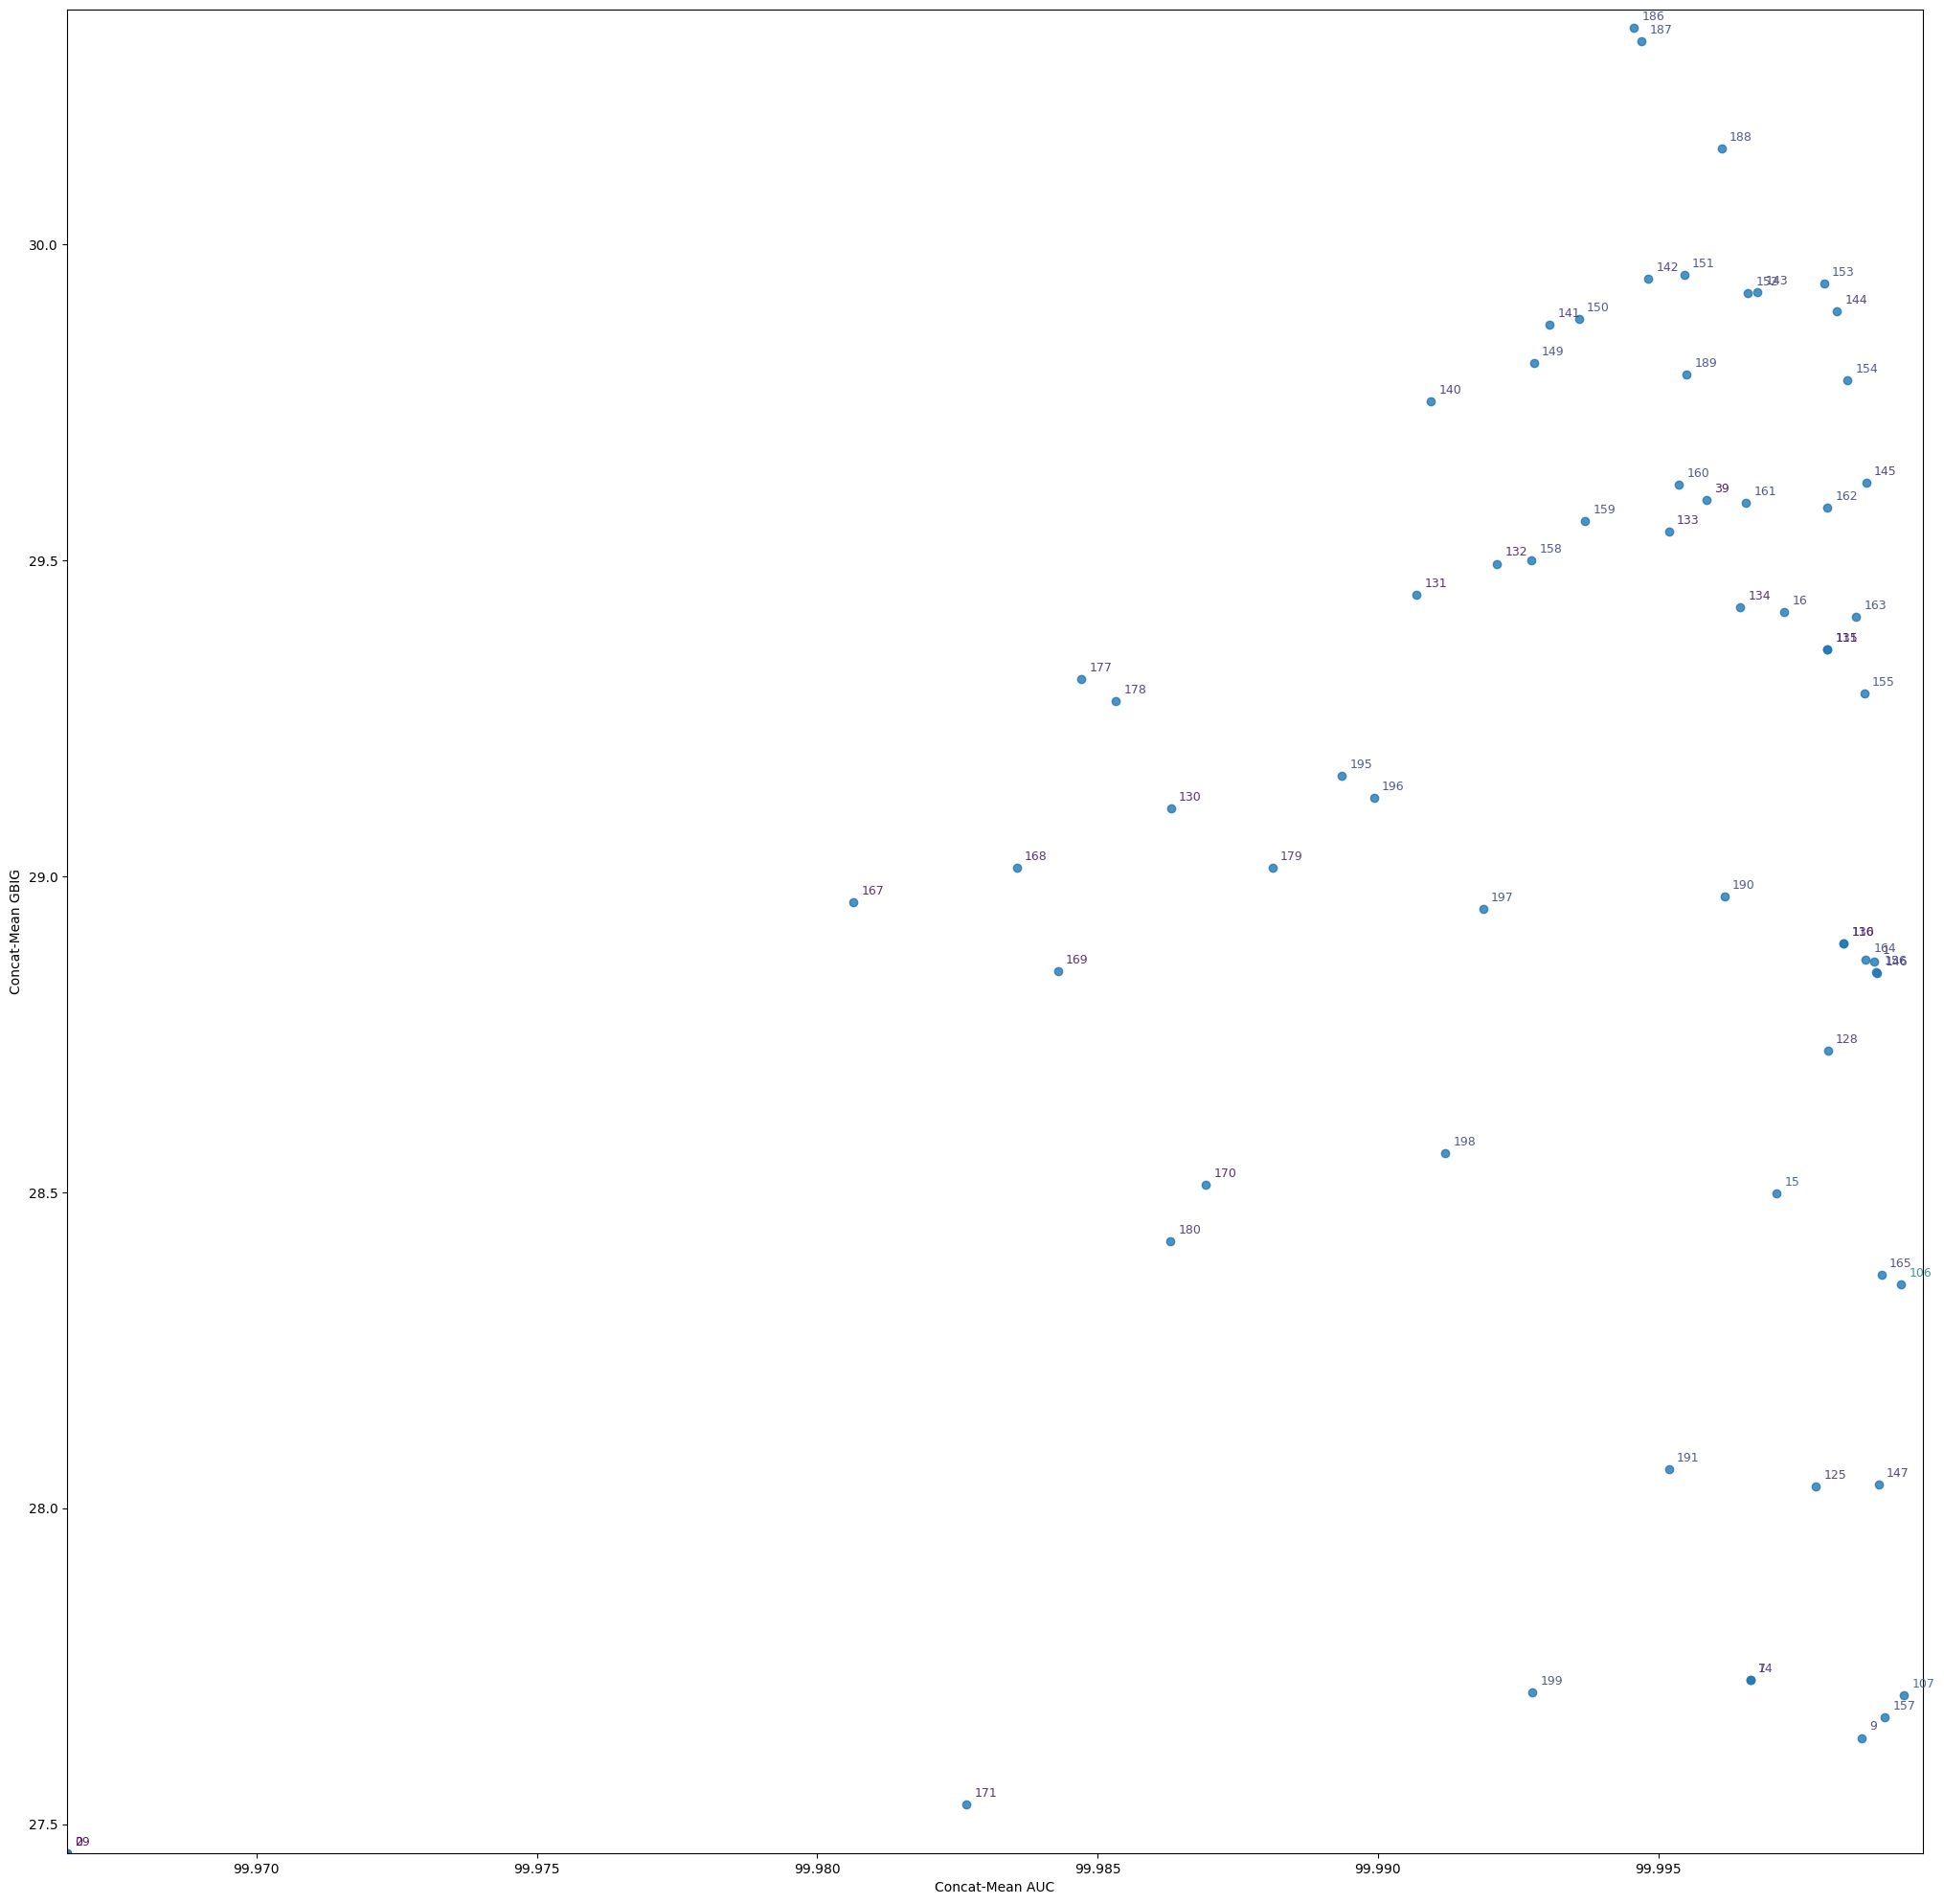

In [13]:
#process_and_plot_mrr('mass_eval_late_fusion_dataset15_glint18_extras.txt', ylim=(99.97, 100), full_concat_mrr_ref=100)
process_and_plot_mrr('mass_eval_late_fusion_dataset15_glint18_extras.txt', ylim=(99.45, 100), full_concat_mrr_ref=100)

Exp | Front MRR | Front GBIG | Front AUC | Concat MRR | Concat GBIG | Concat AUC | Concat-Mean MRR | Concat-Mean GBIG | Concat-Mean AUC | Dataset
------------------------------------------------------------------------------------------------------------------------
Exp 00 | 99.4680 | 27.454 | 99.966624 | 99.7280 | 28.145 | 99.981434 | 99.7130 | 29.013 | 99.983557 | ['0_-3', '0_0', '0_3']
Exp 01 | 99.4680 | 27.454 | 99.966624 | 99.7340 | 28.042 | 99.981973 | 99.7220 | 28.850 | 99.984291 | ['0_-5', '0_0', '0_5']
Exp 02 | 99.4680 | 27.454 | 99.966624 | 99.8050 | 27.774 | 99.984615 | 99.7650 | 28.512 | 99.986926 | ['0_-7', '0_0', '0_7']
Exp 03 | 99.4680 | 27.454 | 99.966624 | 99.7480 | 26.982 | 99.978653 | 99.7010 | 27.531 | 99.982661 | ['0_-10', '0_0', '0_10']
Exp 04 | 99.4680 | 27.454 | 99.966624 | 99.7760 | 25.673 | 99.981363 | 99.7110 | 25.699 | 99.985280 | ['0_-15', '0_0', '0_15']
Exp 05 | 99.4680 | 27.454 | 99.966624 | 99.8790 | 24.801 | 99.977820 | 99.7630 | 23.898 | 99.980354 | ['

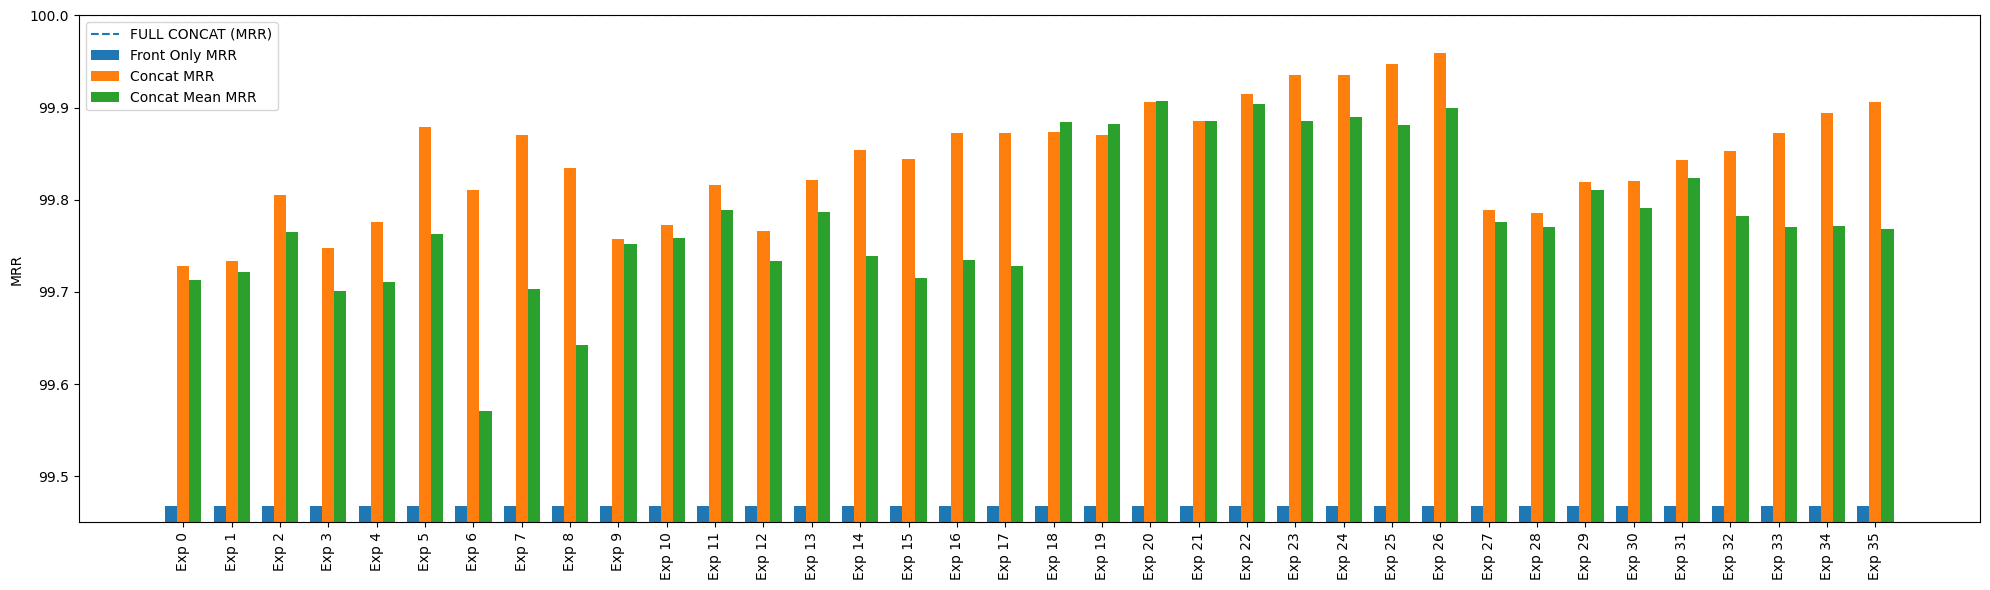

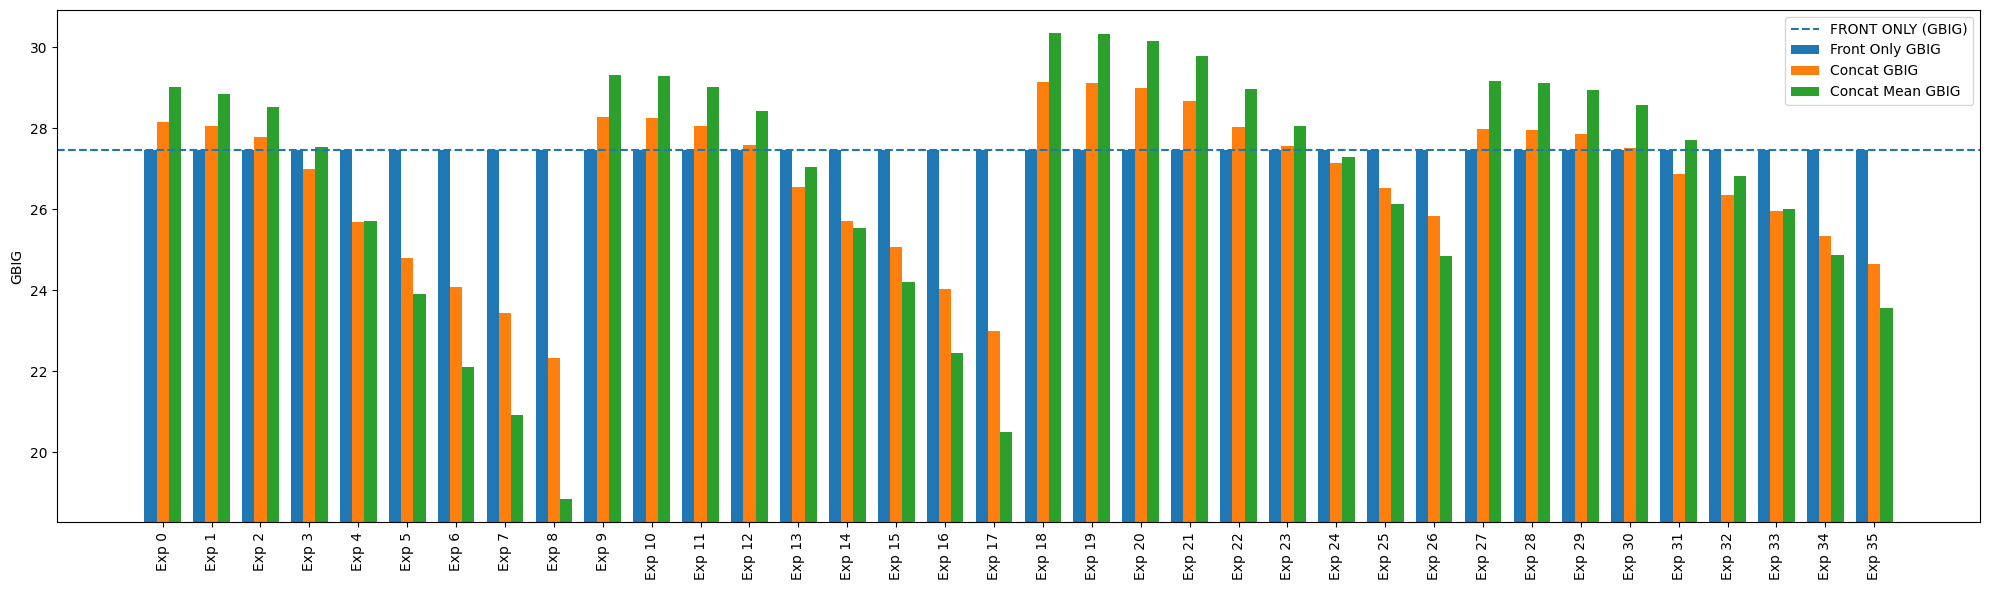

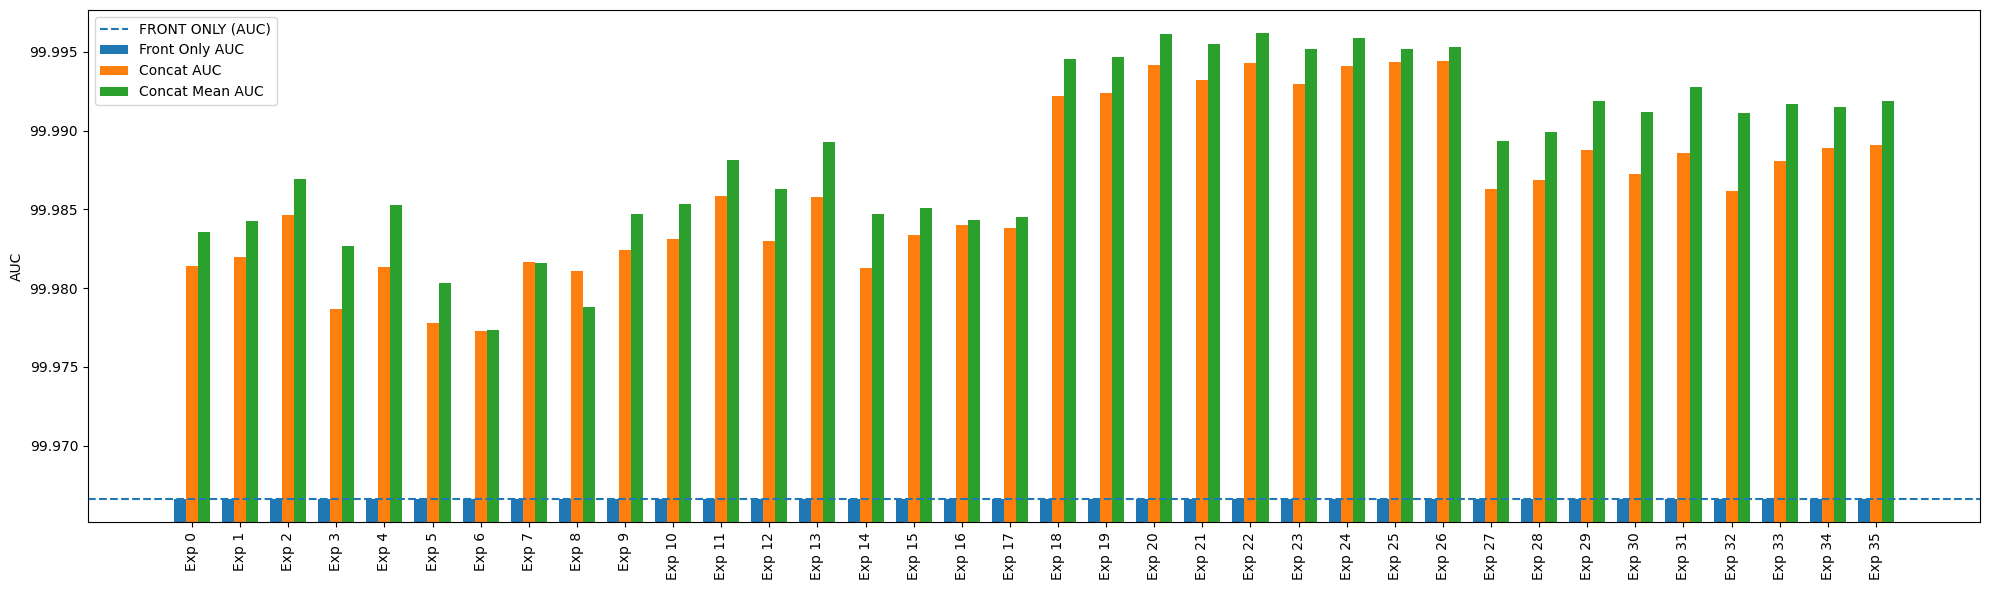

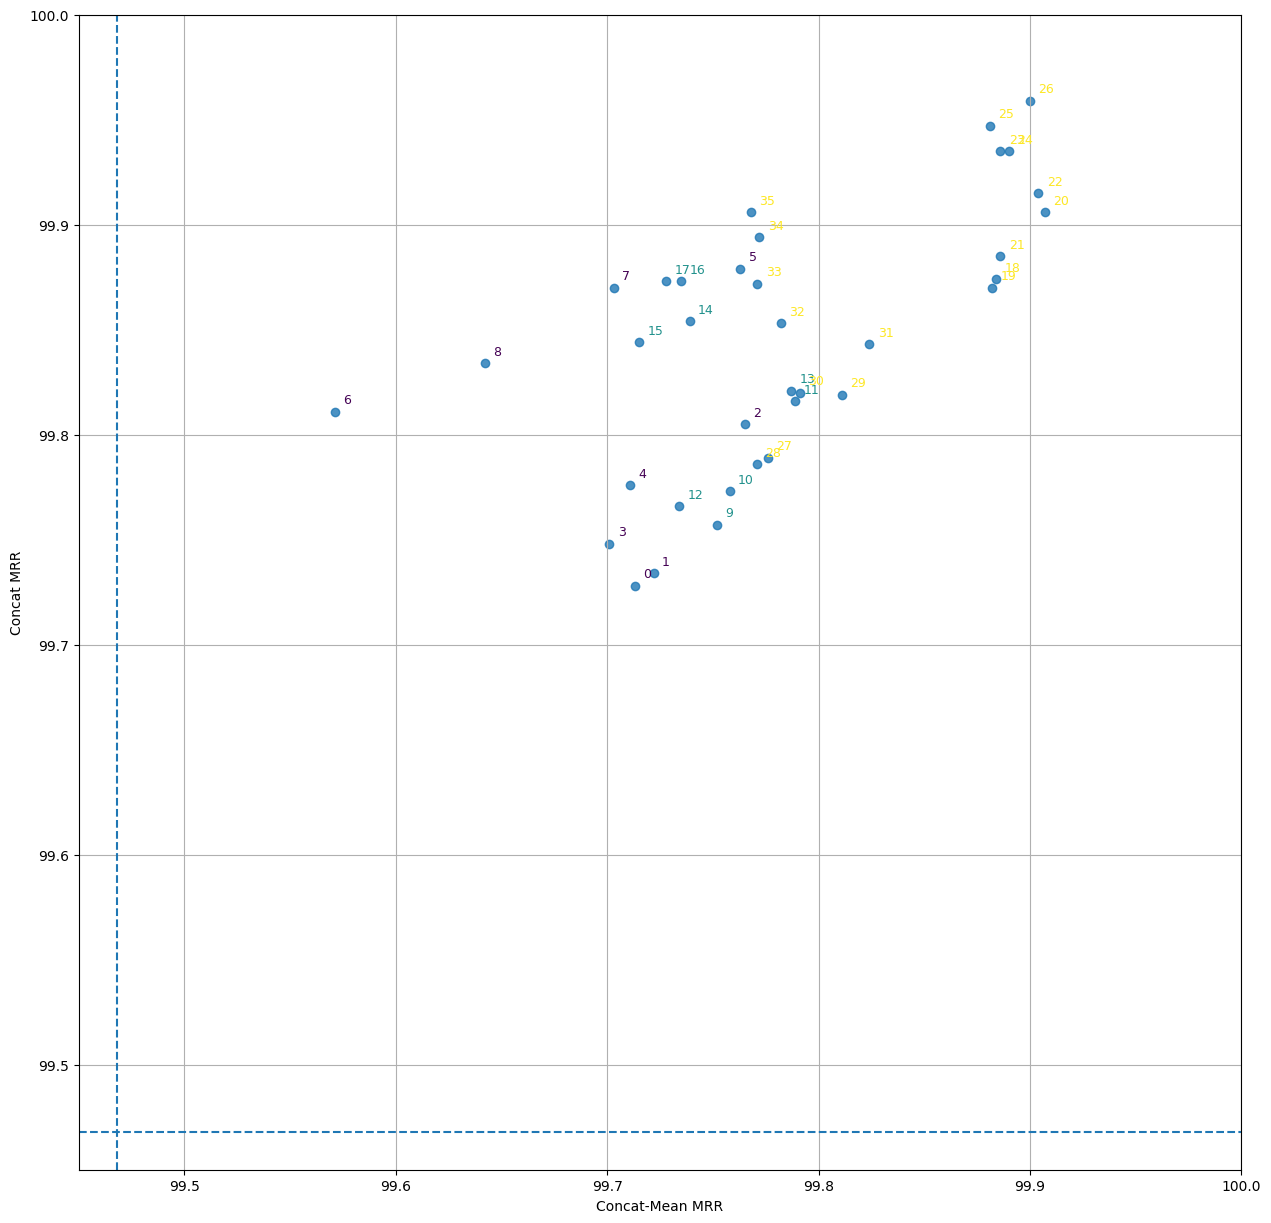

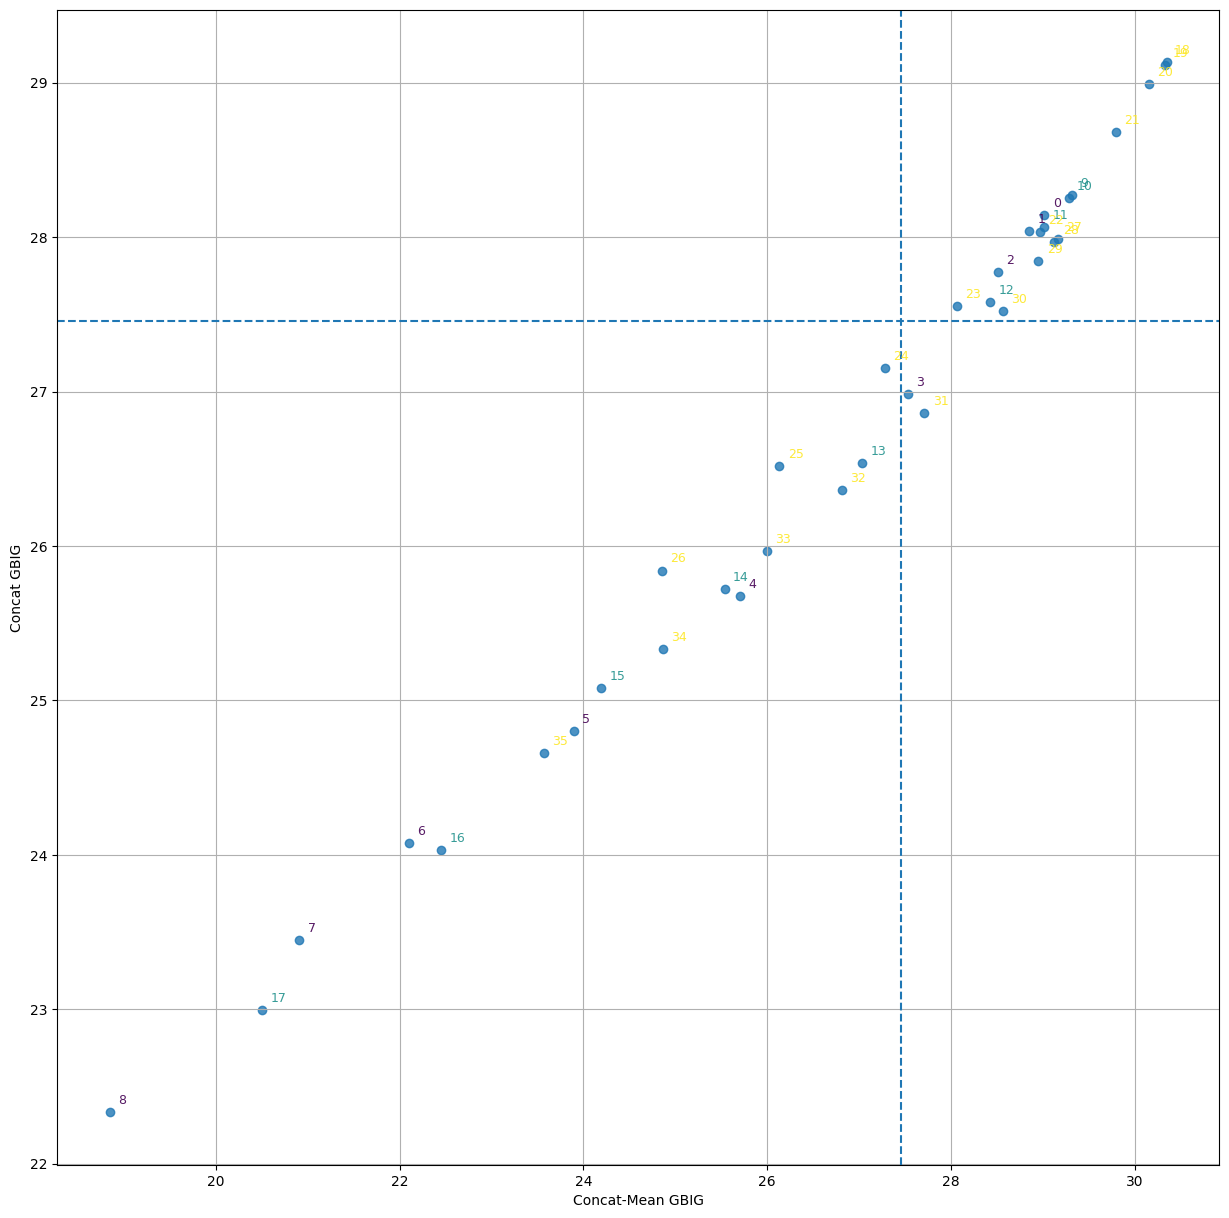

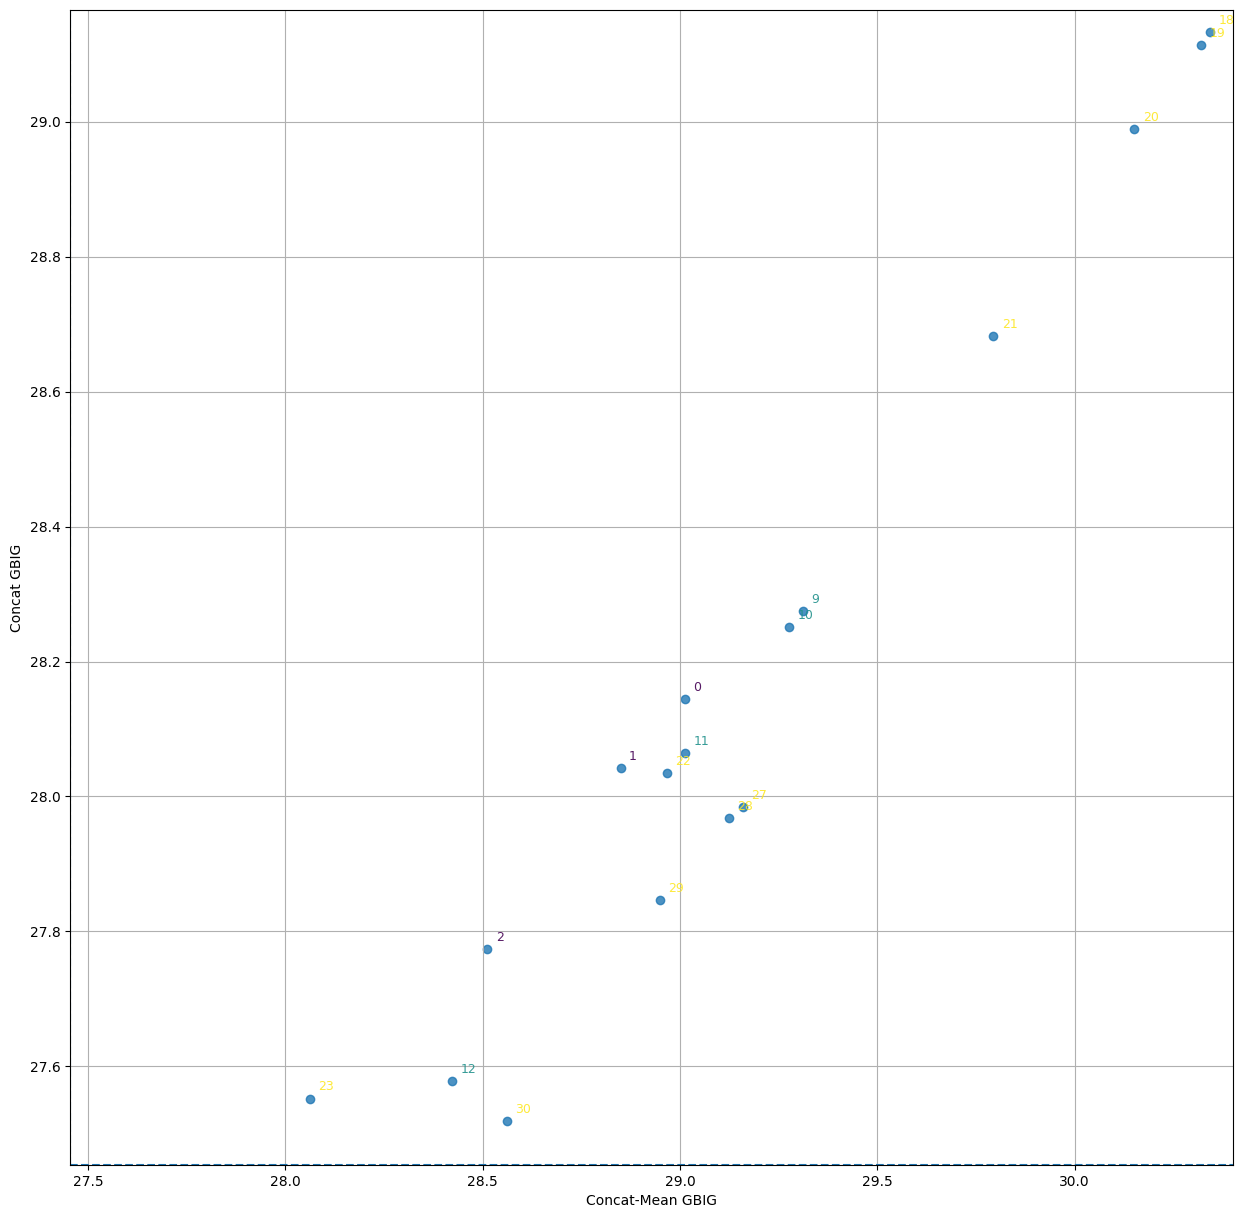

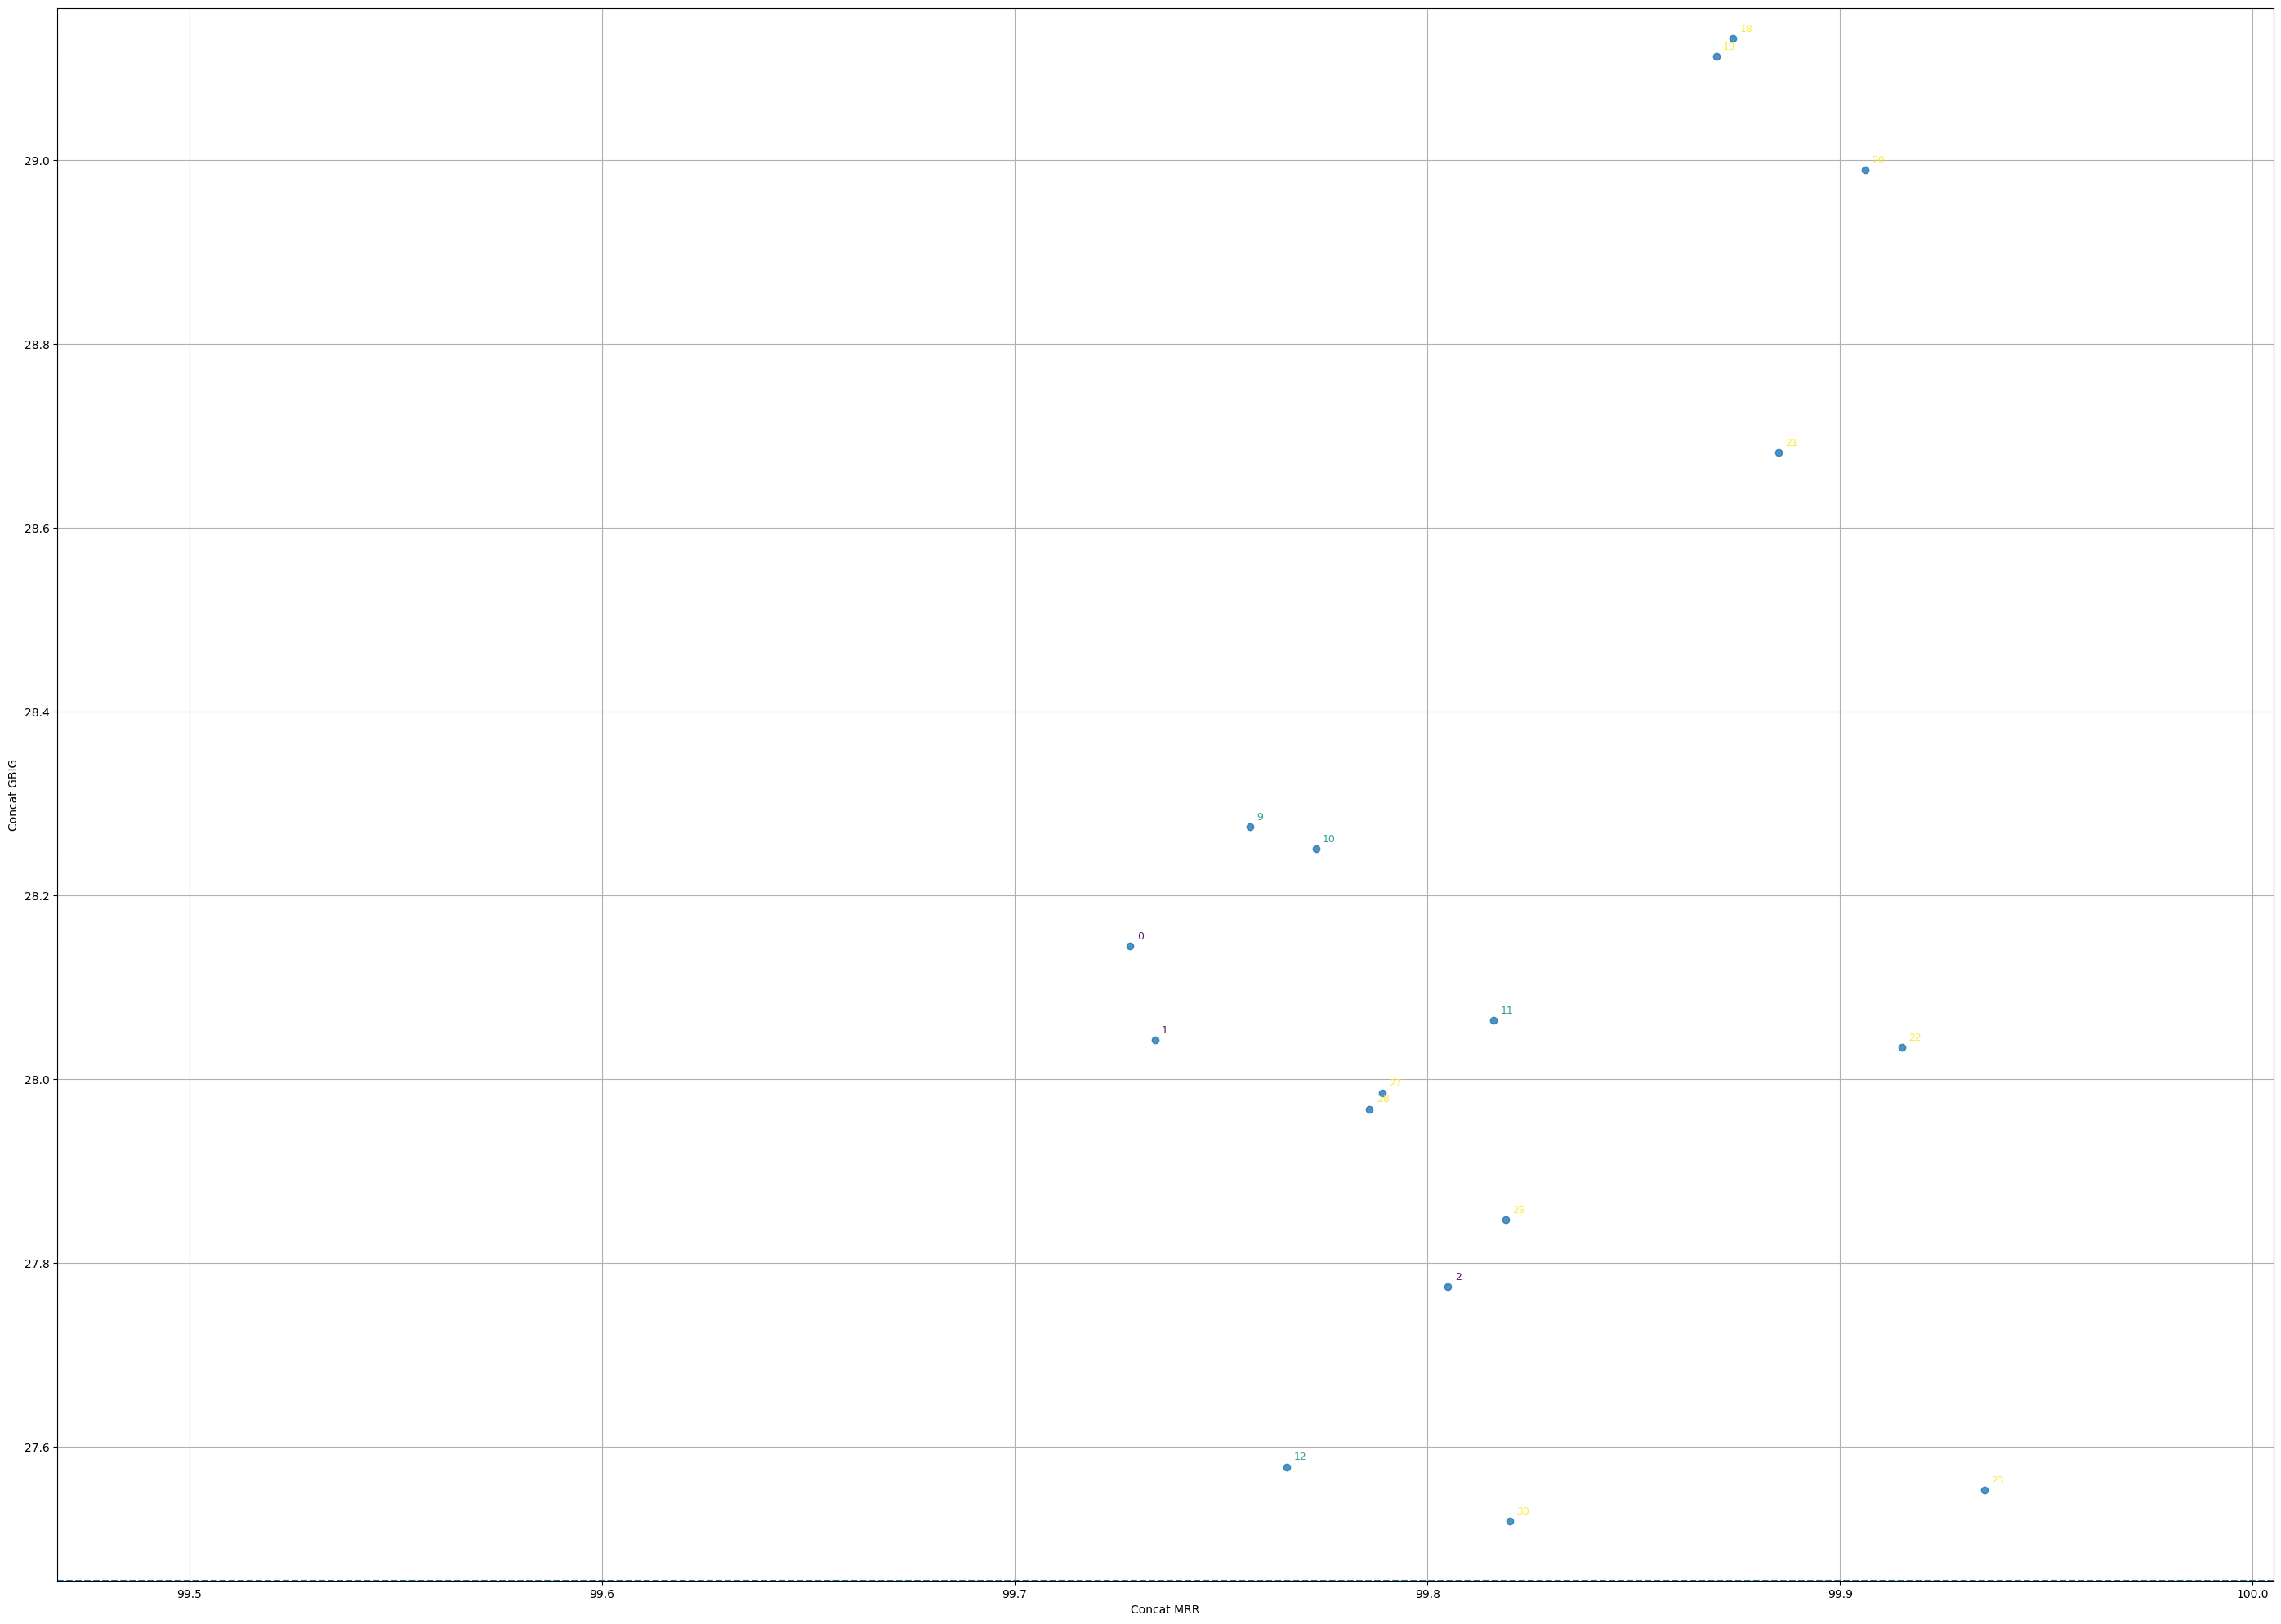

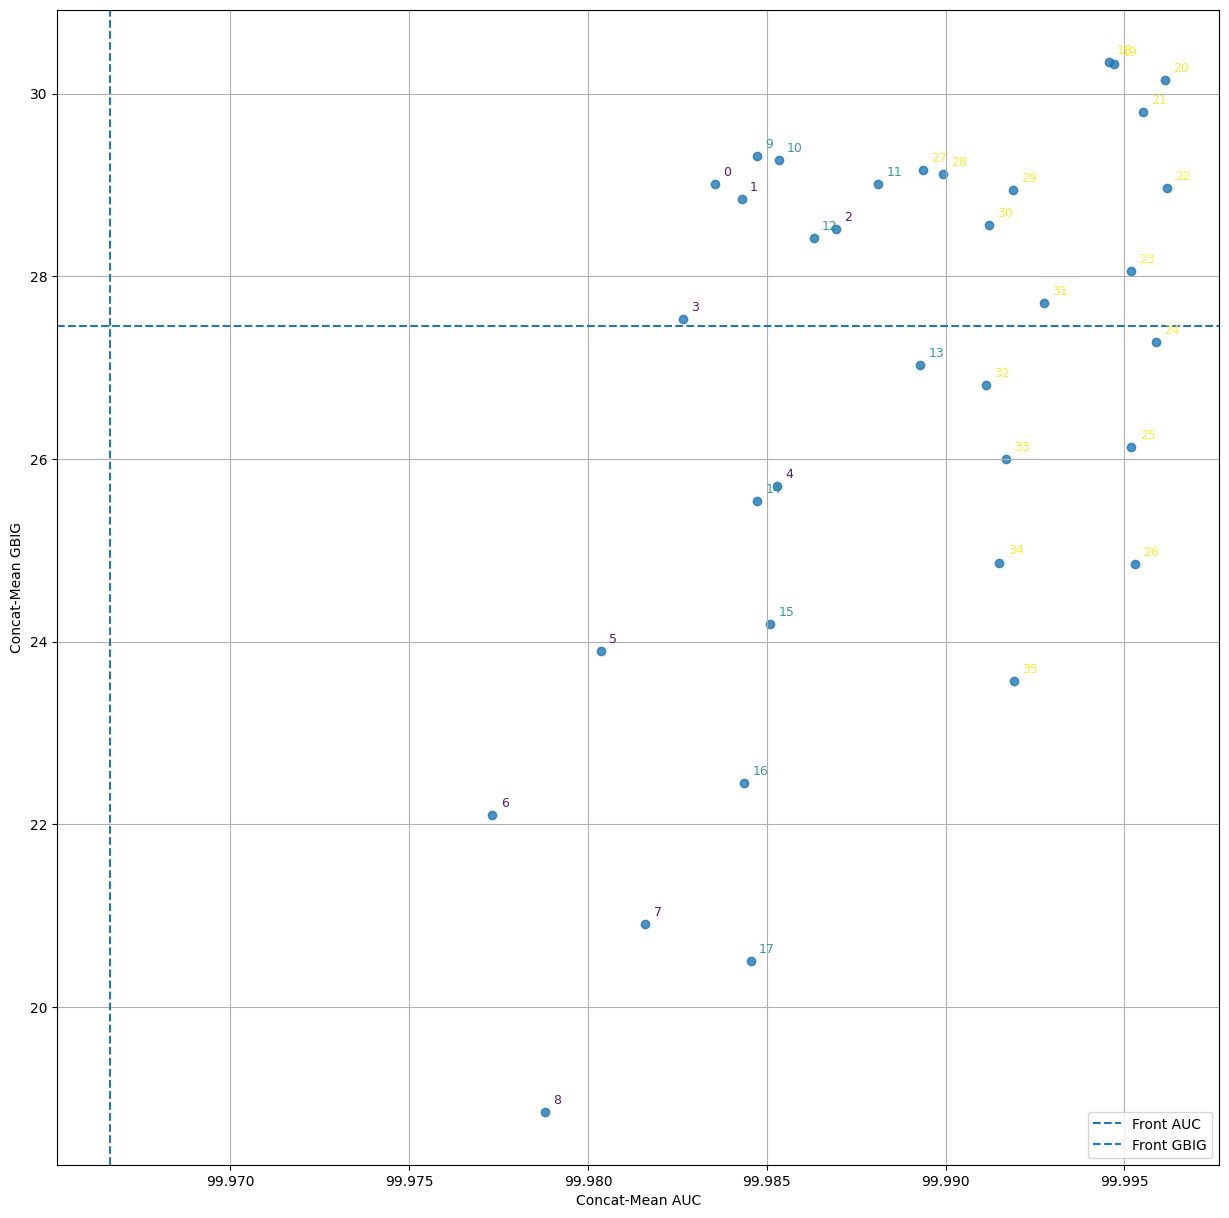

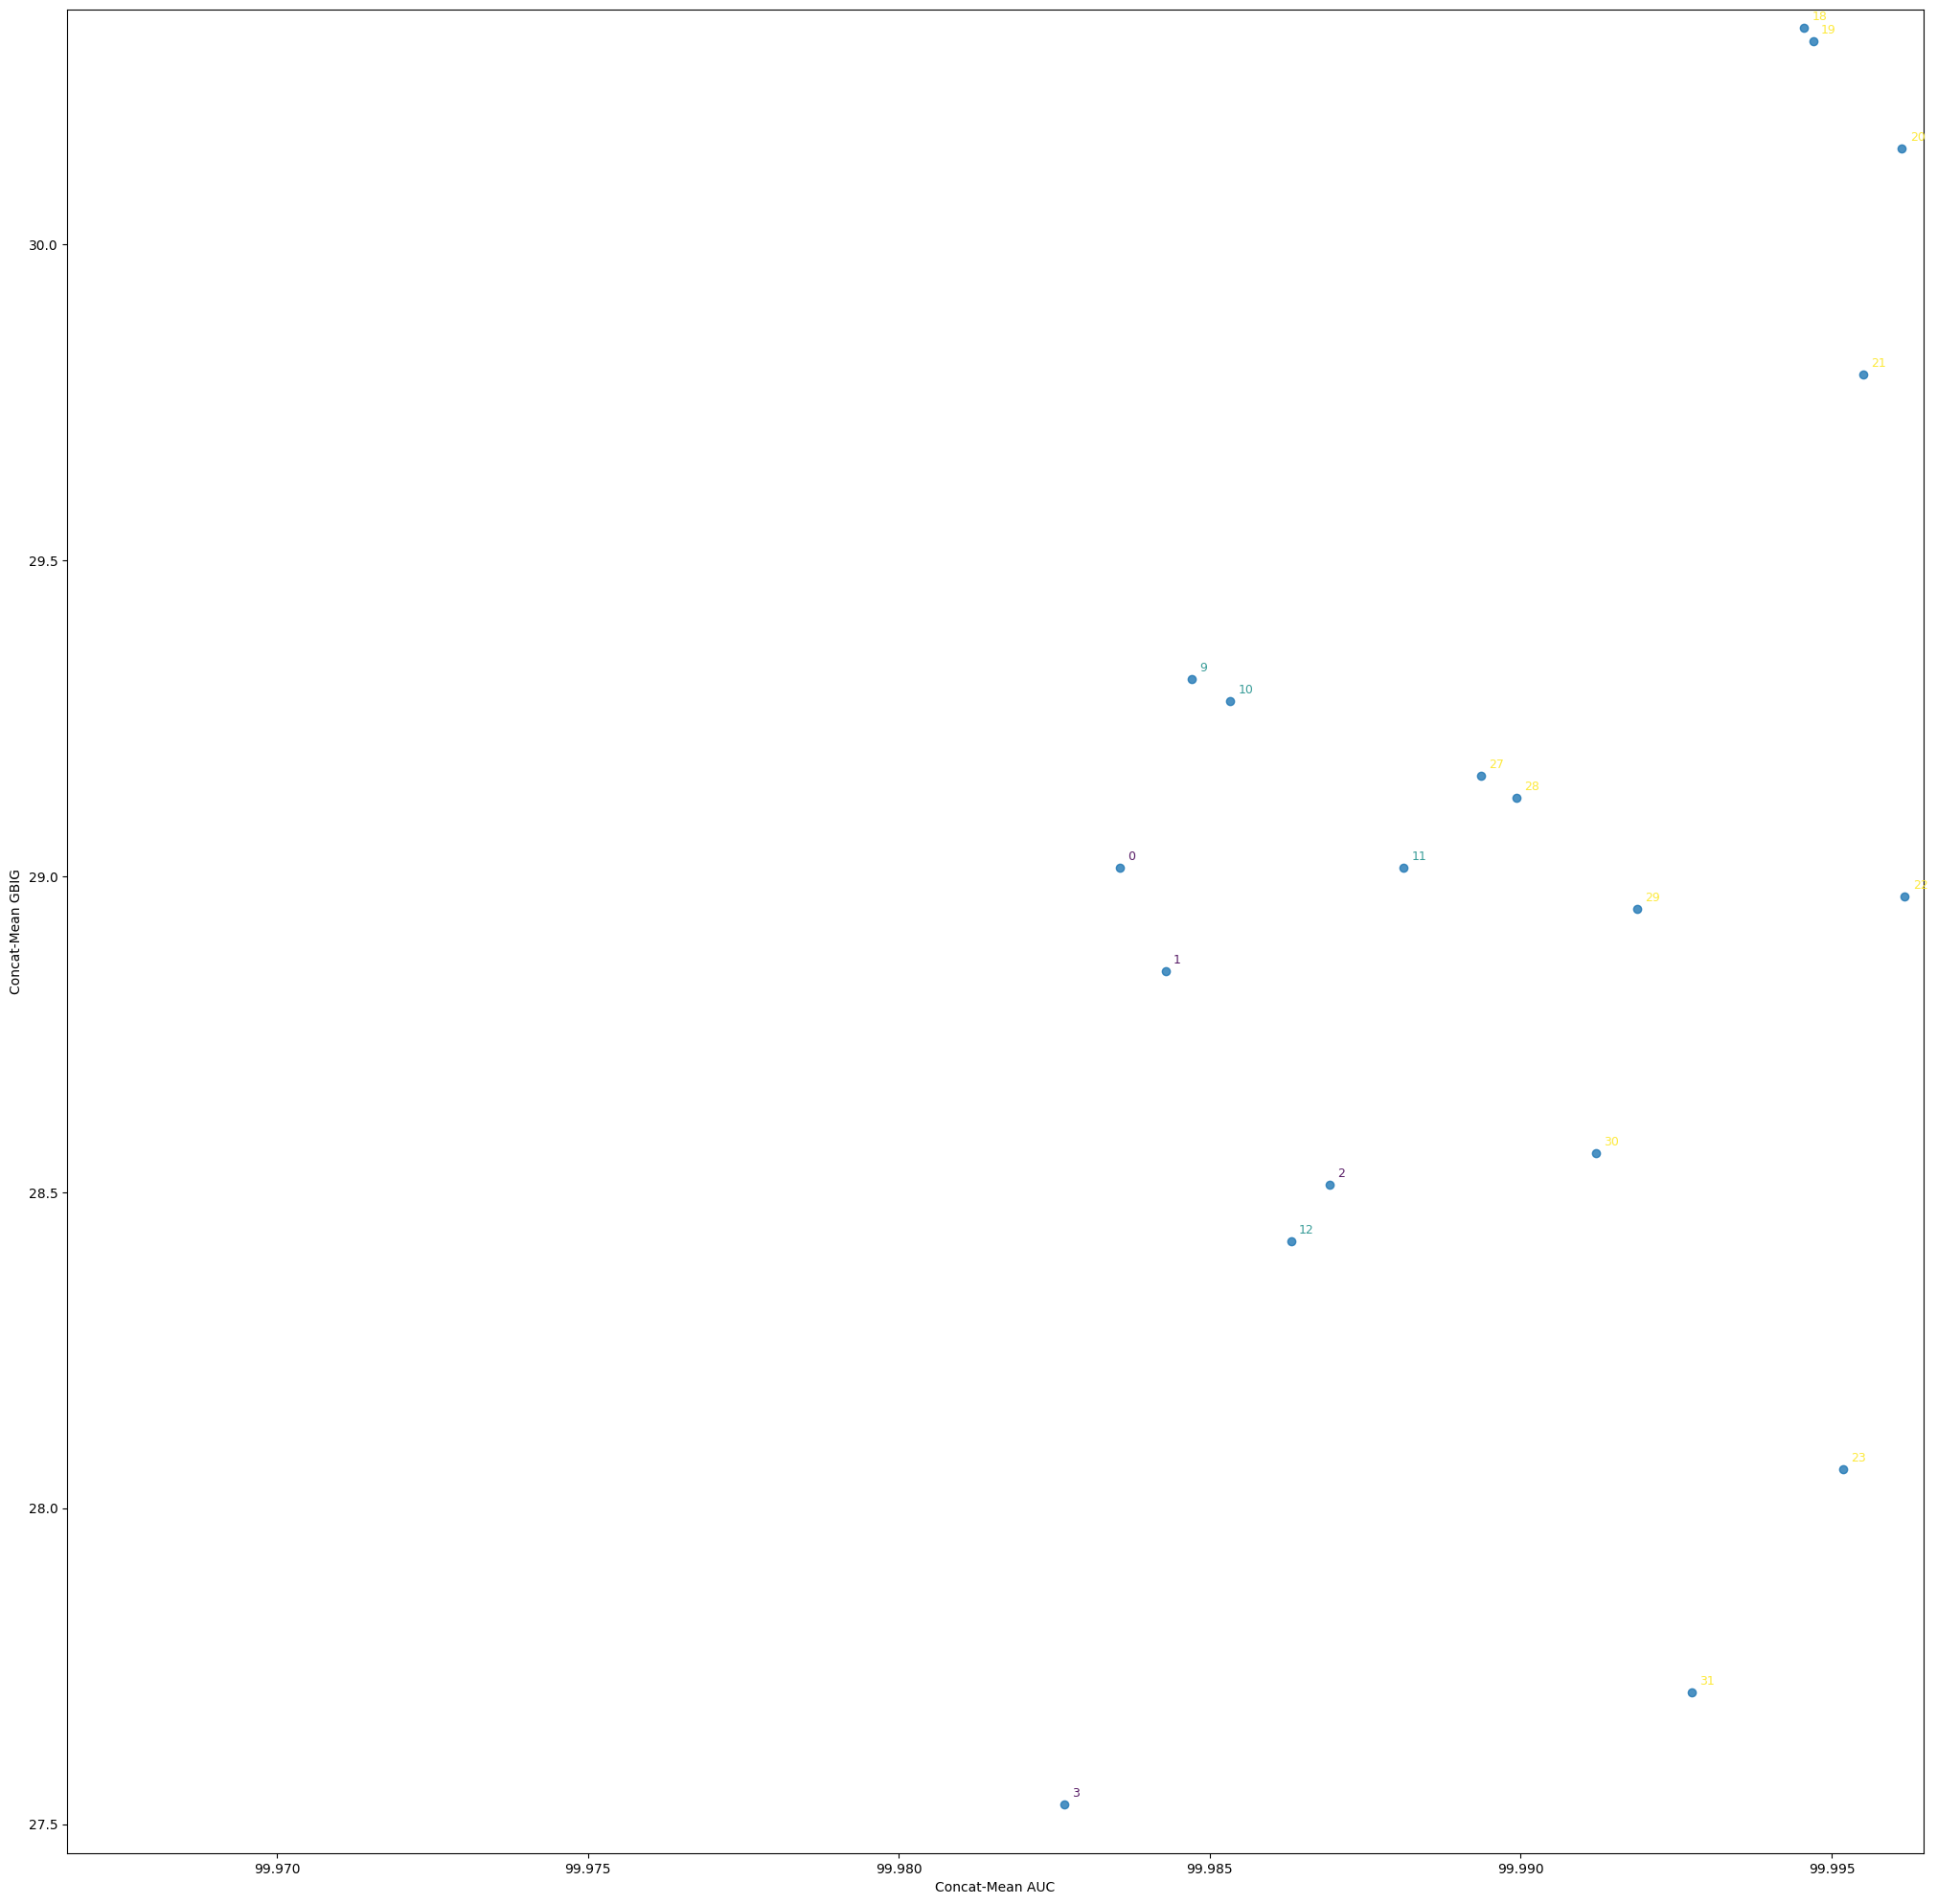

In [18]:

process_and_plot_mrr('mass_eval_late_fusion_dataset15_glint18_extras-LAST.txt', ylim=(99.45, 100), full_concat_mrr_ref=100, last_n=36)

Exp | Front MRR | Front GBIG | Front AUC | Concat MRR | Concat GBIG | Concat AUC | Concat-Mean MRR | Concat-Mean GBIG | Concat-Mean AUC | Dataset
------------------------------------------------------------------------------------------------------------------------
Exp 00 | 99.4680 | 27.454 | 99.966624 | 99.7240 | 28.097 | 99.978724 | 99.7060 | 28.959 | 99.980650 | ['0_-1', '0_0', '0_1']
Exp 01 | 99.4680 | 27.454 | 99.966624 | 99.7280 | 28.145 | 99.981434 | 99.7130 | 29.013 | 99.983557 | ['0_-3', '0_0', '0_3']
Exp 02 | 99.4680 | 27.454 | 99.966624 | 99.7340 | 28.042 | 99.981973 | 99.7220 | 28.850 | 99.984291 | ['0_-5', '0_0', '0_5']
Exp 03 | 99.4680 | 27.454 | 99.966624 | 99.8050 | 27.774 | 99.984615 | 99.7650 | 28.512 | 99.986926 | ['0_-7', '0_0', '0_7']
Exp 04 | 99.4680 | 27.454 | 99.966624 | 99.7480 | 26.982 | 99.978653 | 99.7010 | 27.531 | 99.982661 | ['0_-10', '0_0', '0_10']
Exp 05 | 99.4680 | 27.454 | 99.966624 | 99.7760 | 25.673 | 99.981363 | 99.7110 | 25.699 | 99.985280 | ['0_

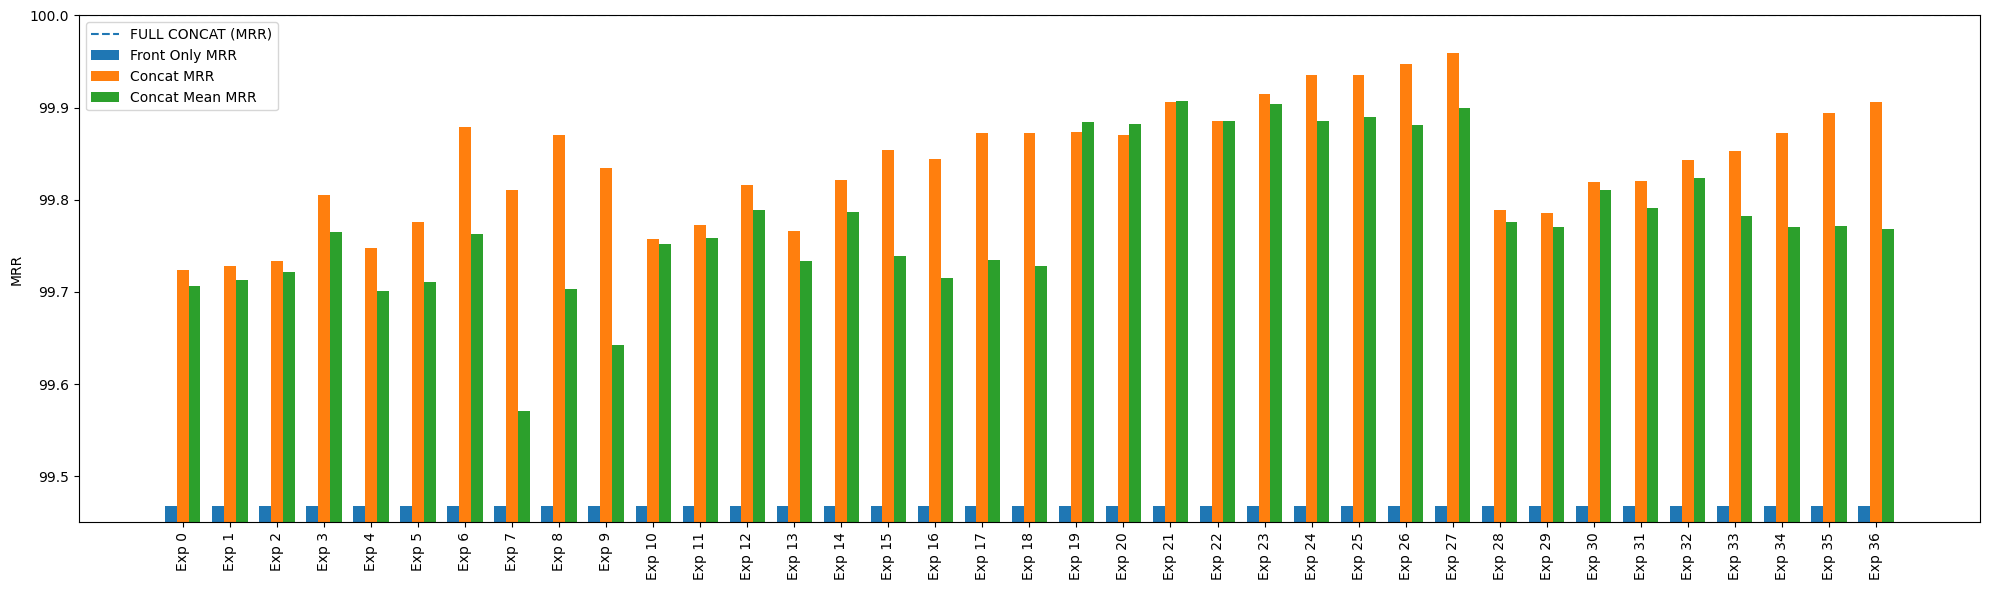

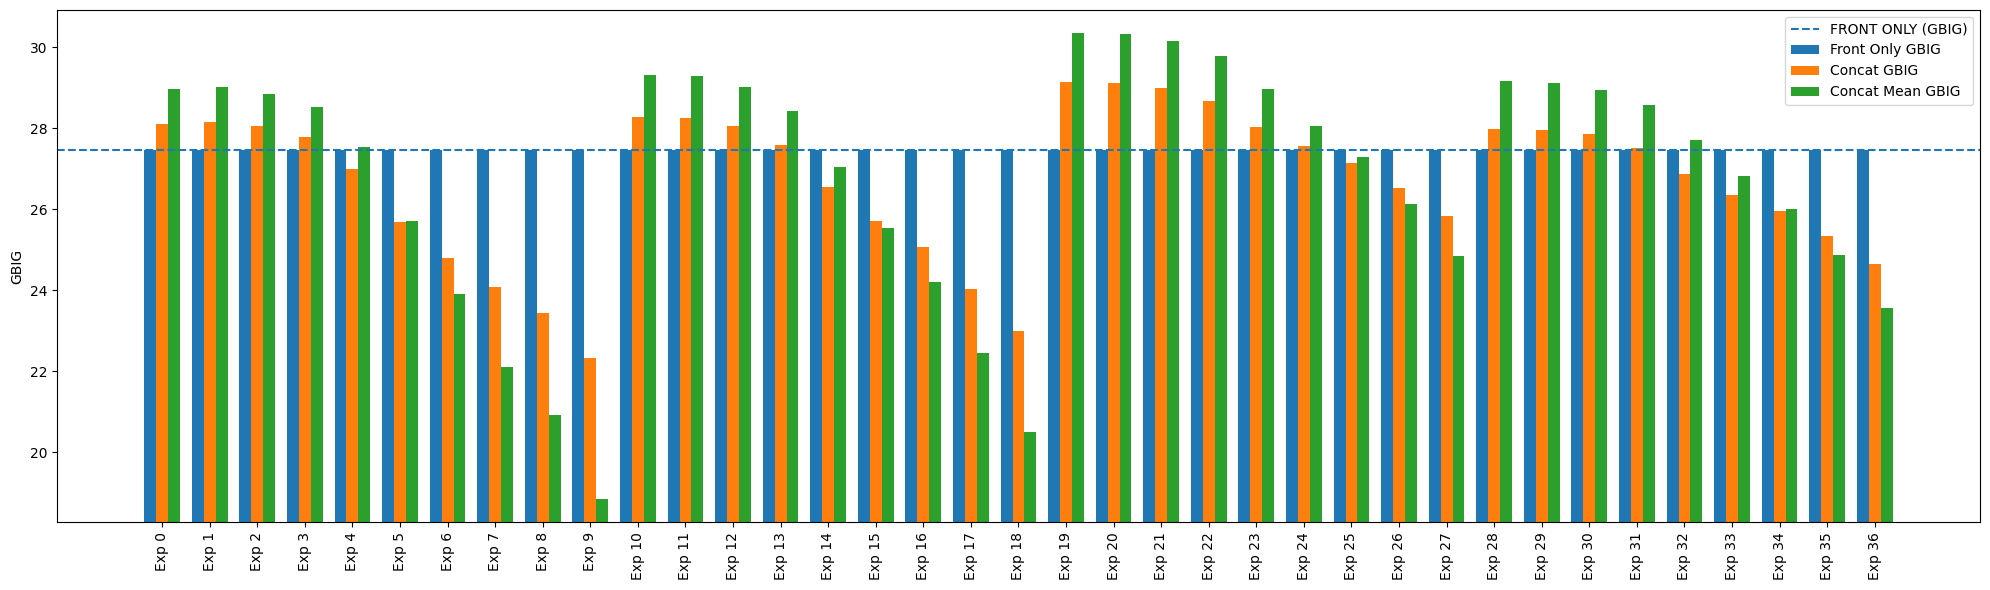

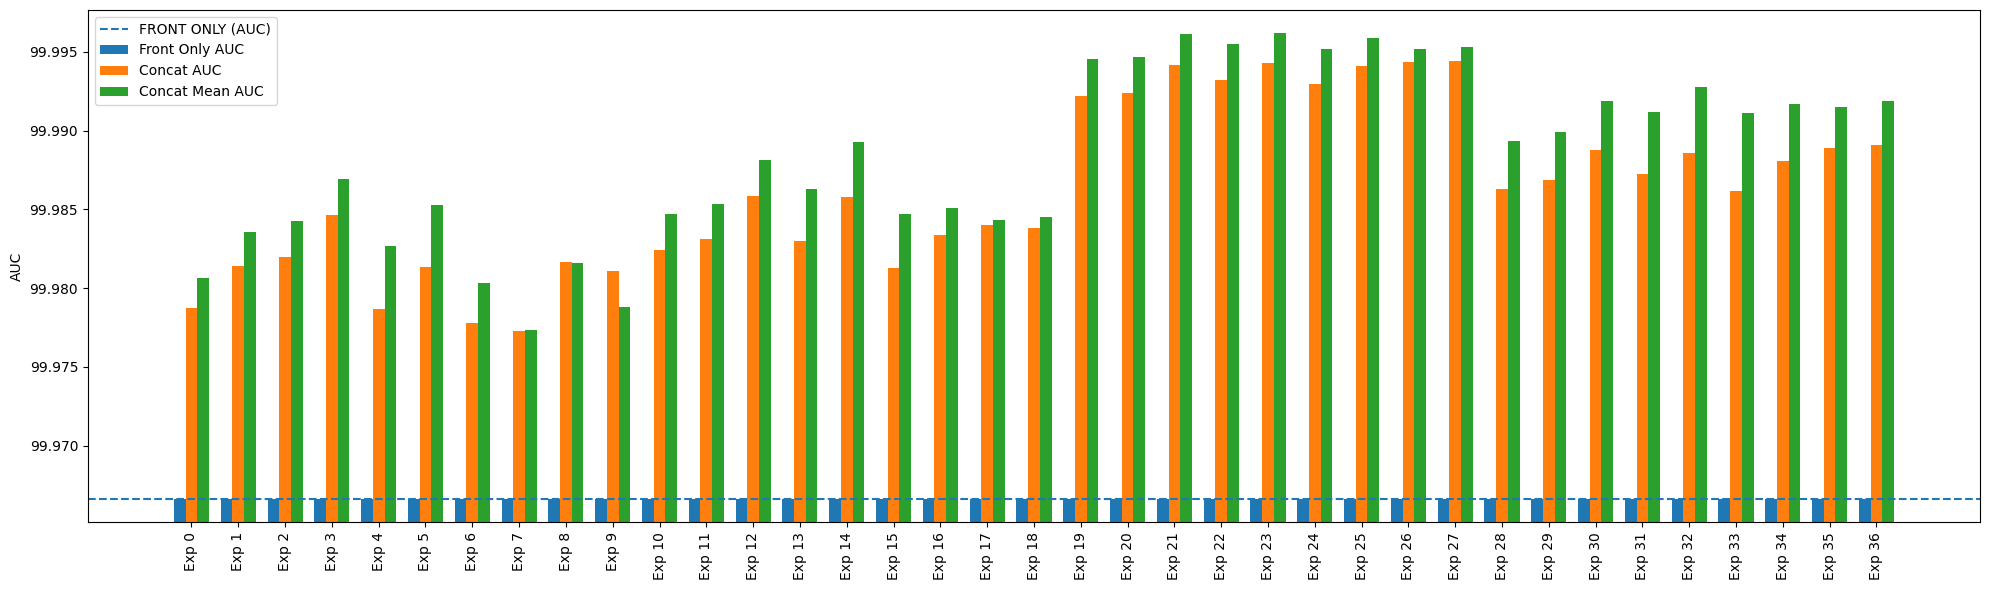

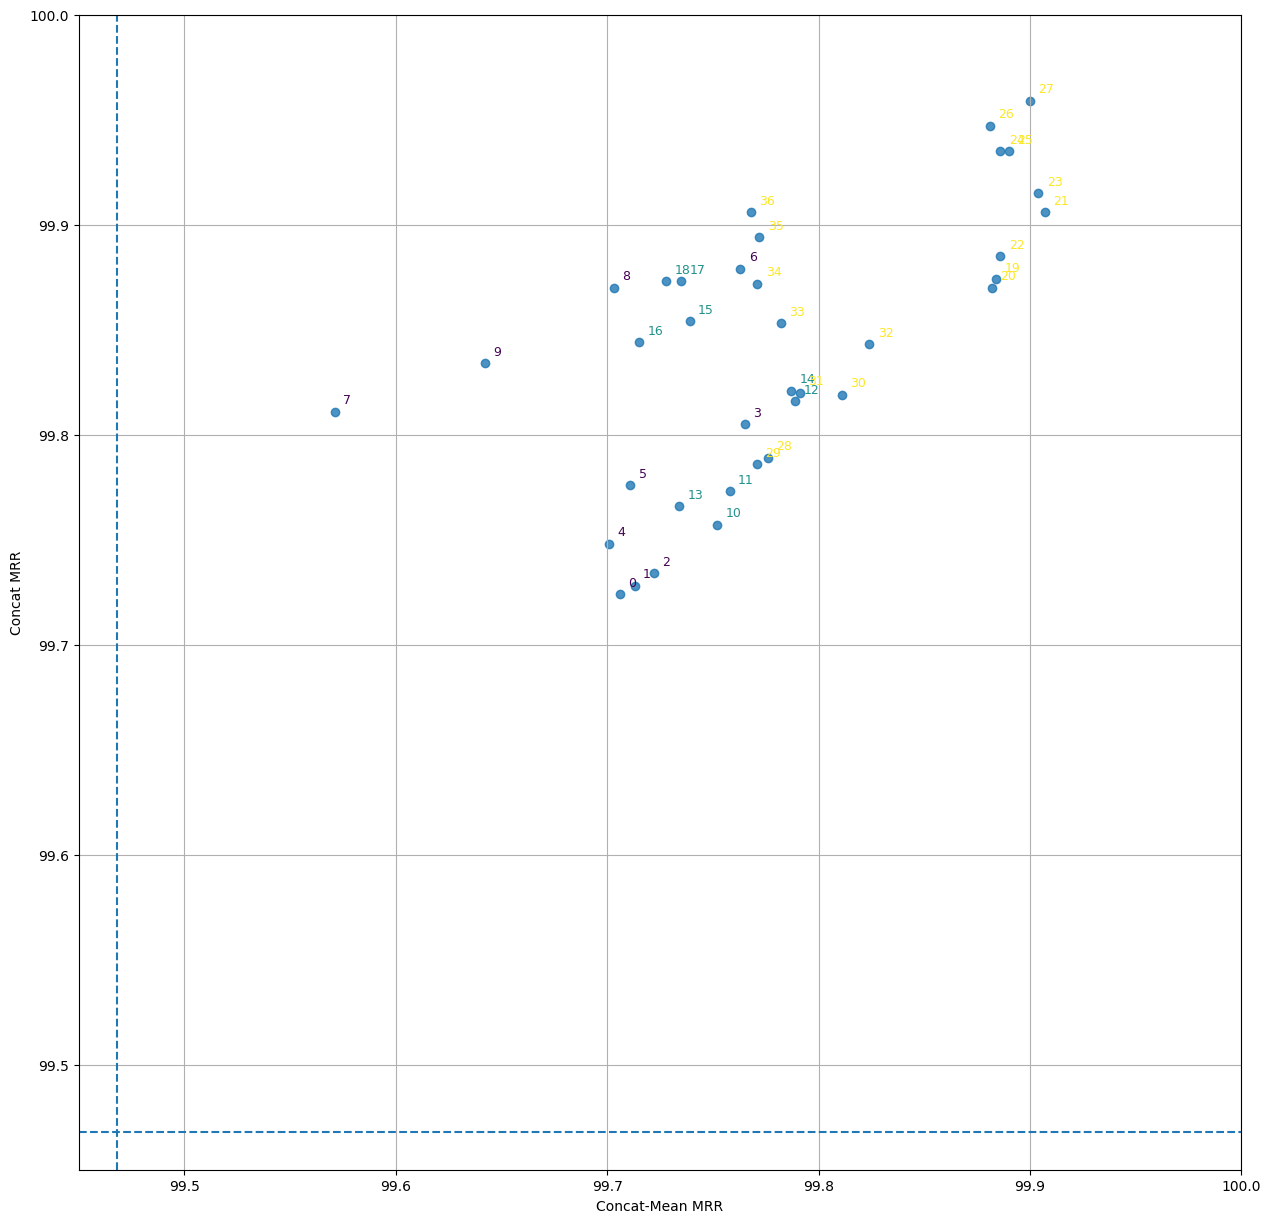

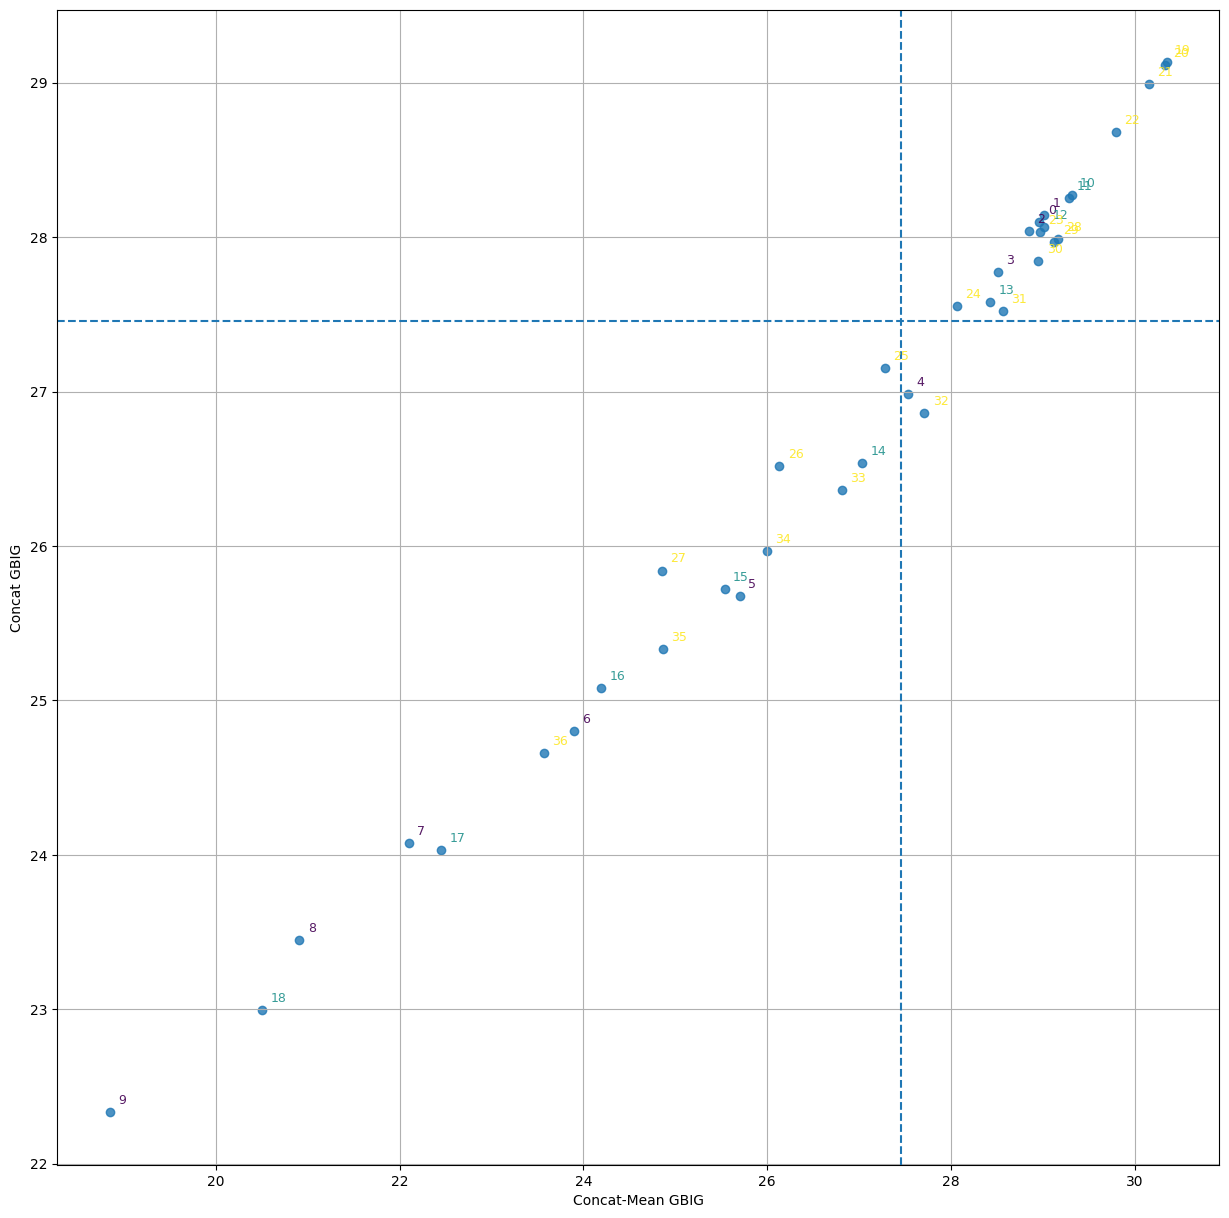

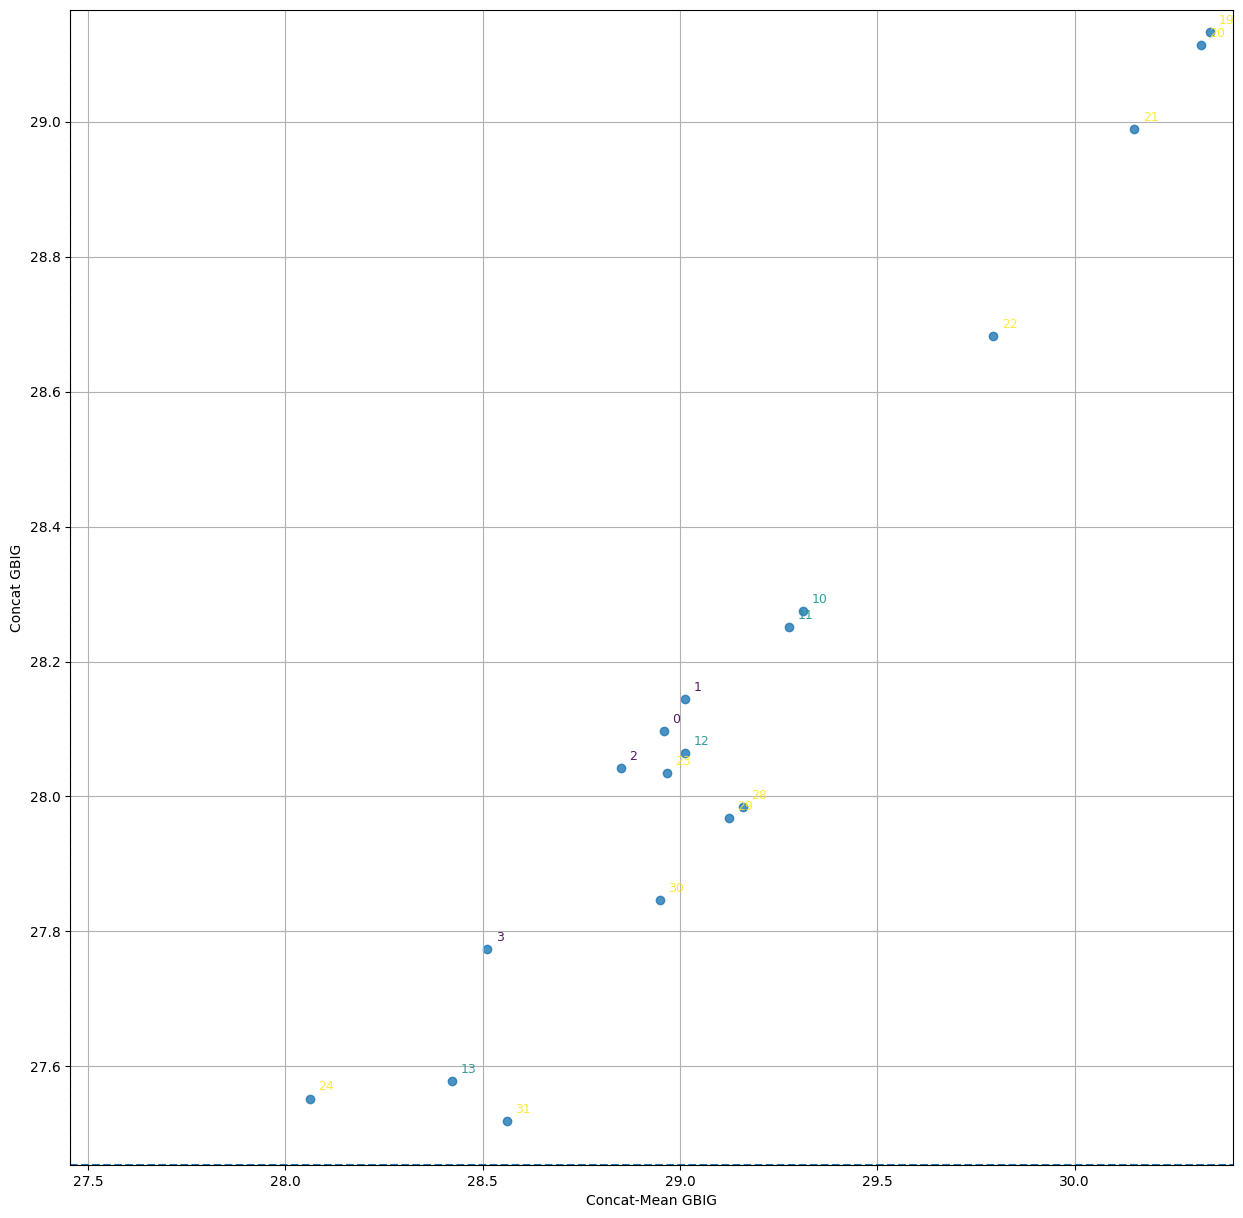

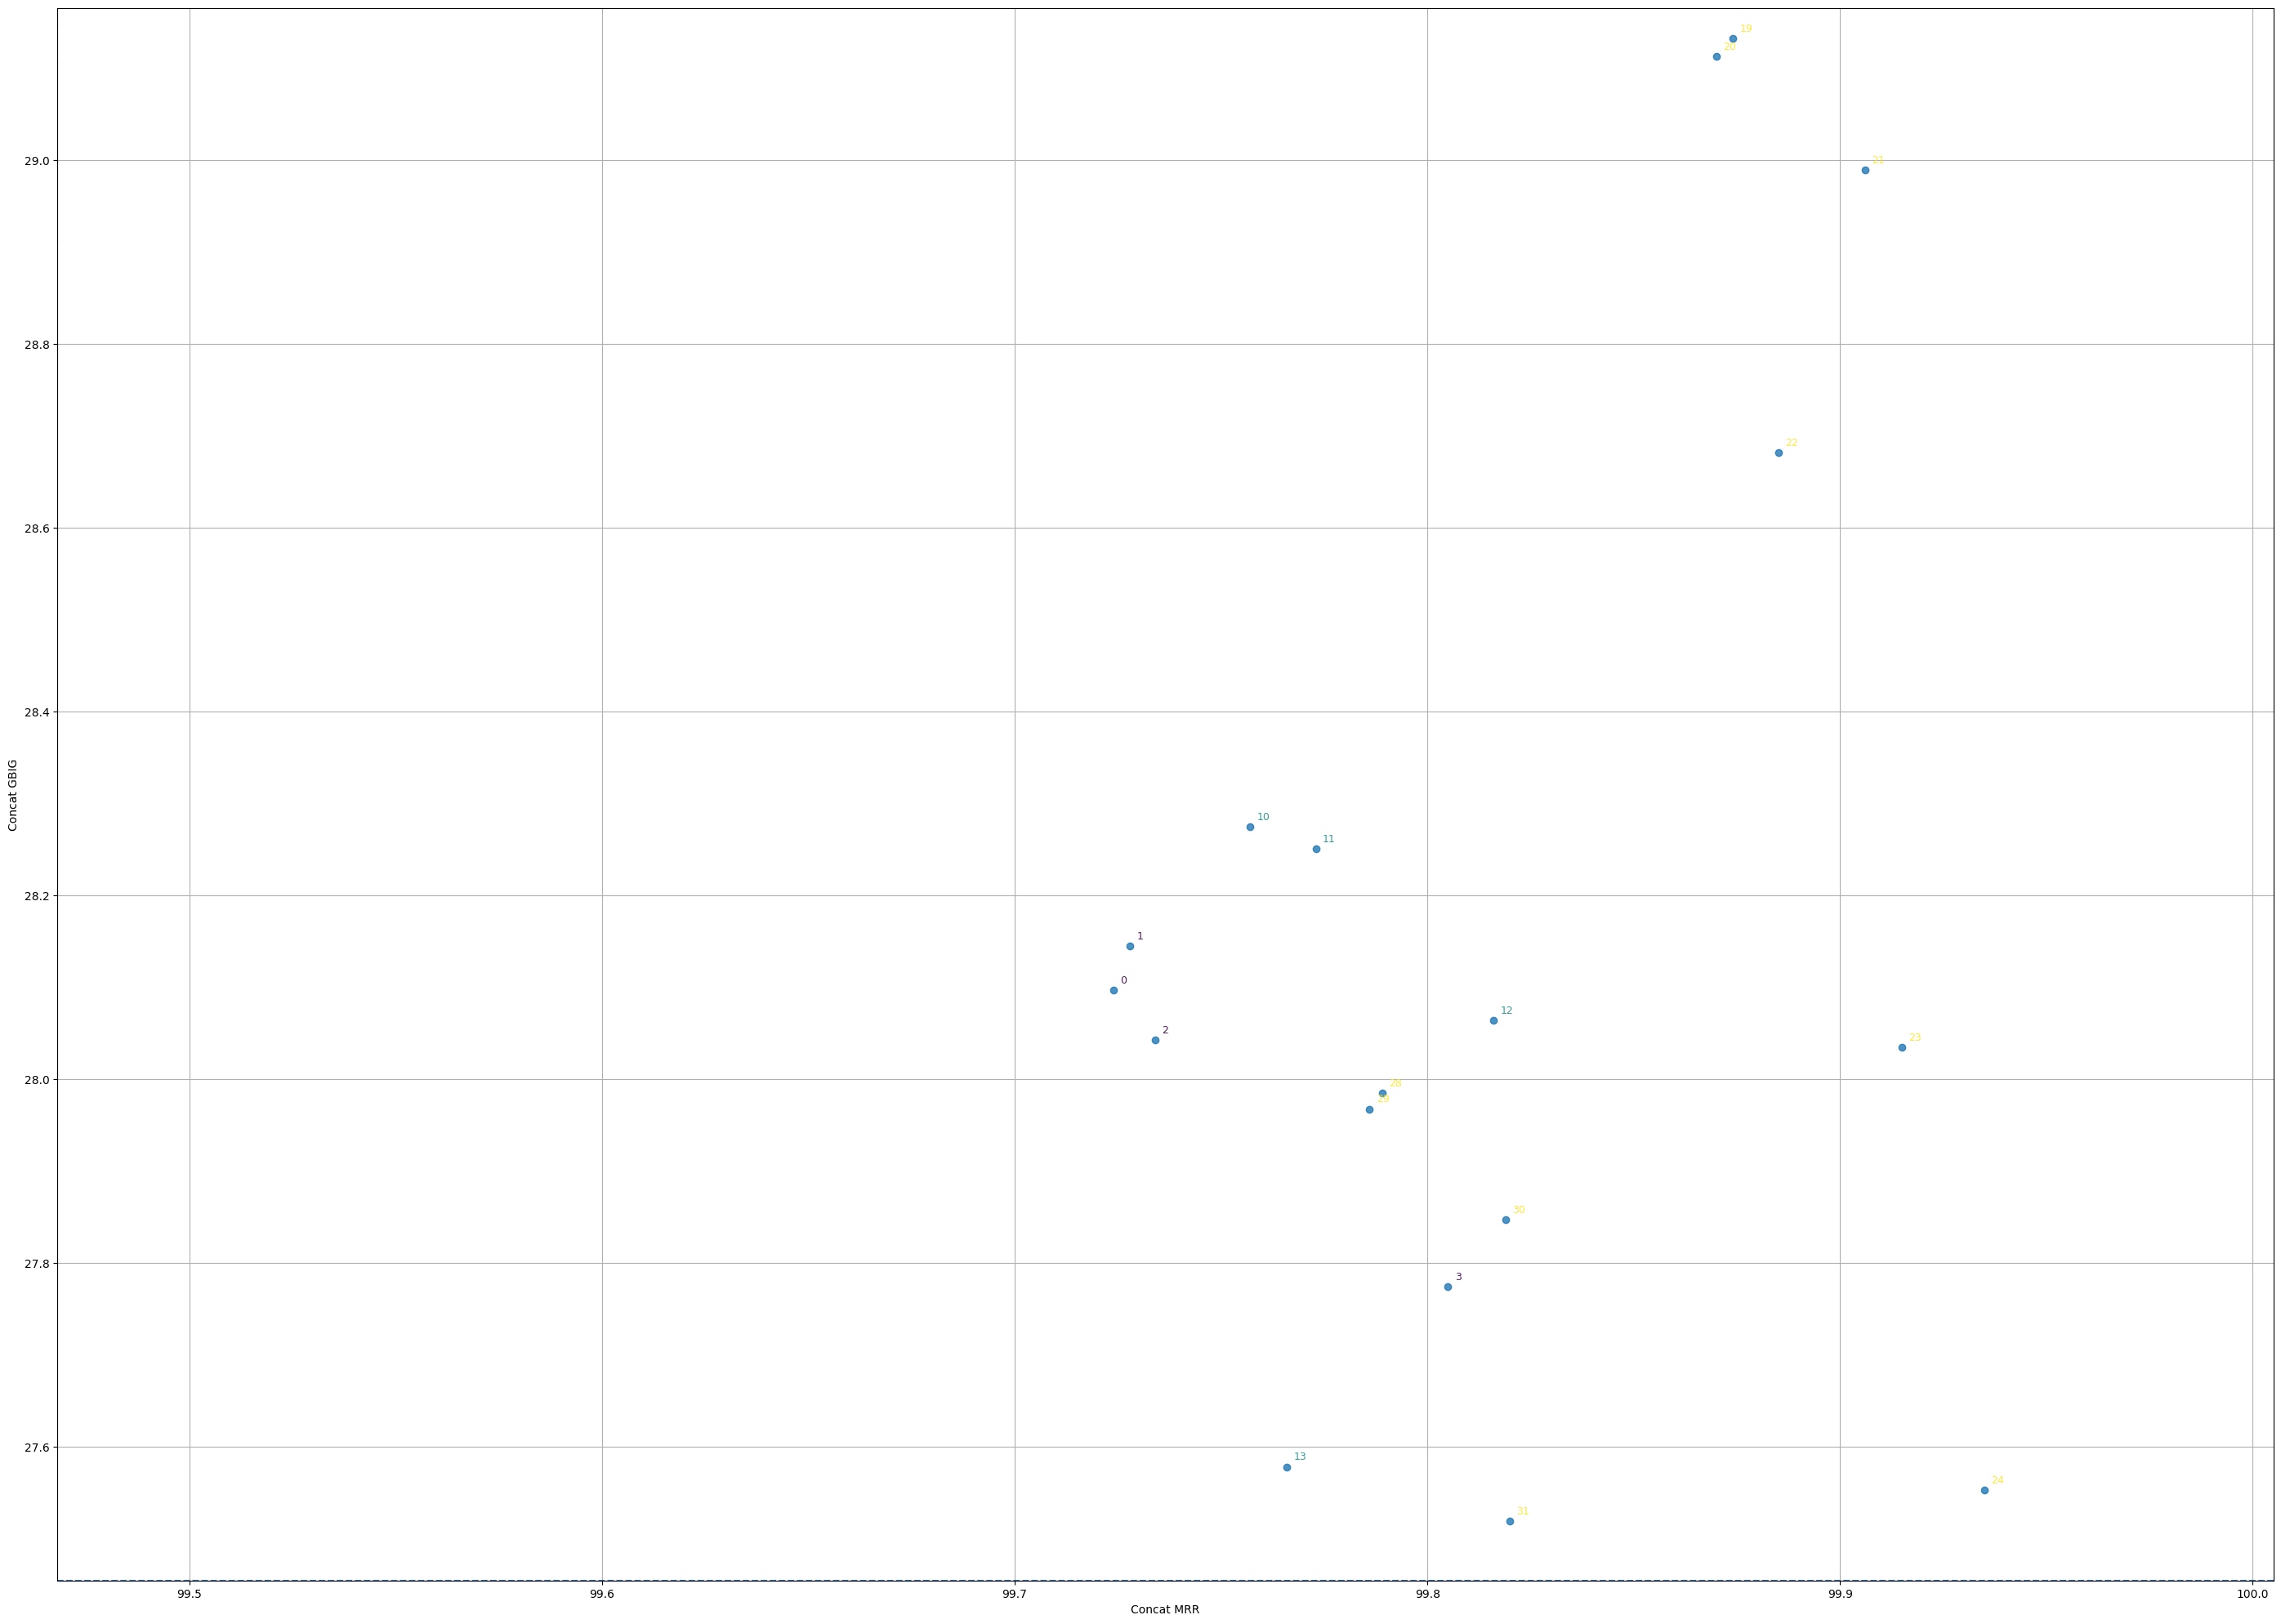

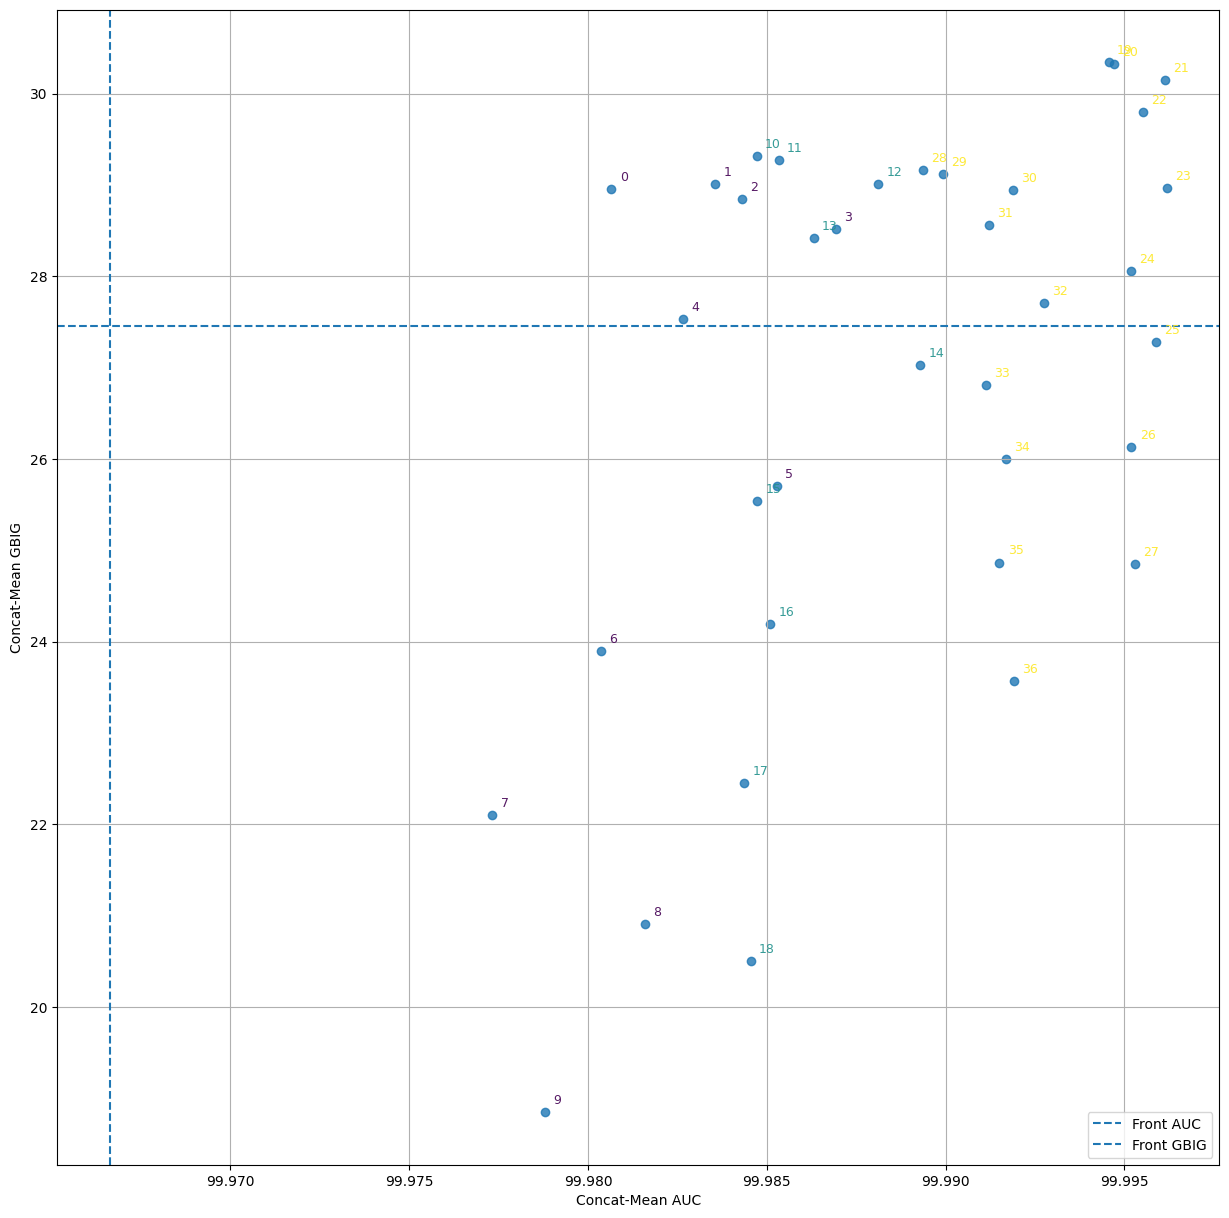

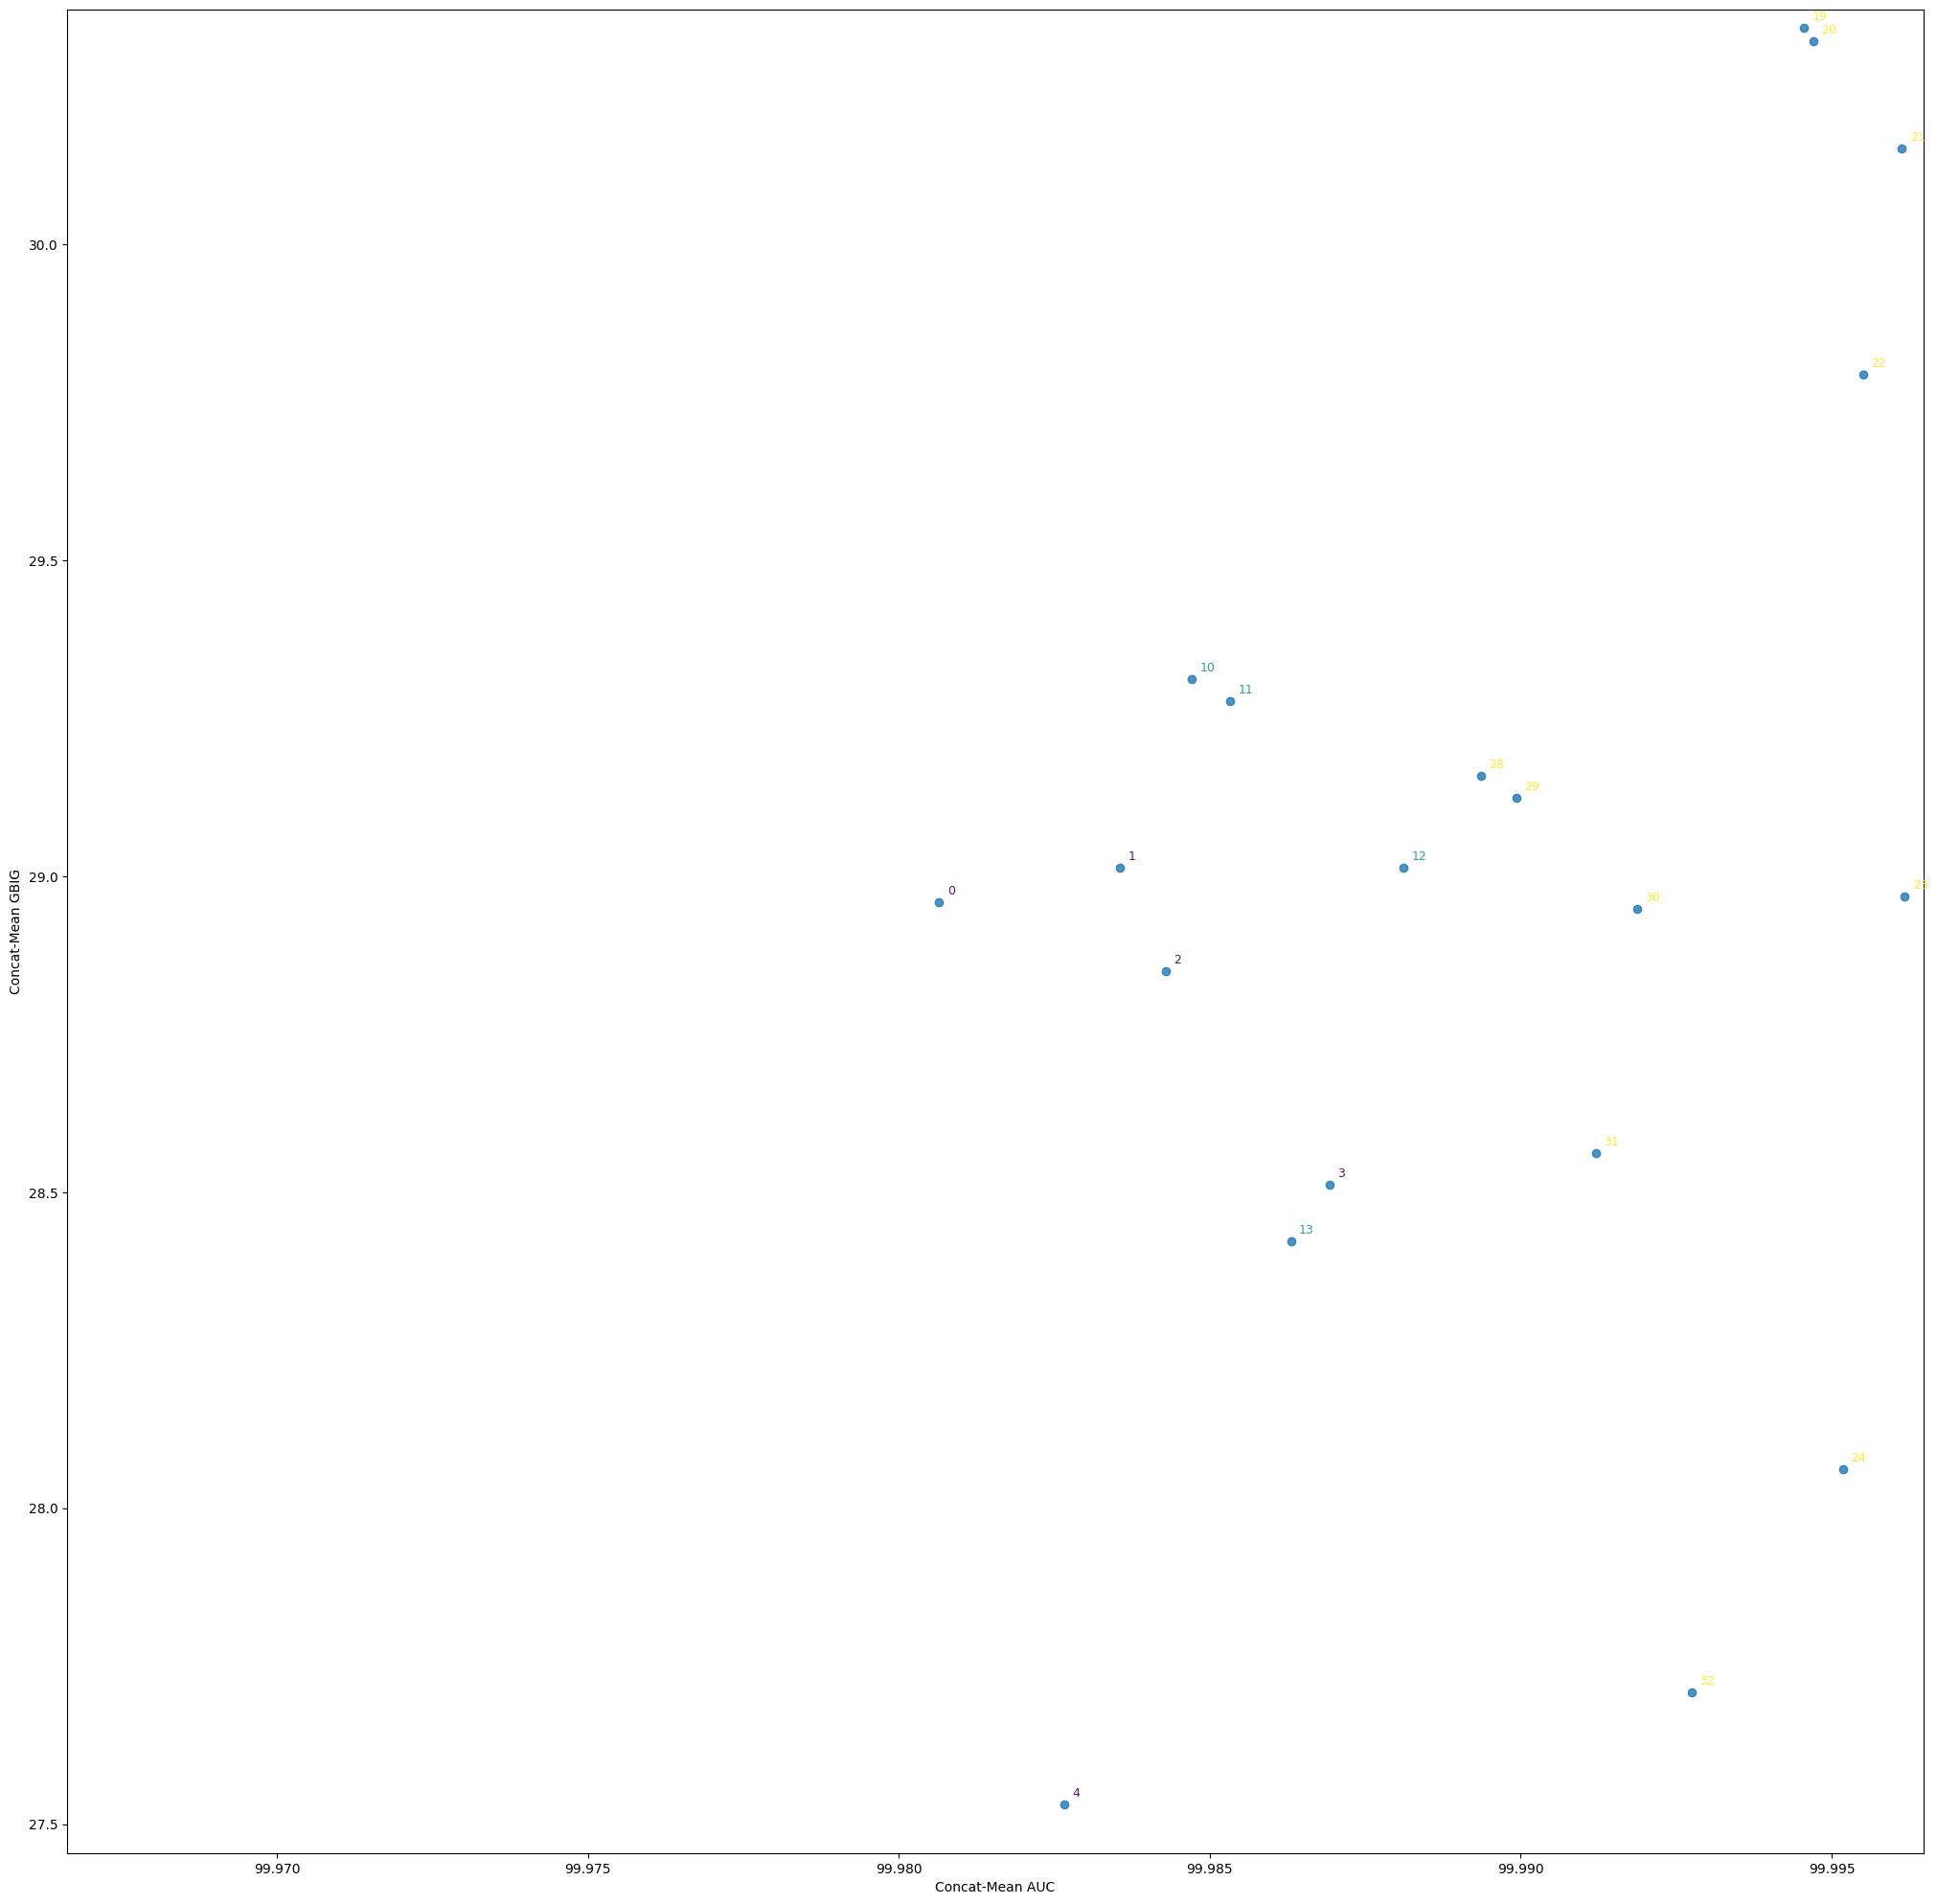

In [15]:

process_and_plot_mrr('mass_eval_late_fusion_dataset15_glint18_extras-LAST.txt', ylim=(99.45, 100), full_concat_mrr_ref=100)

Exp | Front MRR | Front GBIG | Front AUC | Concat MRR | Concat GBIG | Concat AUC | Concat-Mean MRR | Concat-Mean GBIG | Concat-Mean AUC | Dataset
------------------------------------------------------------------------------------------------------------------------
Exp 00 | 99.9840 | 38.222 | 99.999799 | 99.9840 | 38.222 | 99.999799 | 99.9840 | 38.222 | 99.999799 | ['0_0']
Exp 01 | 99.9840 | 38.222 | 99.999799 | 99.9950 | 38.755 | 99.999813 | 99.9950 | 39.525 | 99.999815 | ['-10_0', '-9_0', '-8_0', '-7_0', '-6_0', '-5_0', '-4_0', '-3_0', '-2_0', '-1_0', '0_-10', '0_-9', '0_-8', '0_-7', '0_-6', '0_-5', '0_-4', '0_-3', '0_-2', '0_-1', '0_0', '0_1', '0_2', '0_3', '0_4', '0_5', '0_6', '0_7', '0_8', '0_9', '0_10', '1_0', '2_0', '3_0', '4_0', '5_0', '6_0', '7_0', '8_0', '9_0', '10_0']
Exp 02 | 99.9840 | 38.222 | 99.999799 | 99.9950 | 38.768 | 99.999814 | 99.9950 | 39.520 | 99.999816 | ['-10_0', '-8_0', '-6_0', '-4_0', '-2_0', '0_-10', '0_-8', '0_-6', '0_-4', '0_-2', '0_0', '0_2', '0_4', '0_

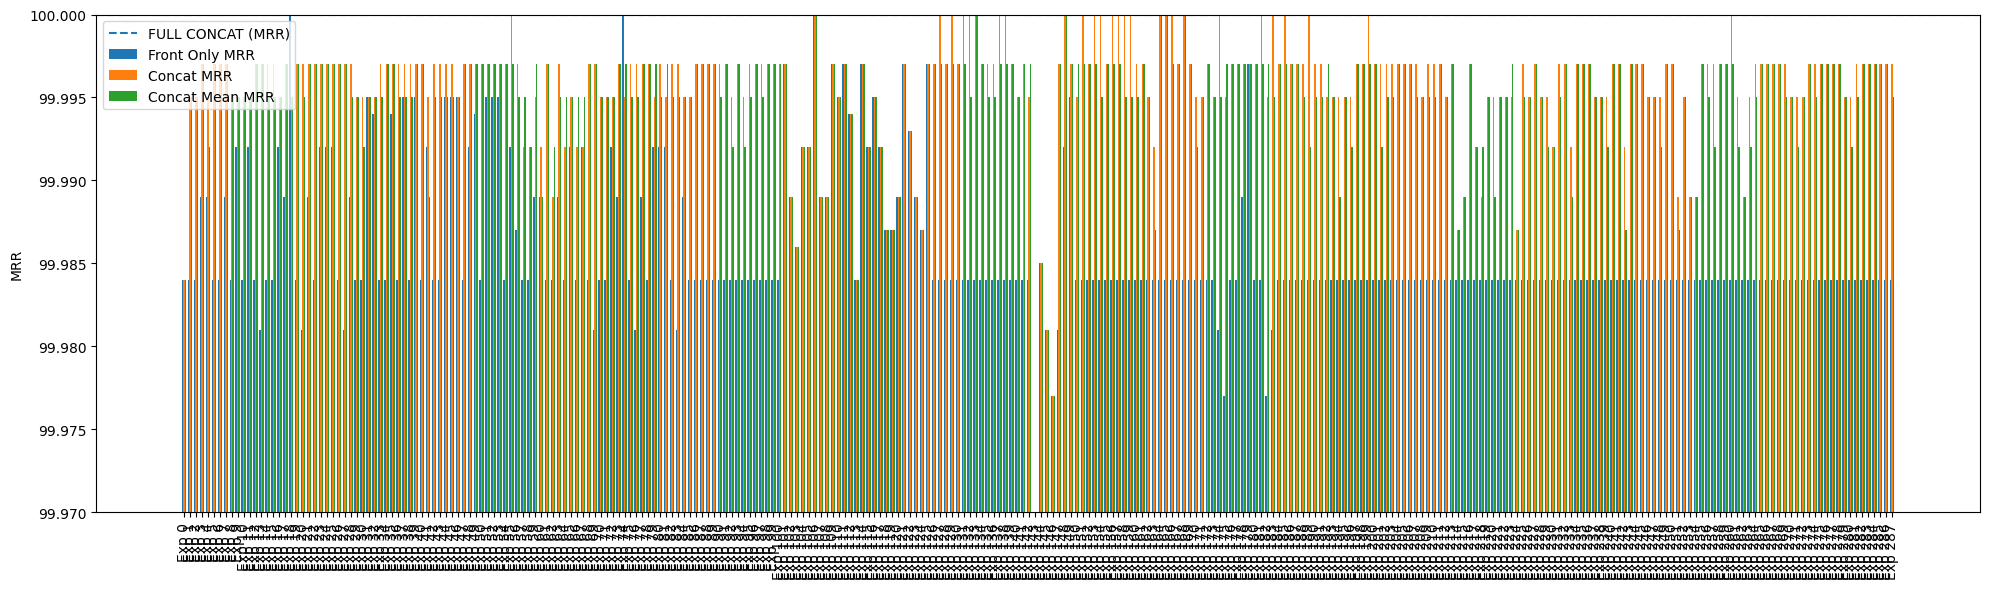

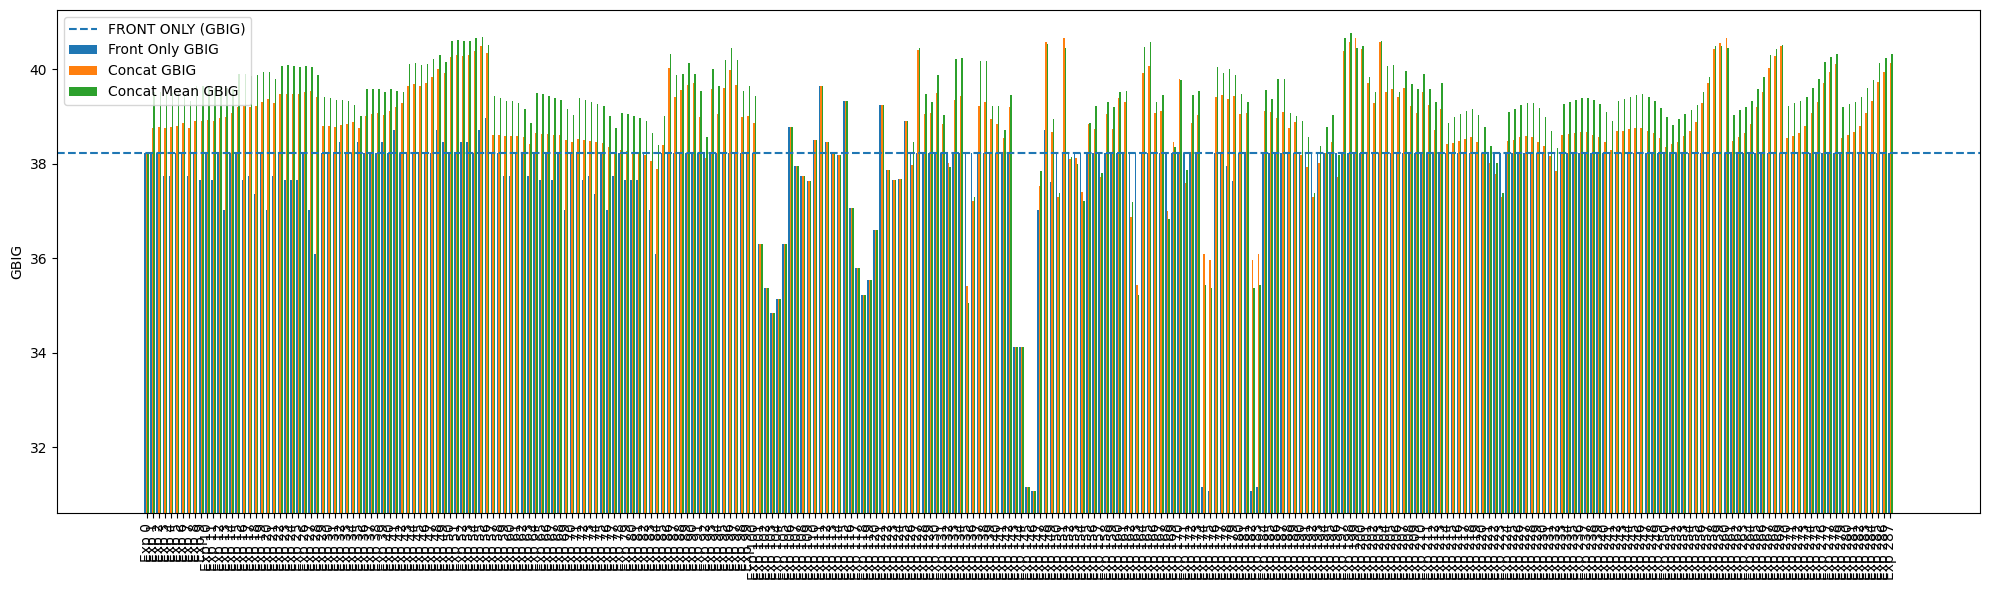

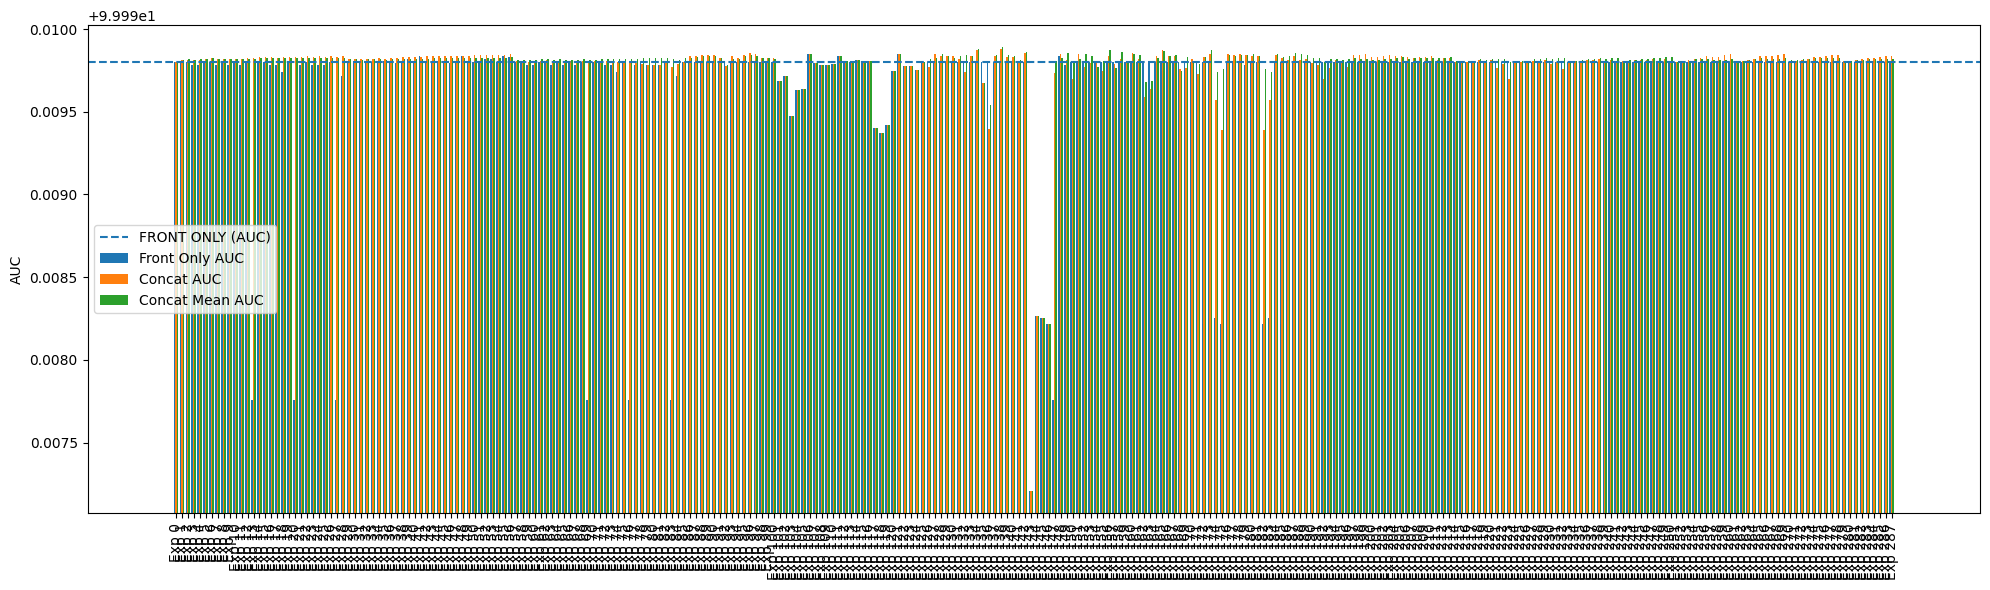

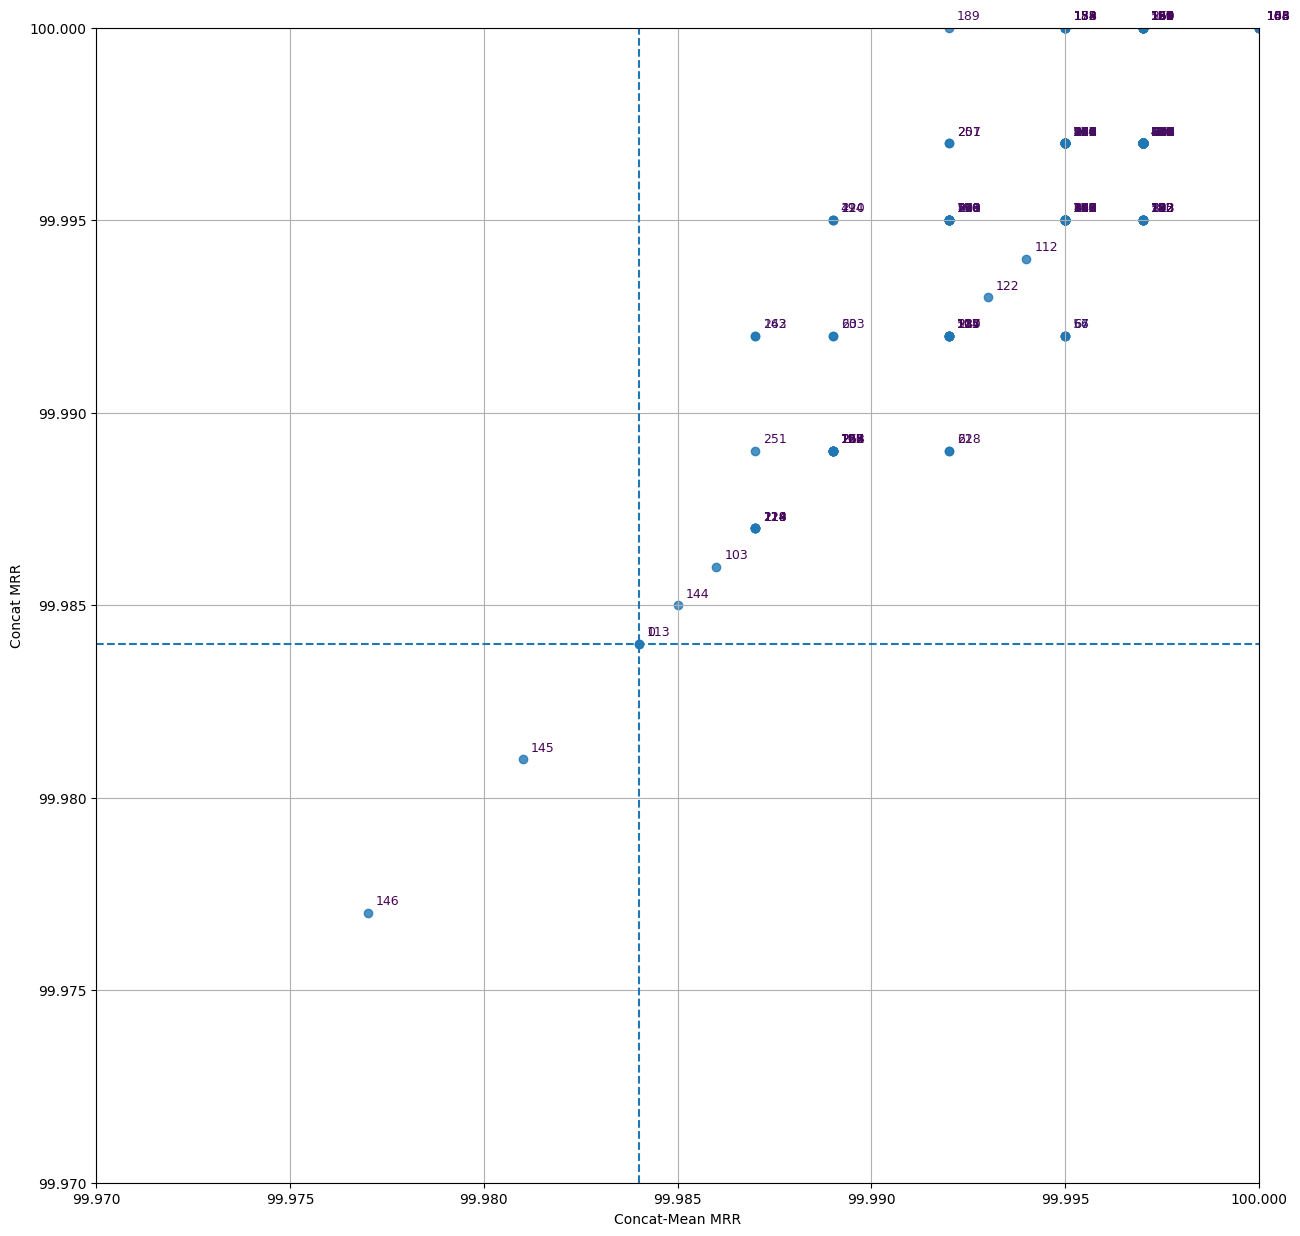

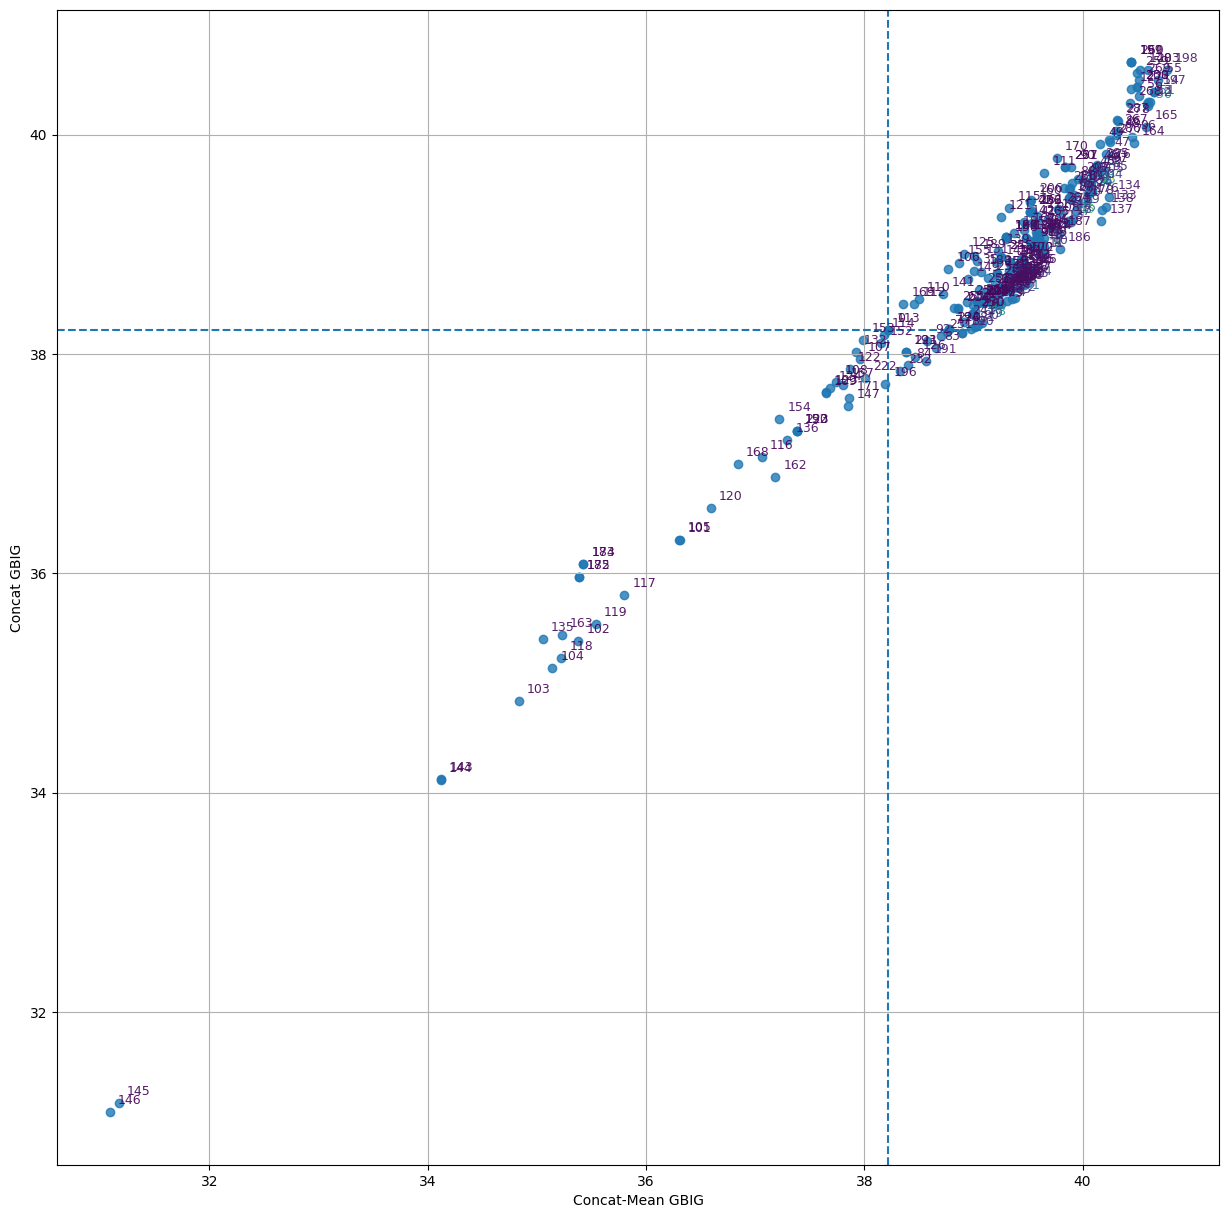

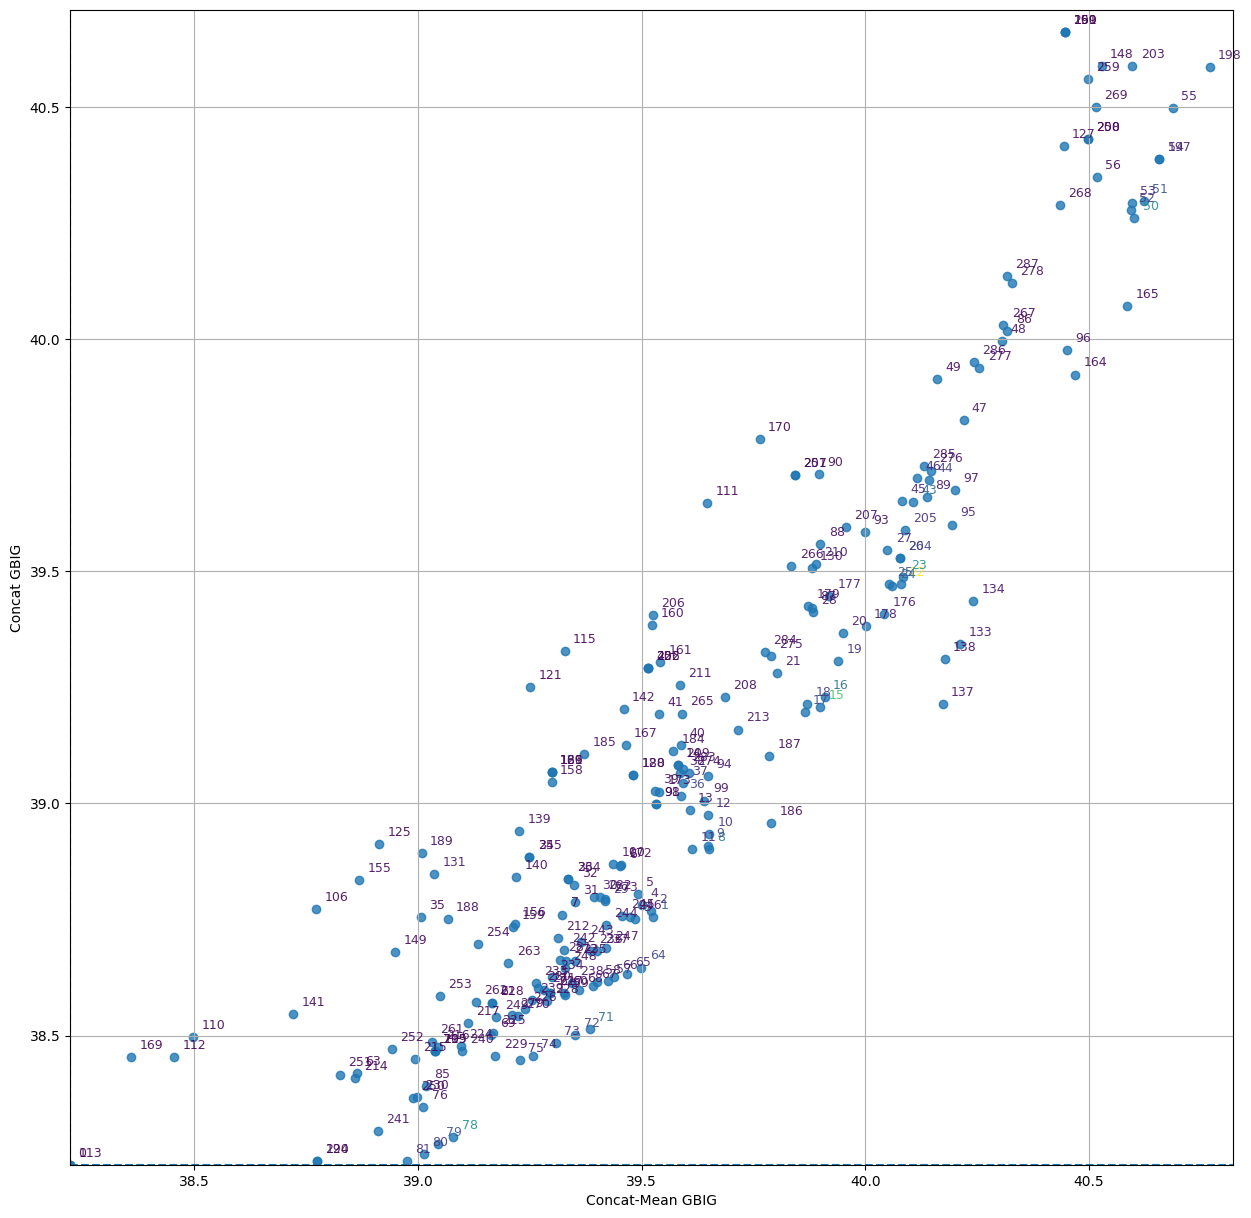

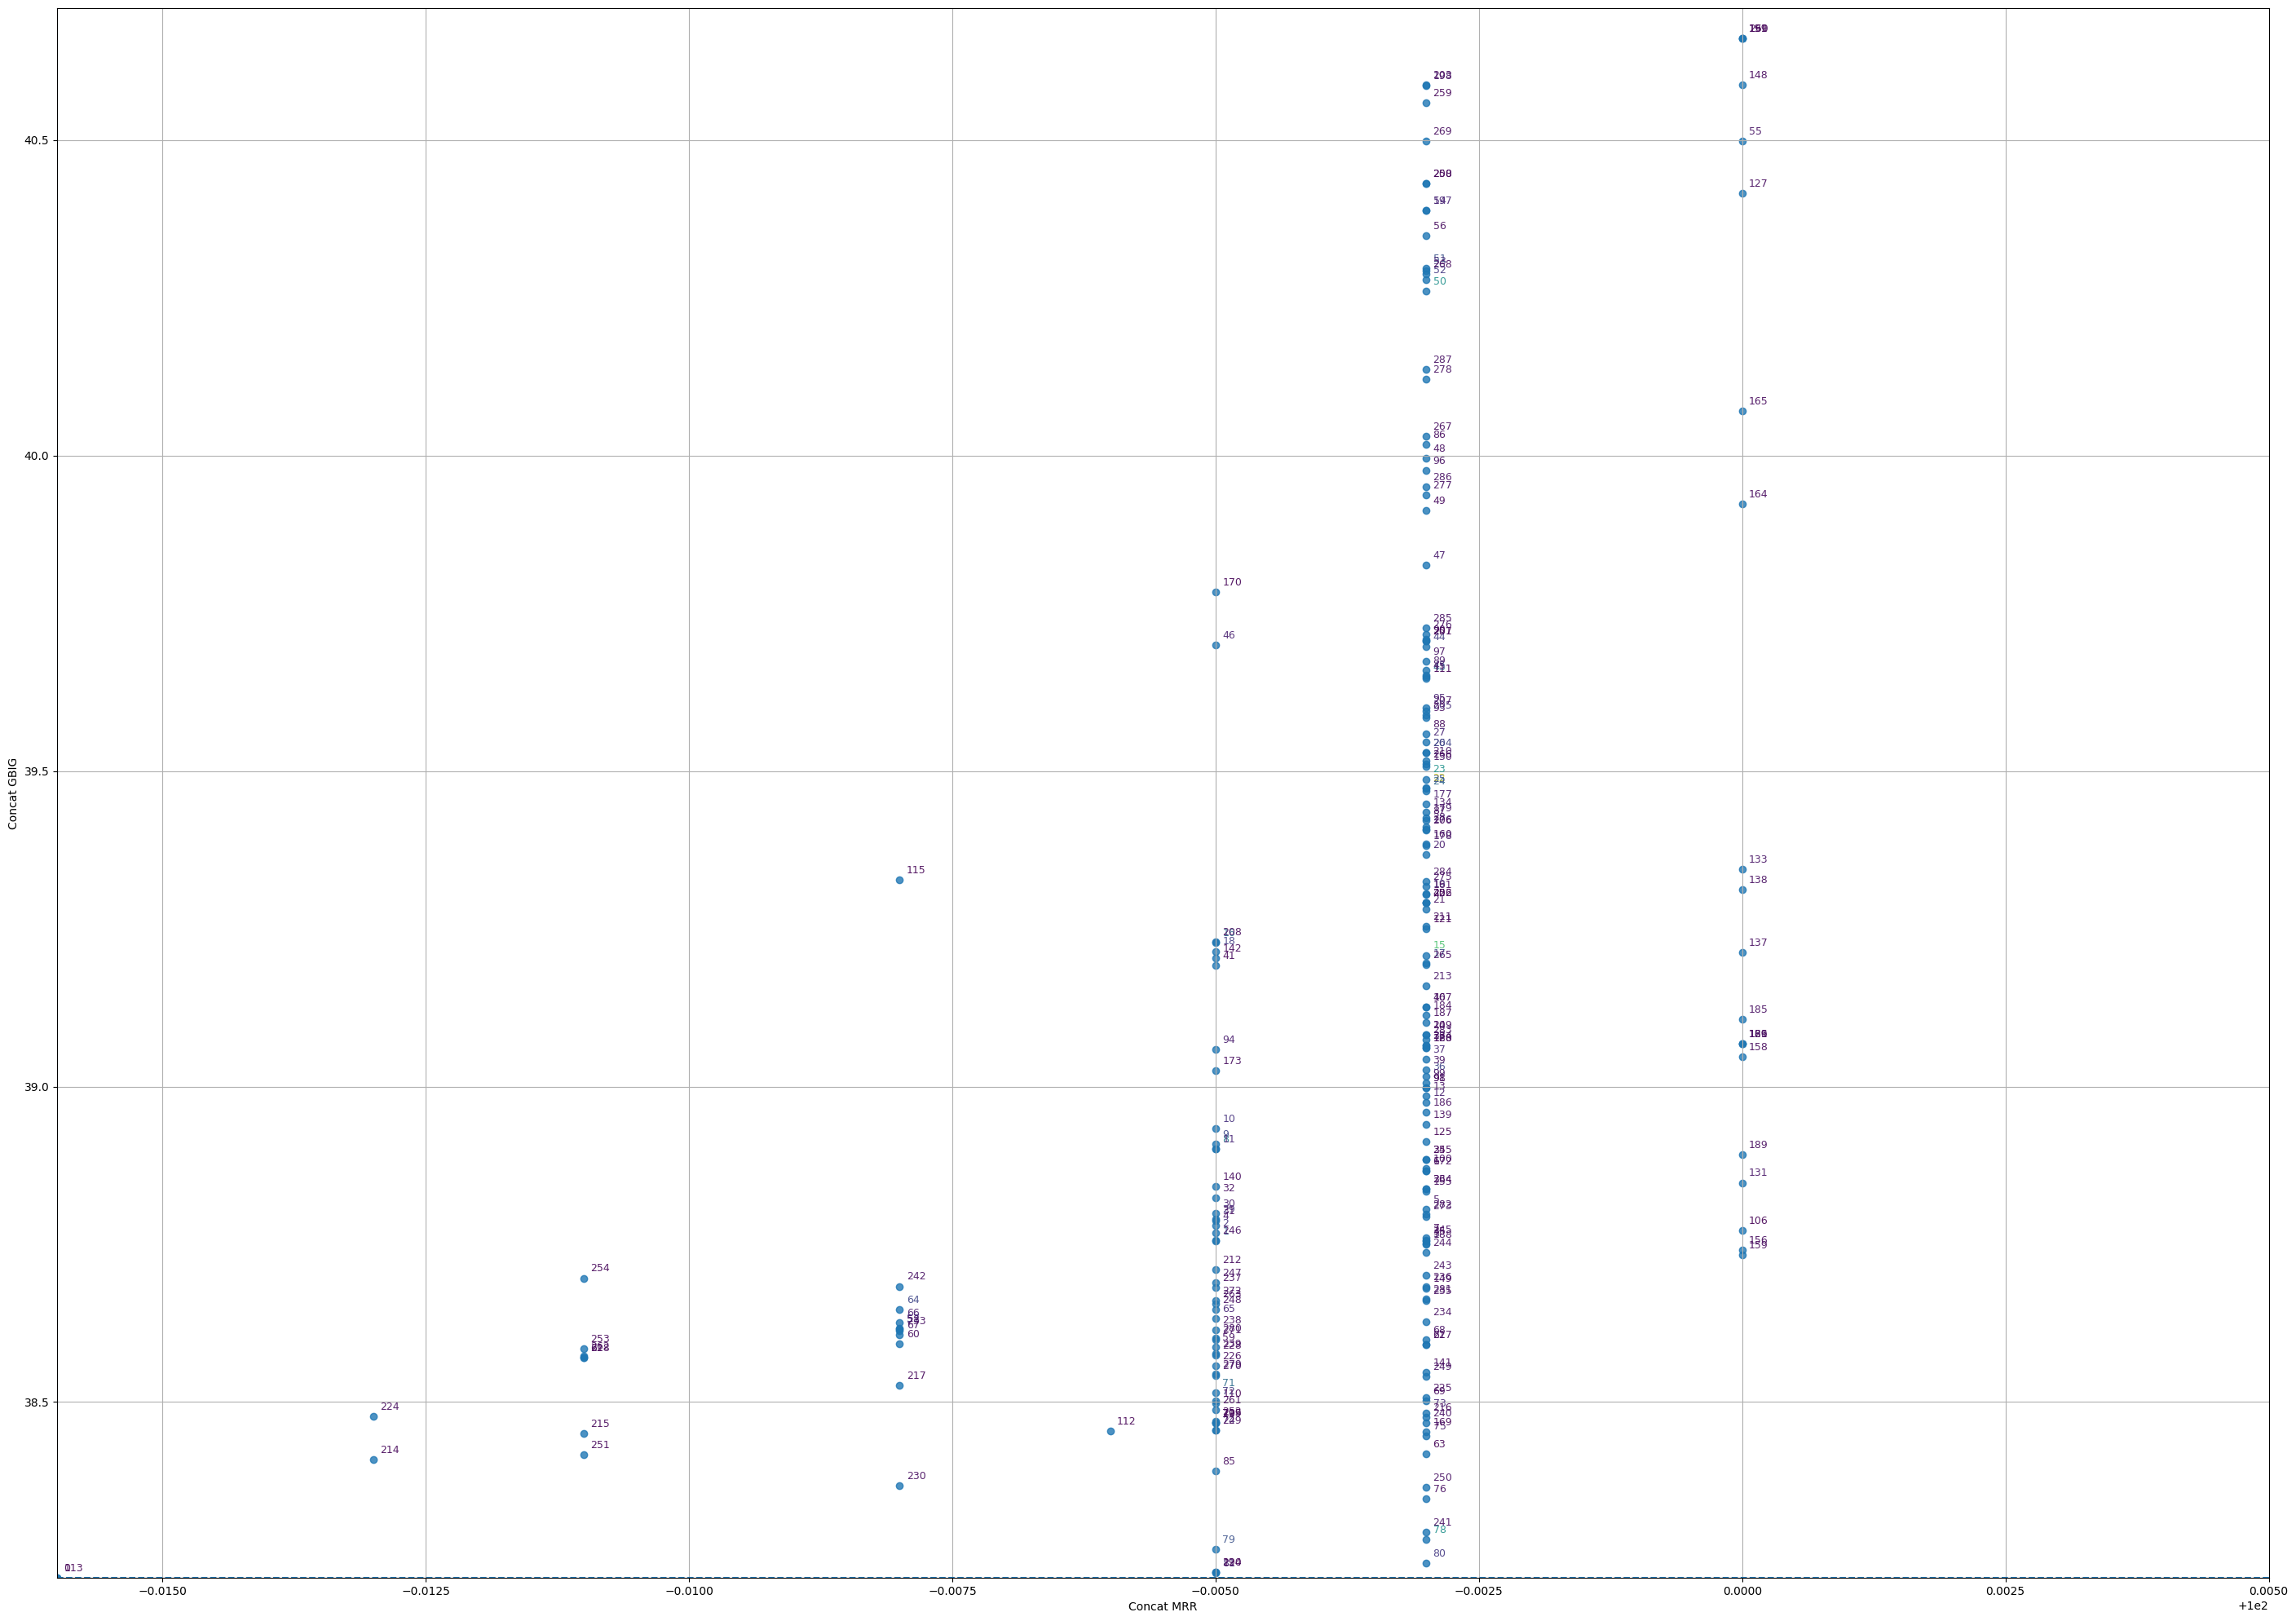

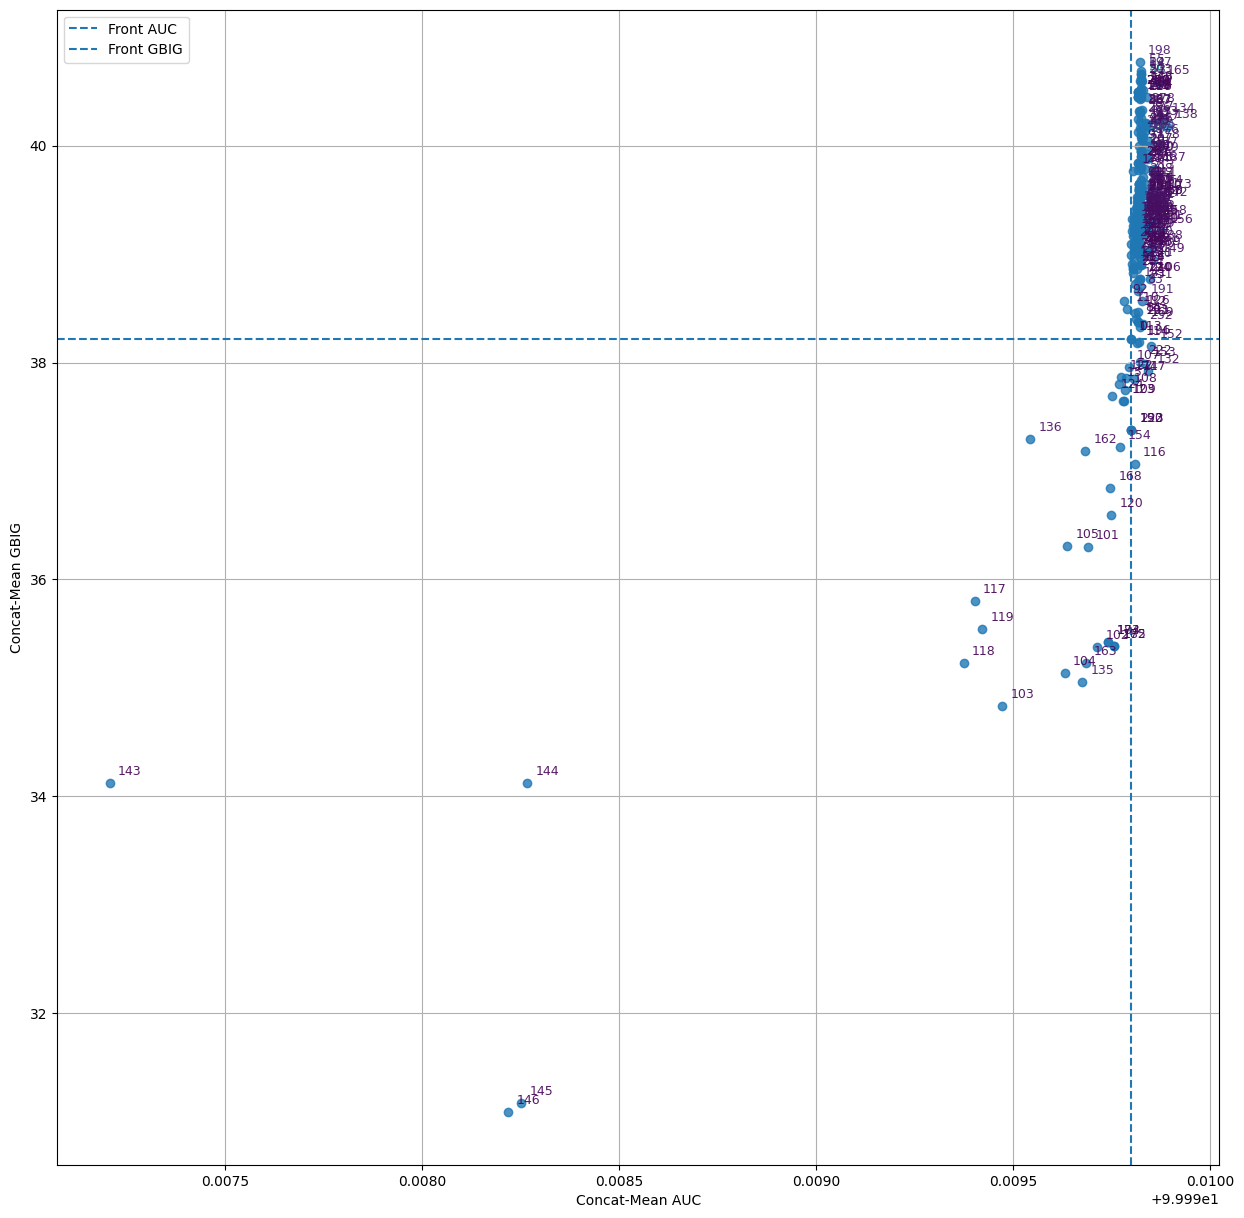

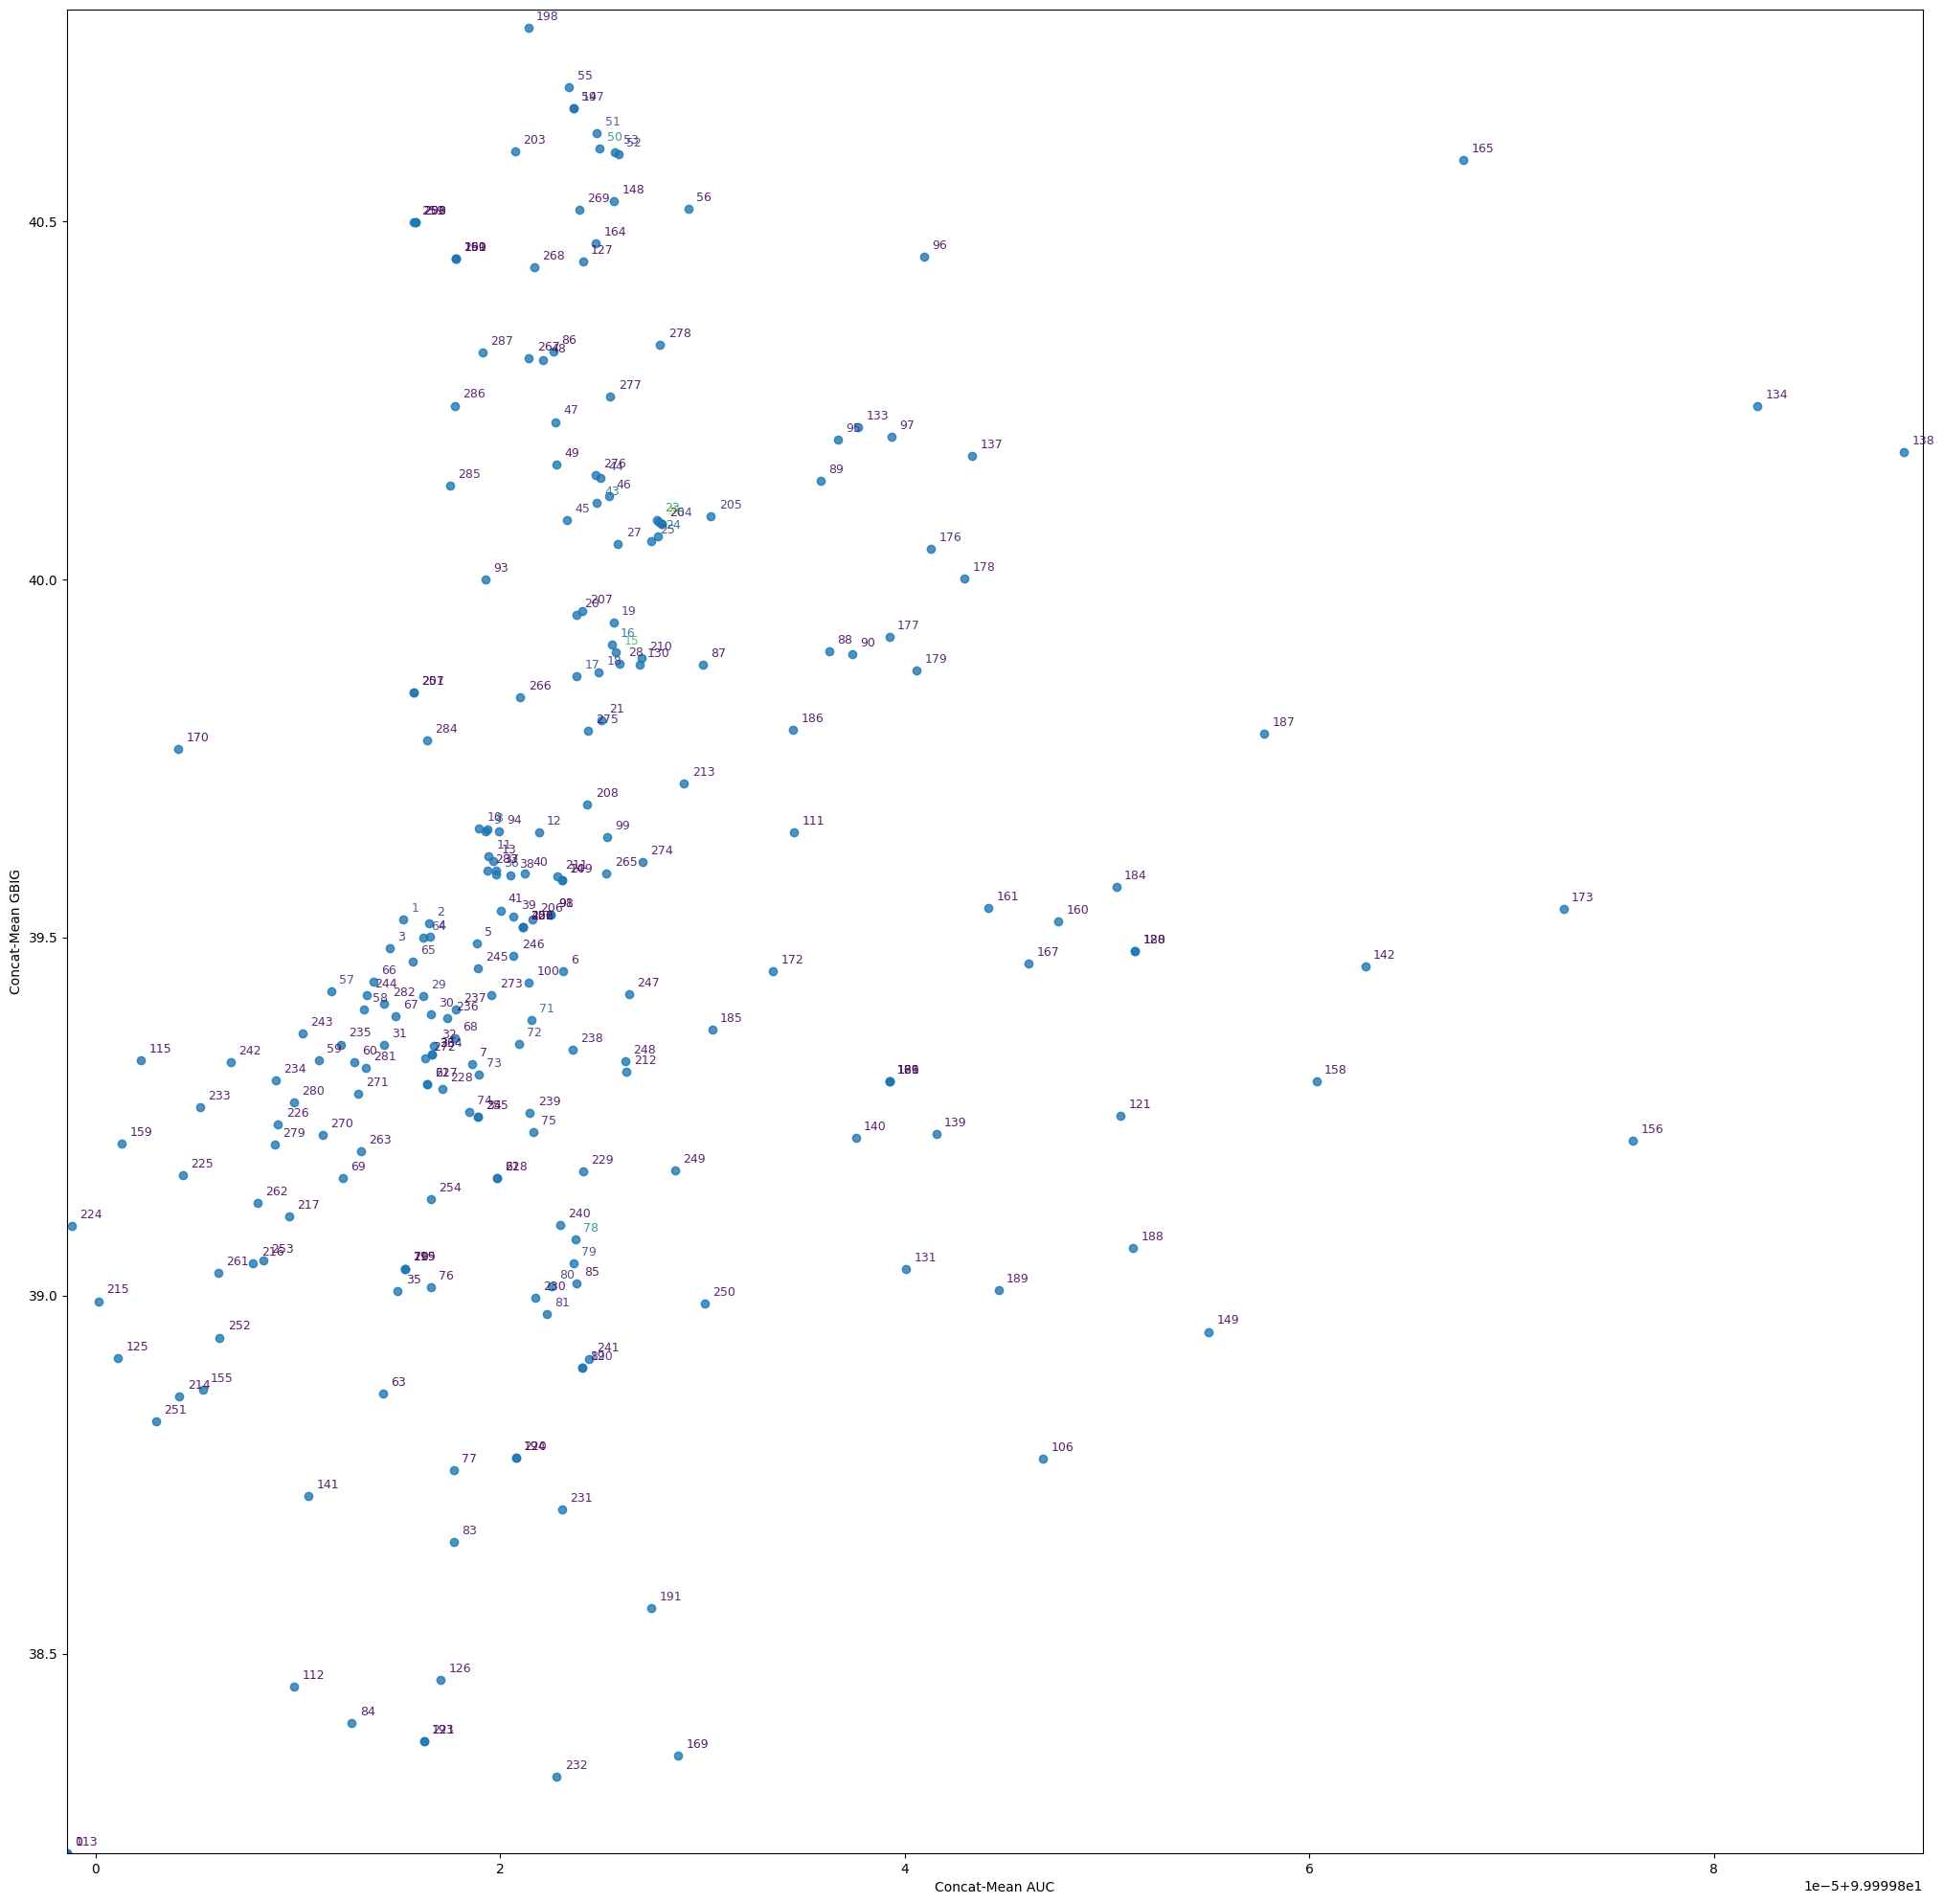

In [30]:
process_and_plot_mrr('mass_eval_late_fusion_glint100_extrasV5Full.txt', ylim=(99.97, 100), full_concat_mrr_ref=100)

Exp | Front MRR | Front GBIG | Front AUC | Concat MRR | Concat GBIG | Concat AUC | Concat-Mean MRR | Concat-Mean GBIG | Concat-Mean AUC | Dataset
------------------------------------------------------------------------------------------------------------------------
Exp 00 | 99.9840 | 38.222 | 99.999799 | 99.9950 | 38.470 | 99.999805 | 99.9950 | 38.941 | 99.999806 | ['0_-3', '0_0', '0_3']
Exp 01 | 99.9840 | 38.222 | 99.999799 | 99.9890 | 38.585 | 99.999810 | 99.9890 | 39.050 | 99.999808 | ['0_-5', '0_0', '0_5']
Exp 02 | 99.9840 | 38.222 | 99.999799 | 99.9890 | 38.696 | 99.999818 | 99.9890 | 39.134 | 99.999817 | ['0_-7', '0_0', '0_7']
Exp 03 | 99.9840 | 38.222 | 99.999799 | 99.9970 | 38.885 | 99.999826 | 99.9970 | 39.249 | 99.999819 | ['0_-10', '0_0', '0_10']
Exp 04 | 99.9840 | 38.222 | 99.999799 | 99.9970 | 39.291 | 99.999834 | 99.9950 | 39.514 | 99.999821 | ['0_-15', '0_0', '0_15']
Exp 05 | 99.9840 | 38.222 | 99.999799 | 99.9970 | 39.706 | 99.999833 | 99.9920 | 39.842 | 99.999816 | ['

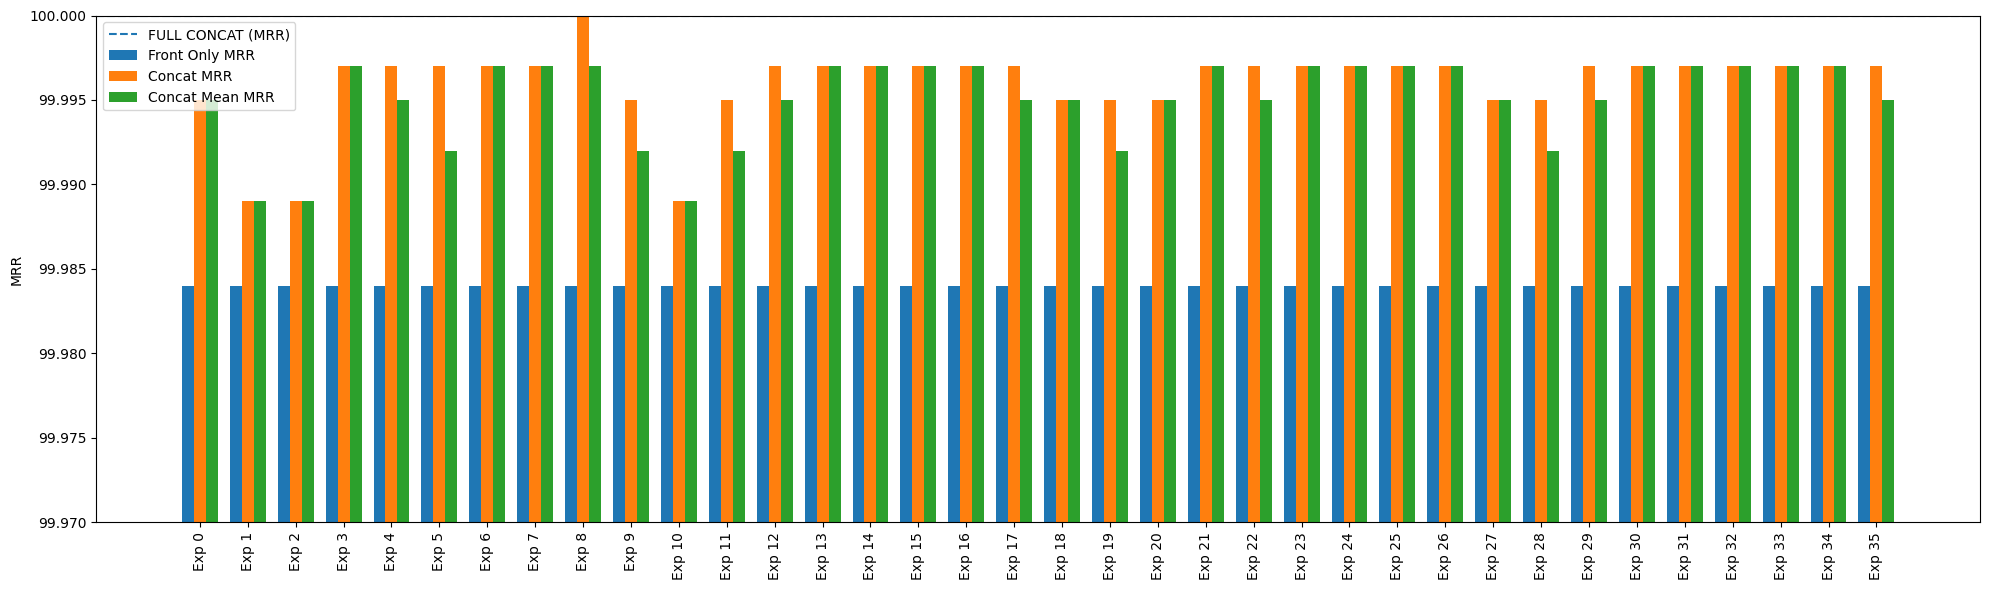

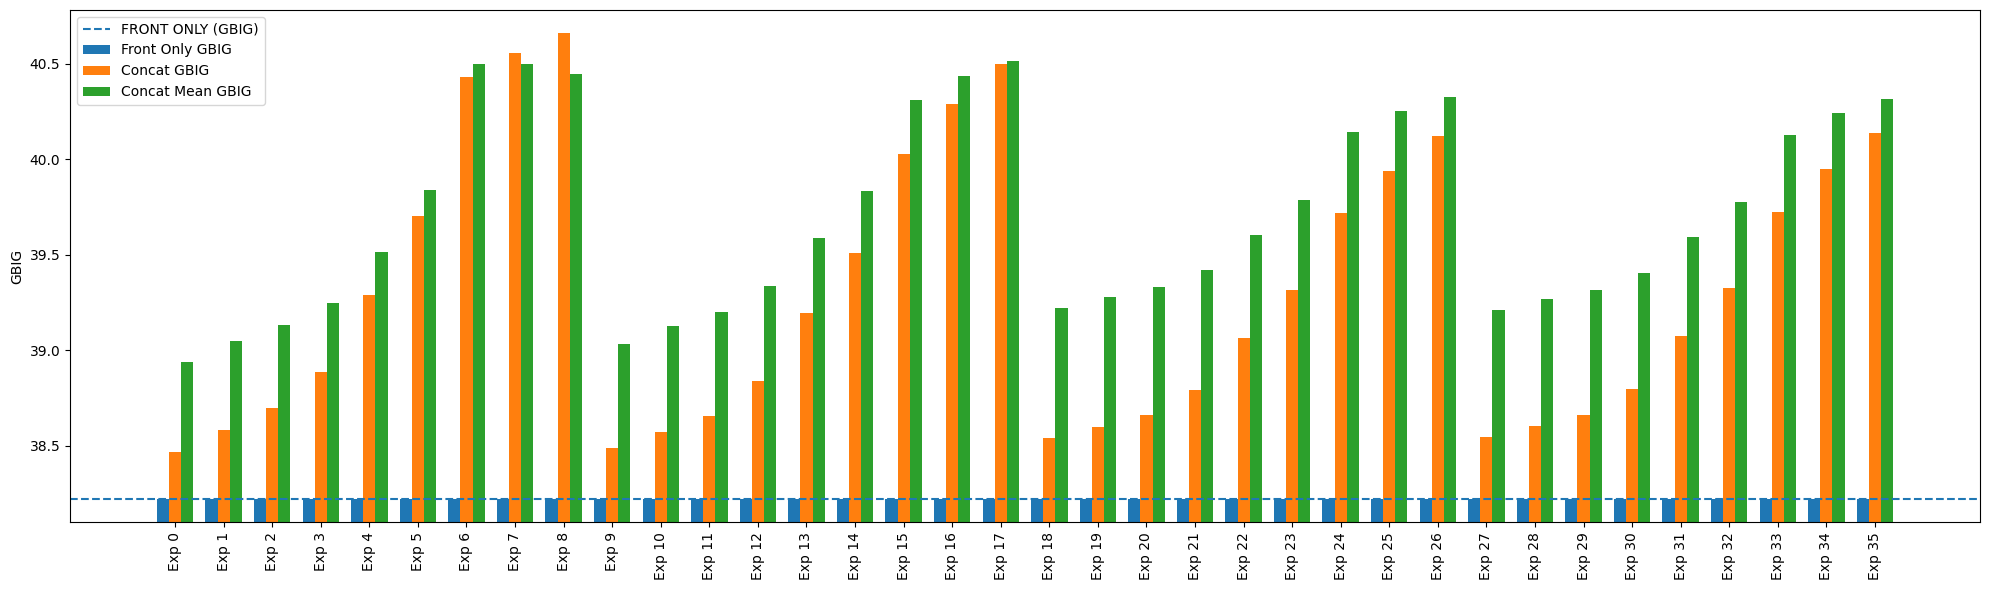

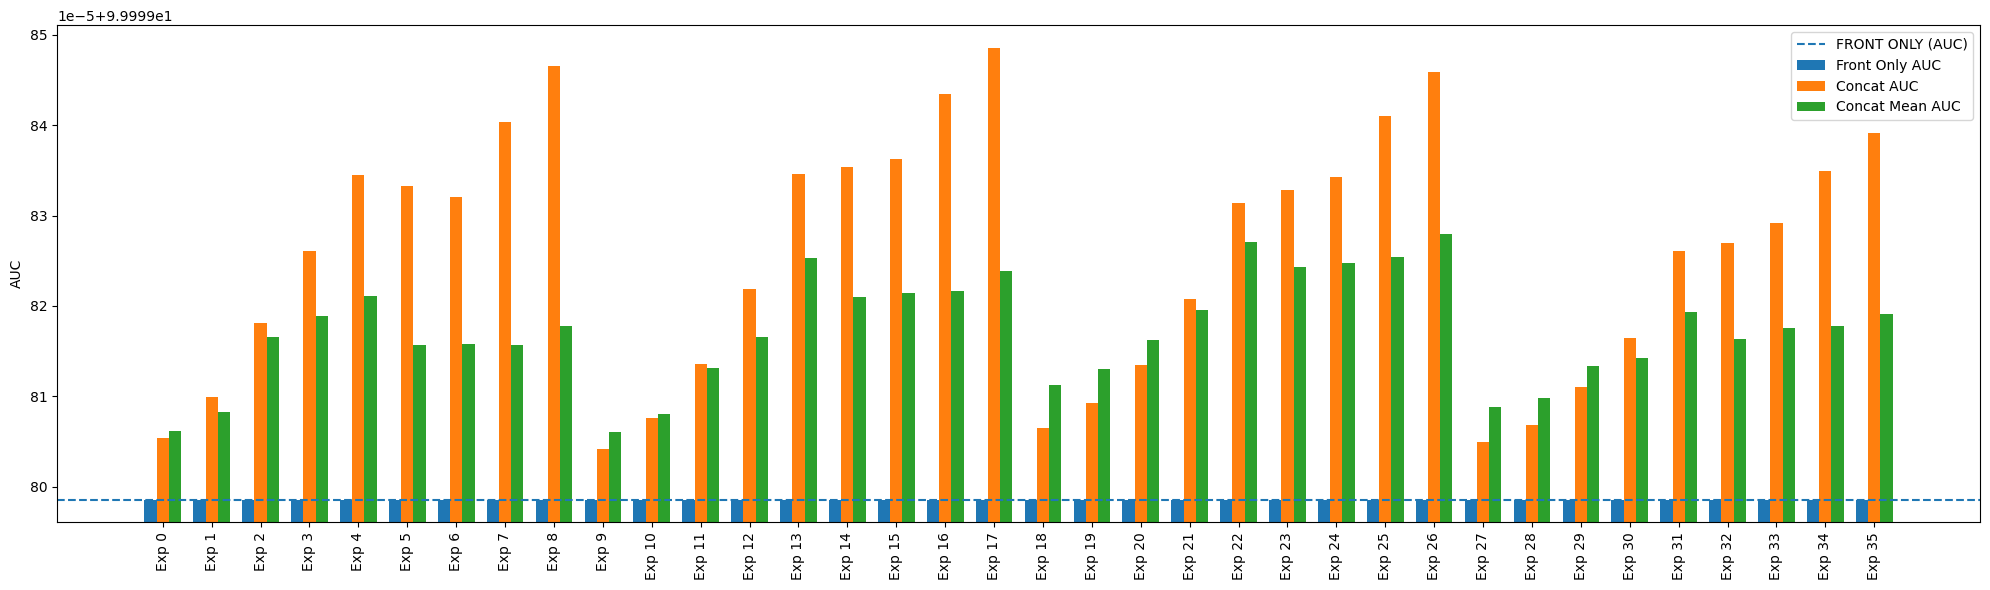

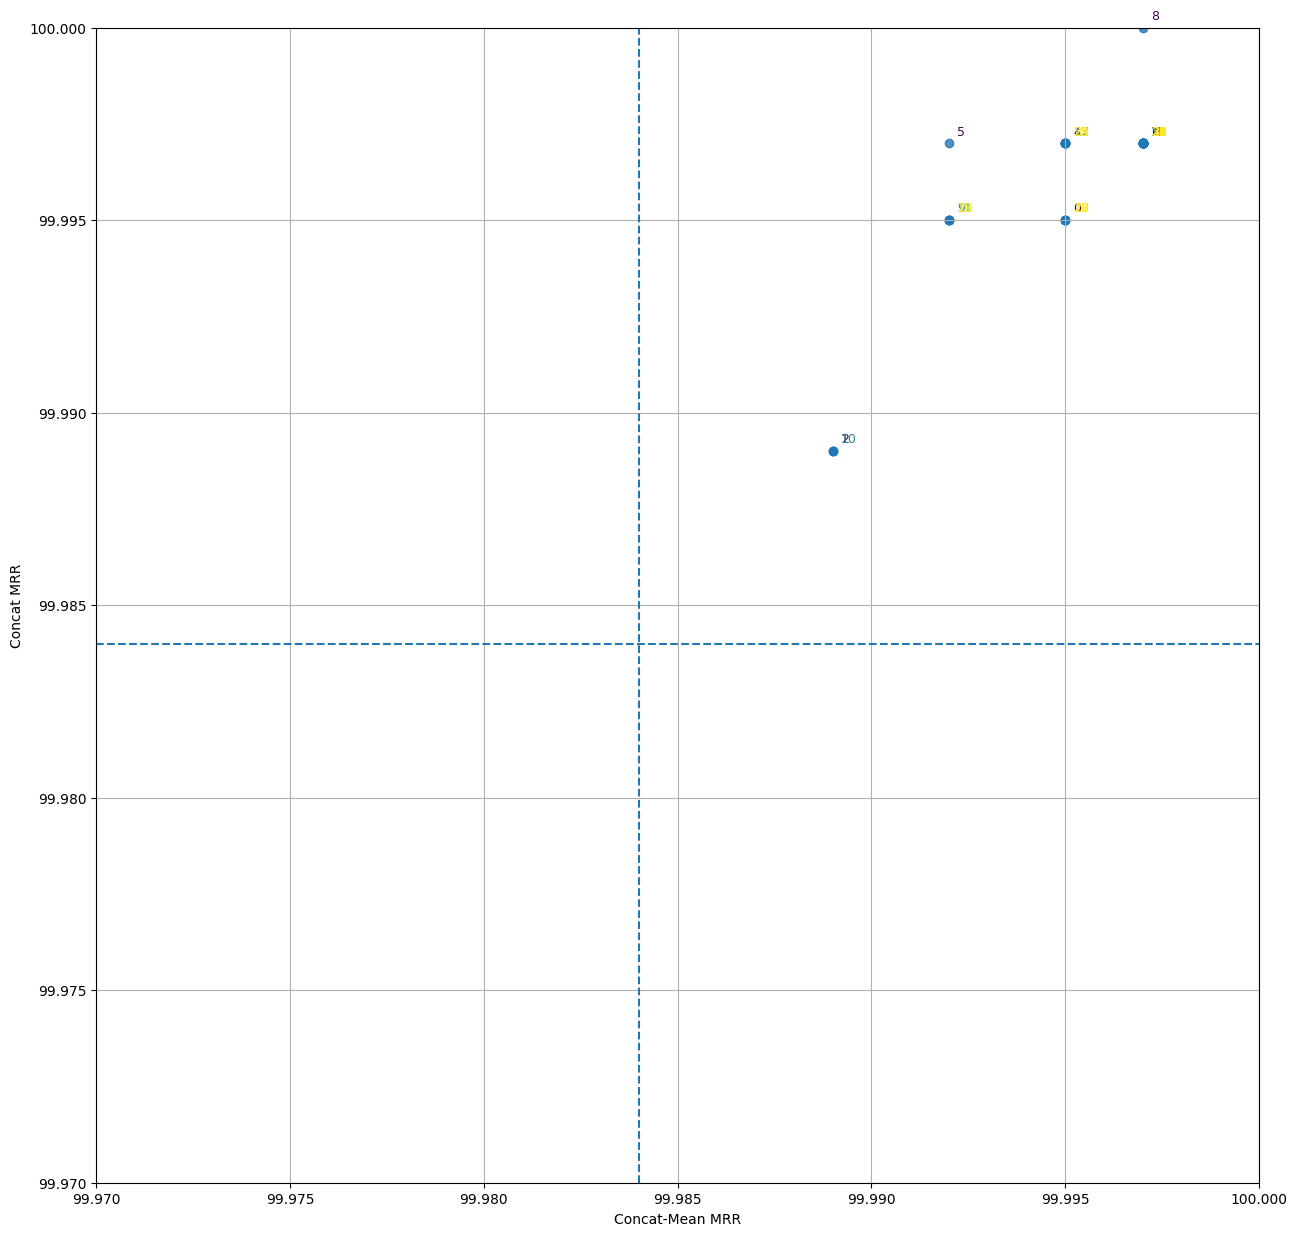

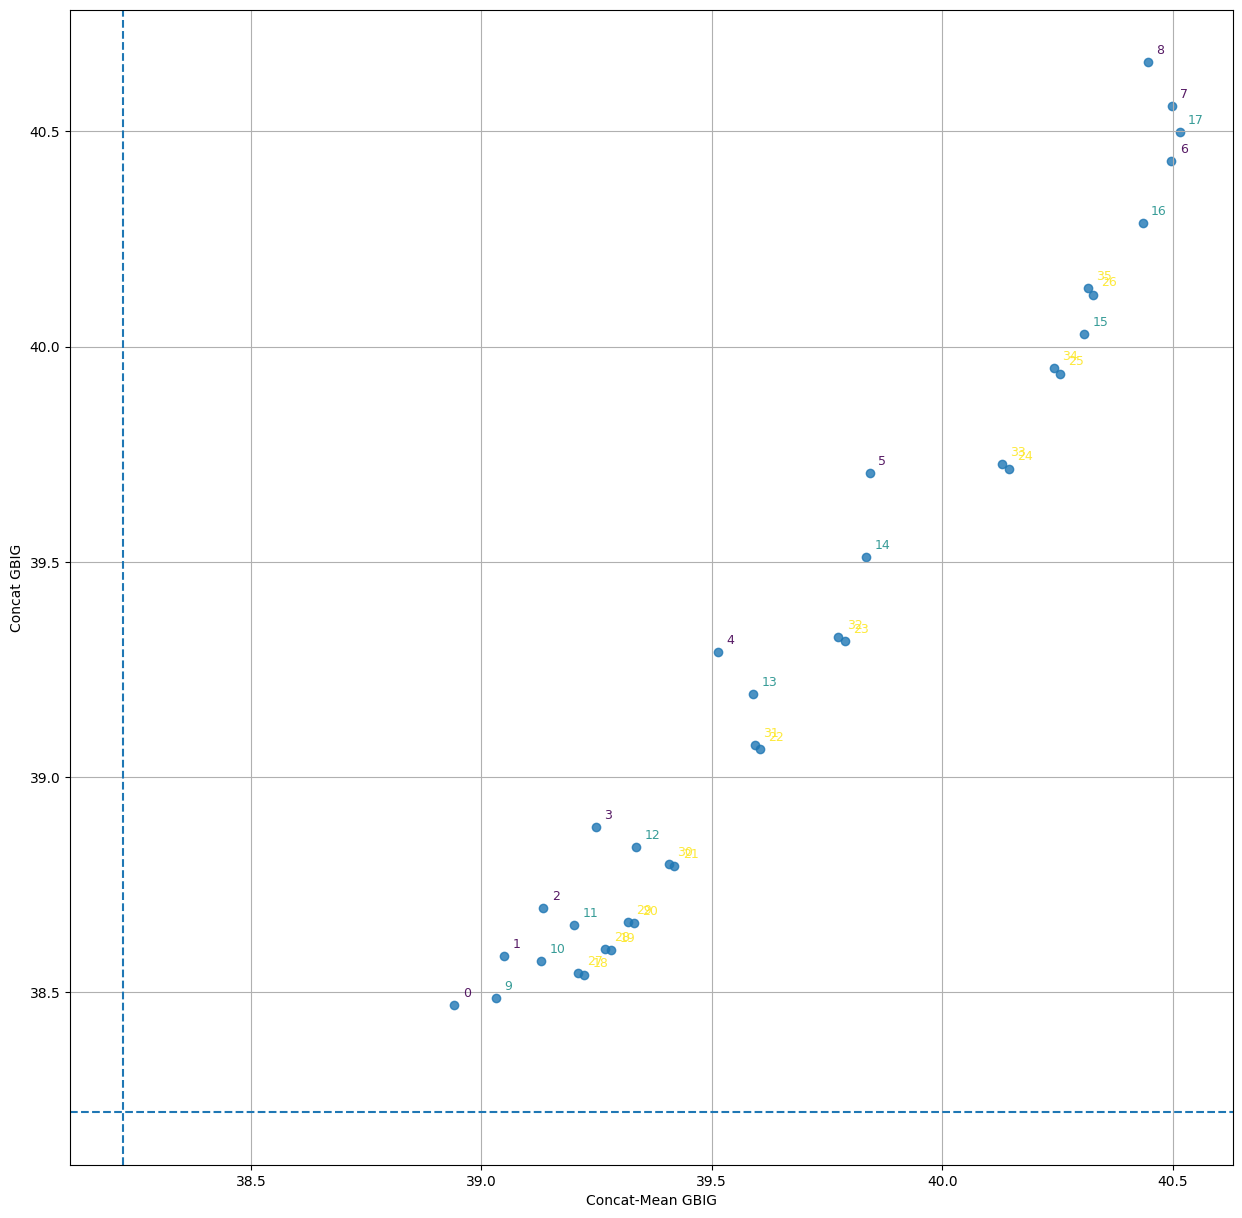

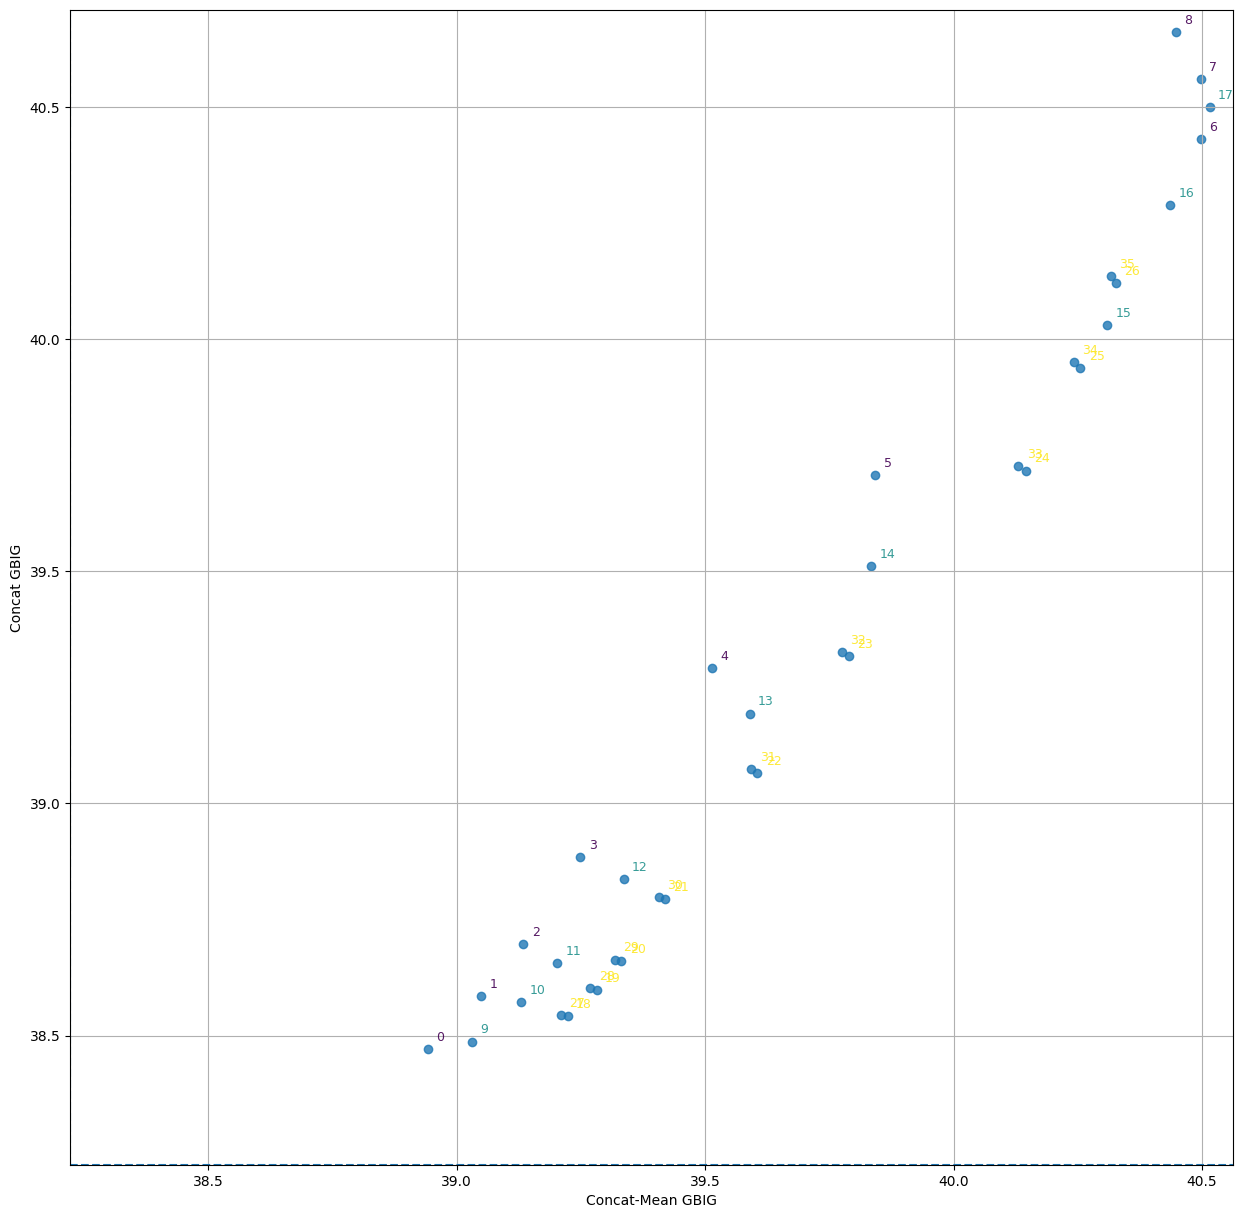

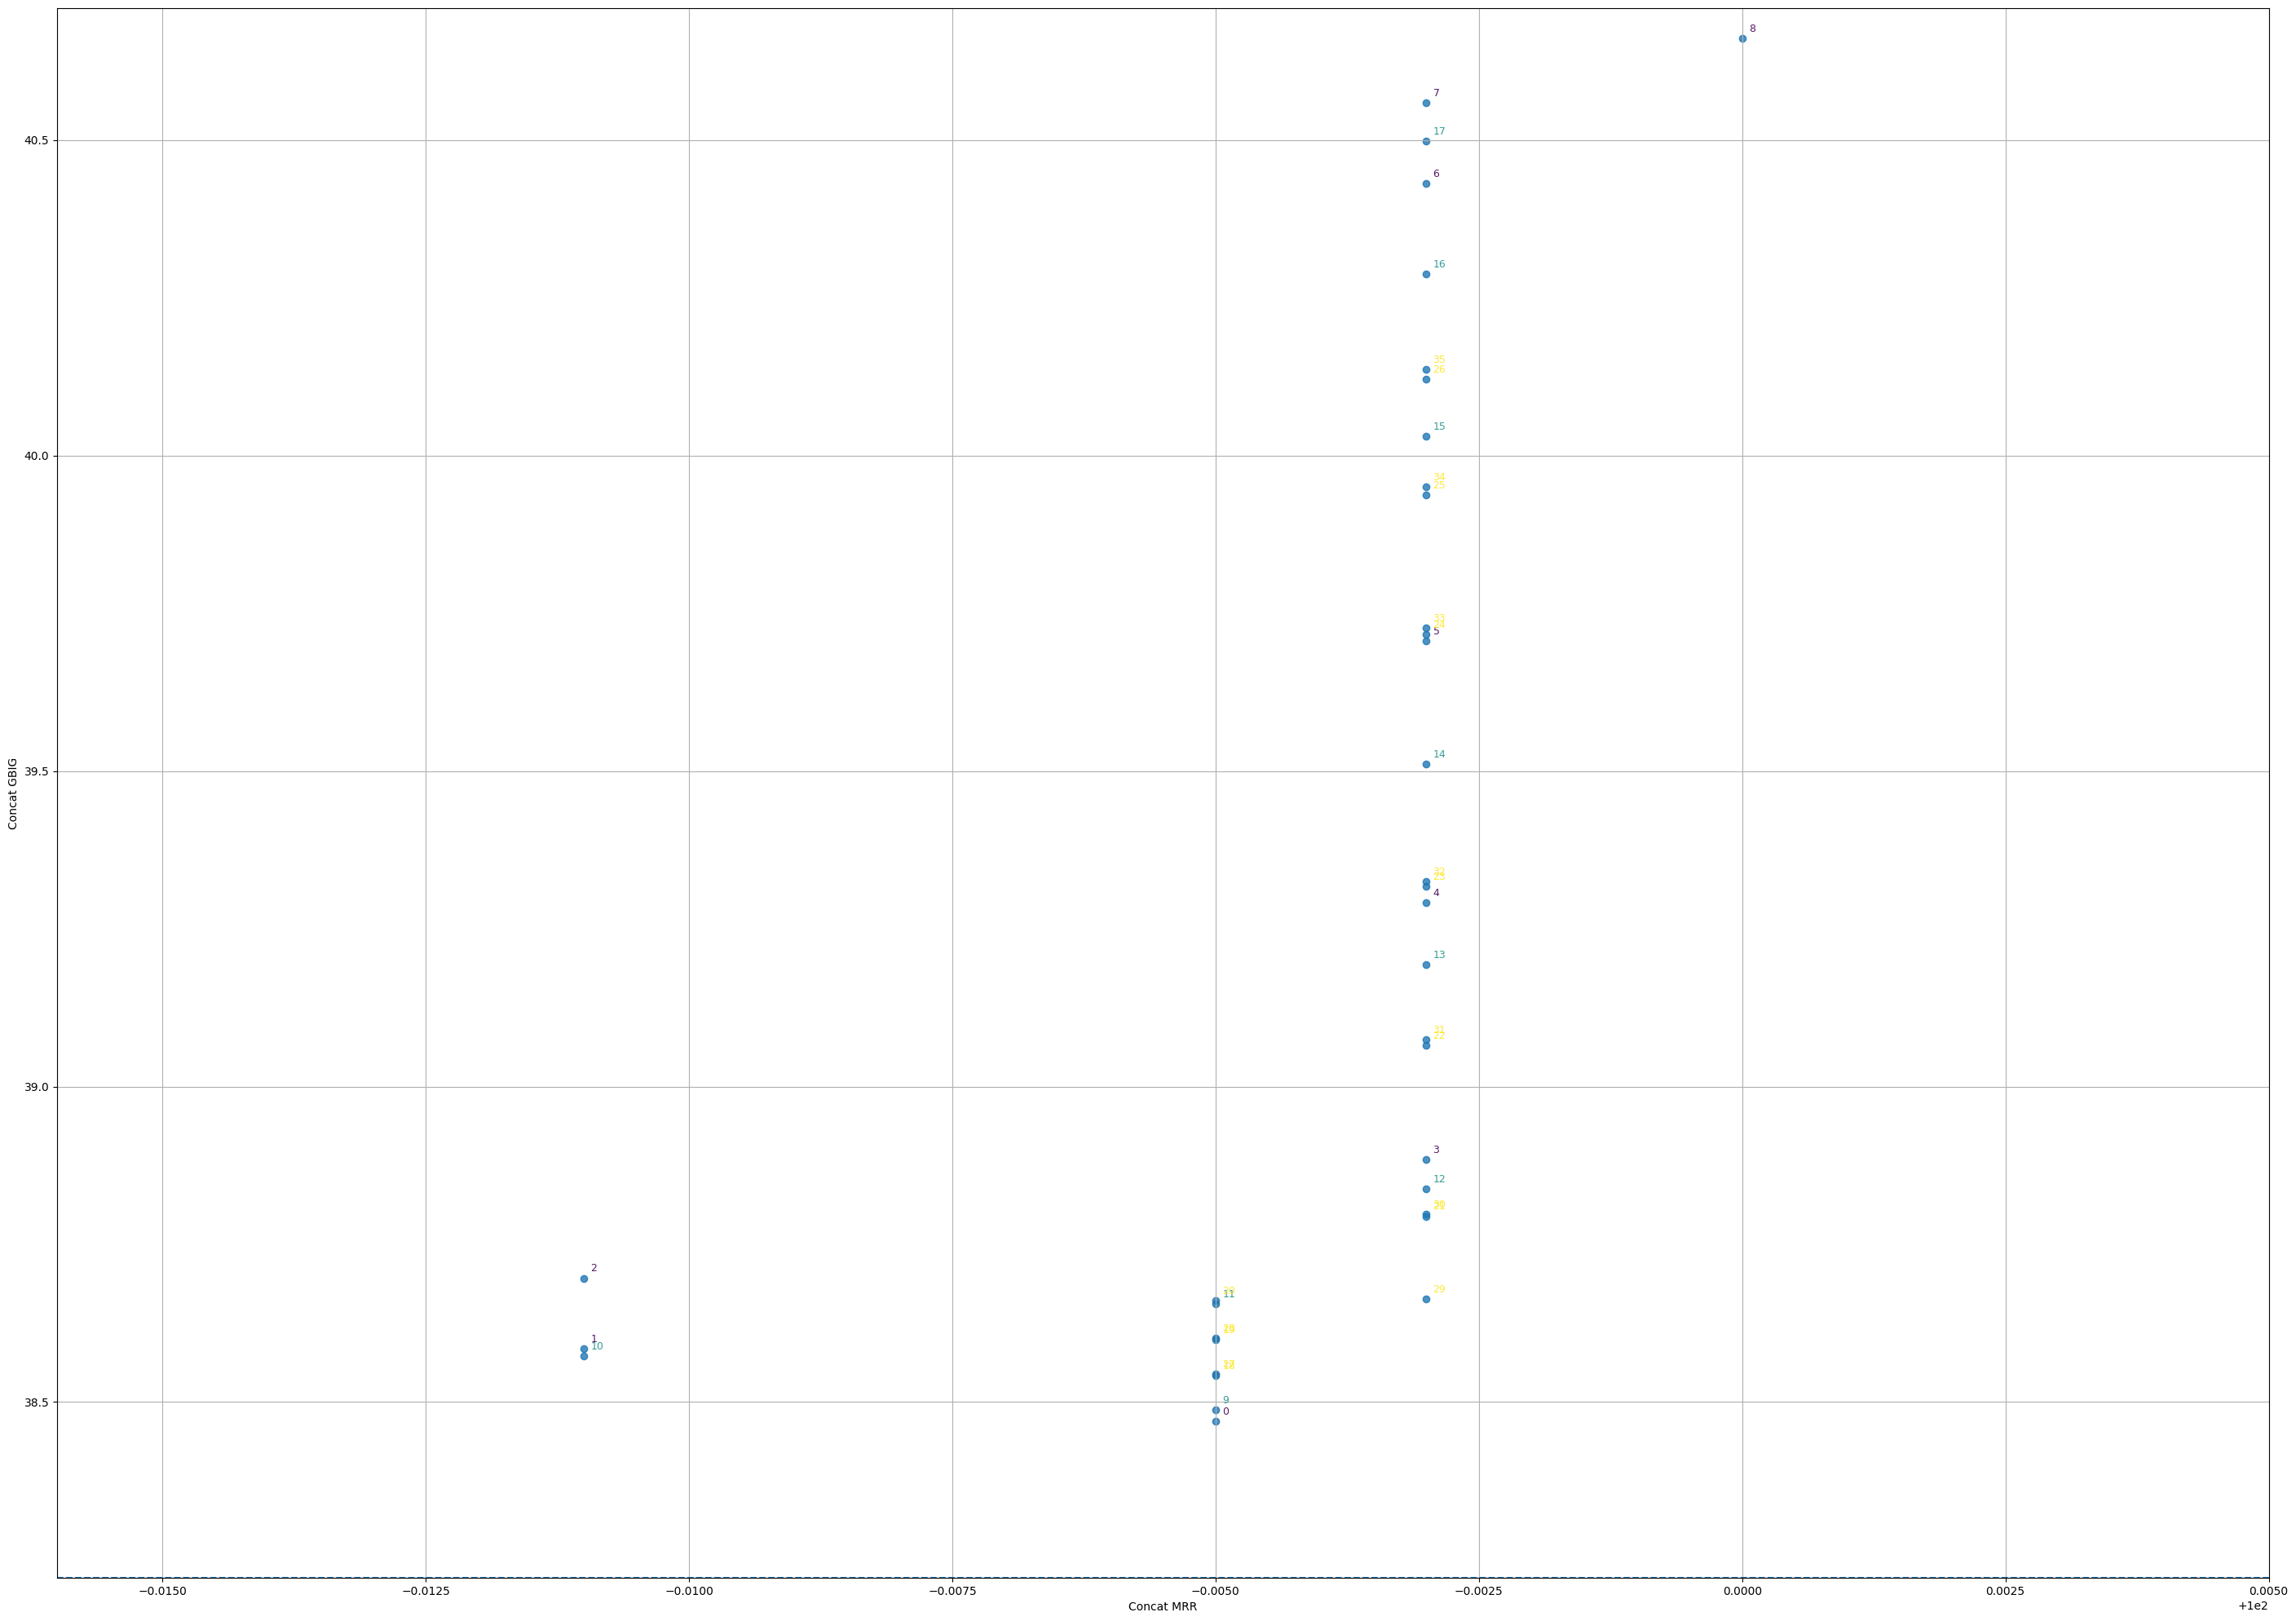

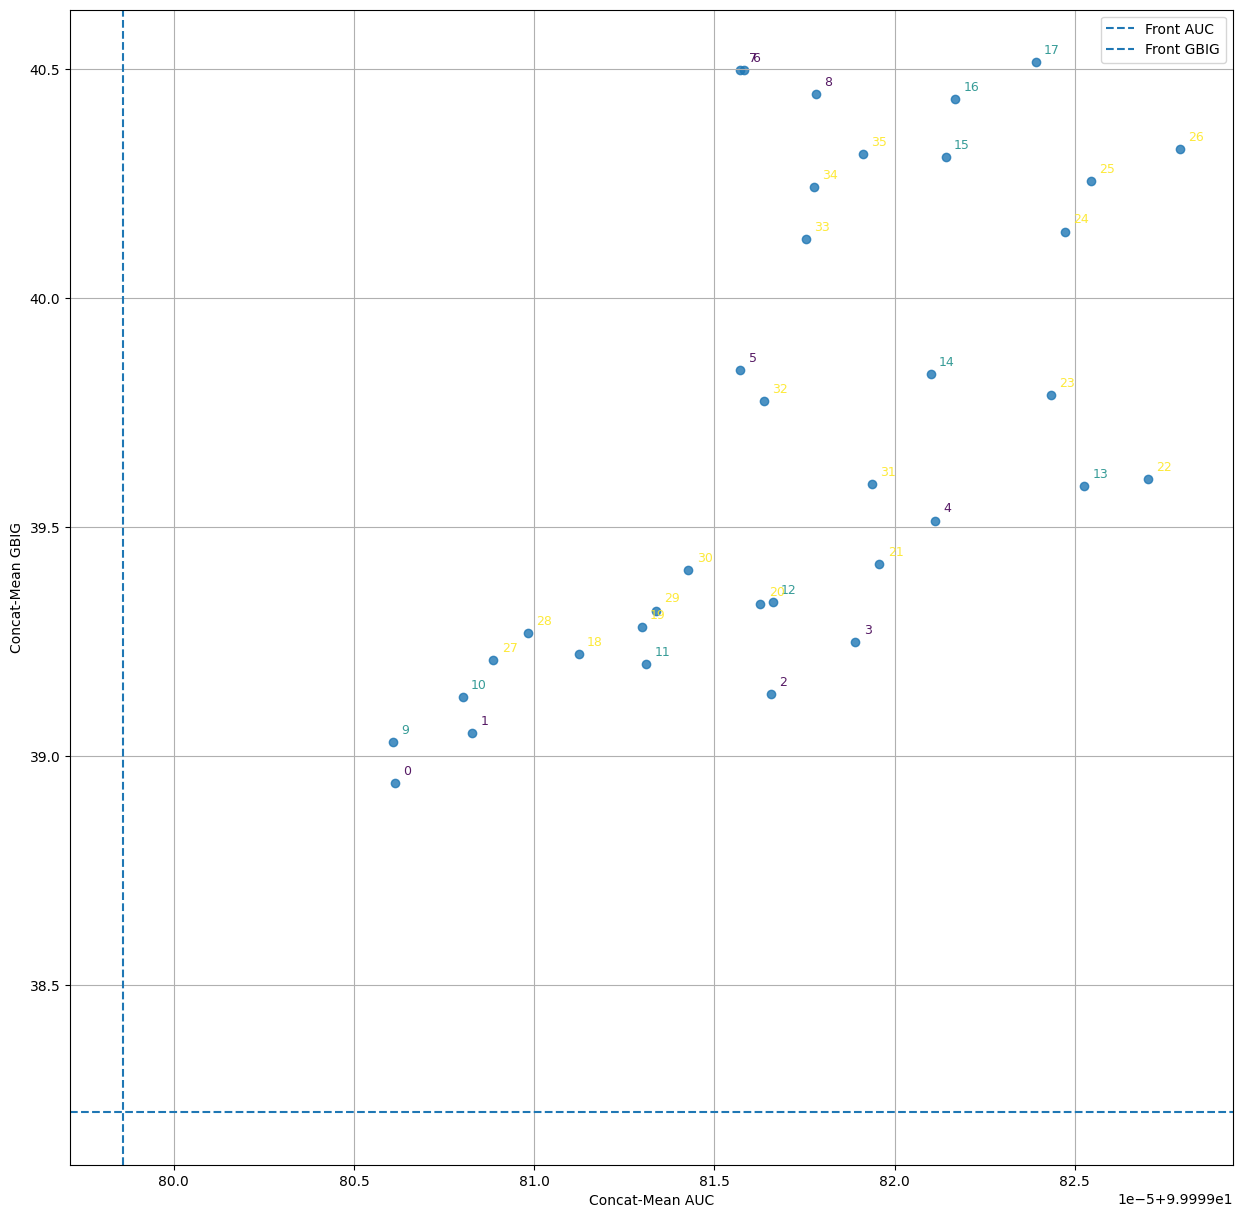

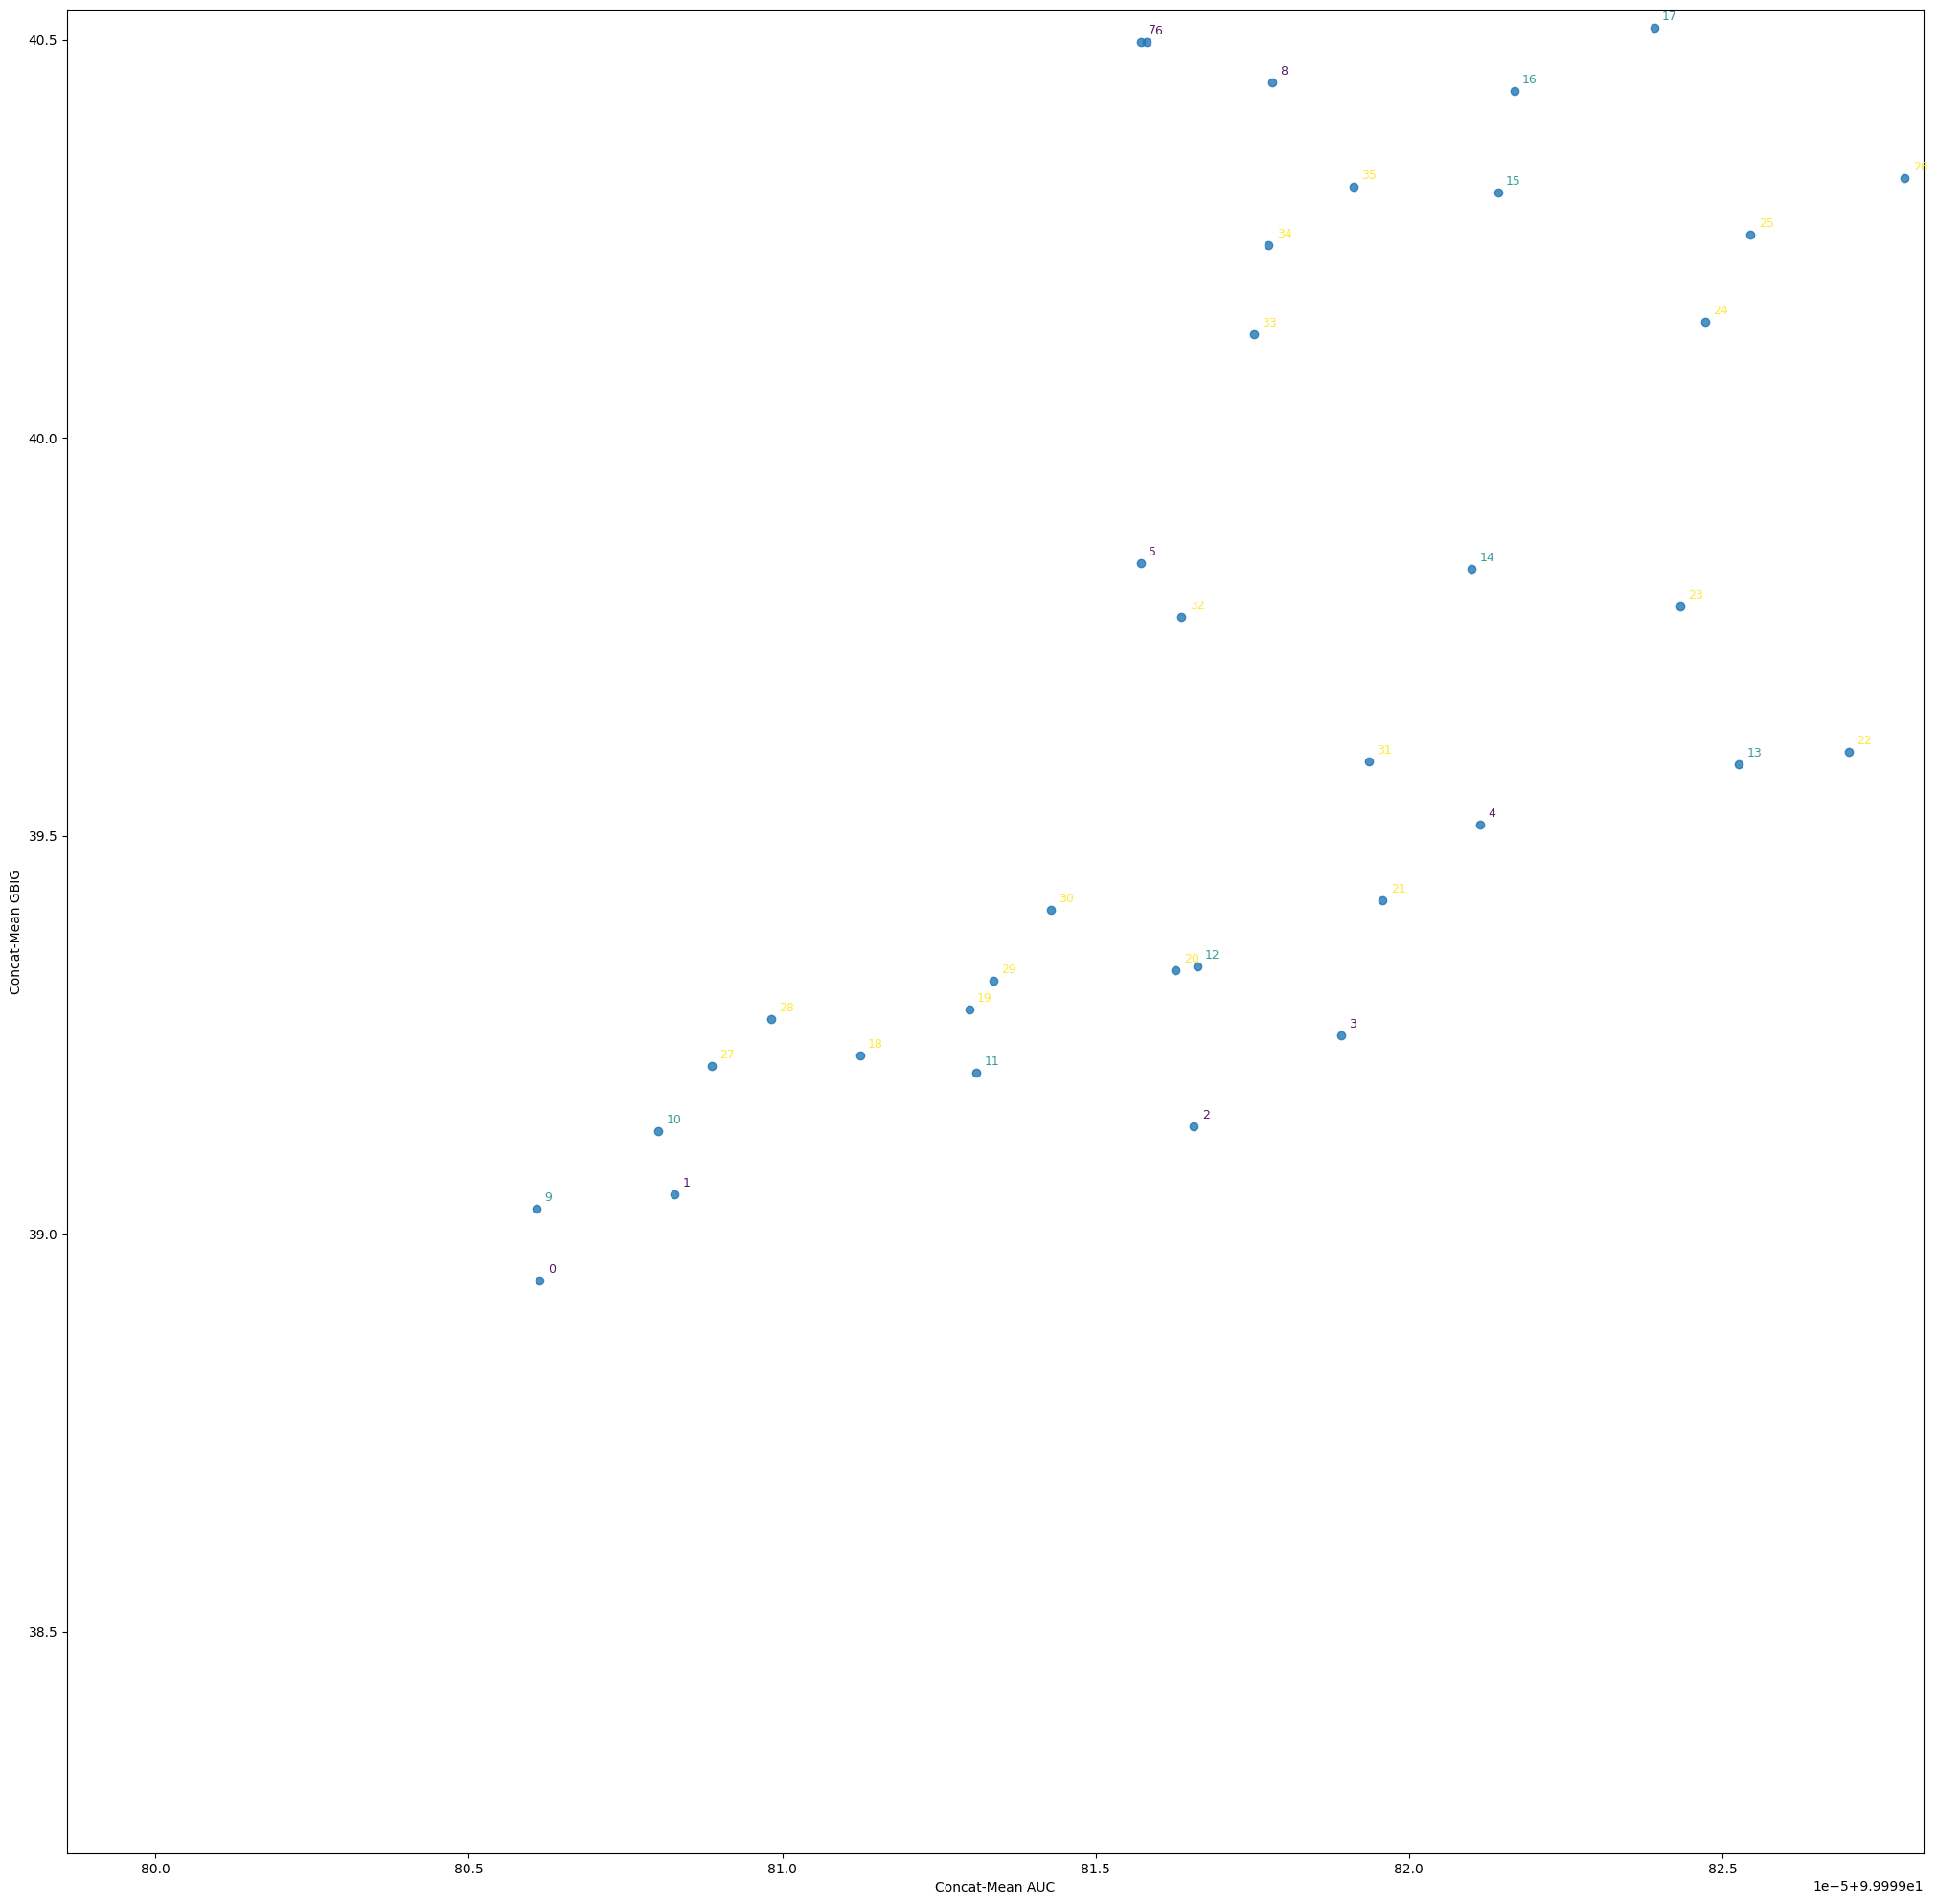

In [34]:
process_and_plot_mrr('mass_eval_late_fusion_glint100_extrasV5Full.txt', ylim=(99.97, 100), full_concat_mrr_ref=100, last_n=36)